Details of many rSTAN examples:
http://hedibert.org/wp-content/uploads/2021/02/stan-rstan-examples.html

In [2]:
%load_ext cmdstanjupyter

The cmdstanjupyter extension is already loaded. To reload it, use:
  %reload_ext cmdstanjupyter


In [3]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg
from scipy import special
import matplotlib.pyplot as plt
import arviz as ar

# Global Functions

In [4]:
# function to find mode
def mode_finder(arr):
  hist = np.histogram(arr)
  return(hist[1][np.argmax(hist[0])])

In [5]:
# l_2 distance squared
def l2_sq(a, b):
  temp = [v**2 for v in a - b]
  return np.sum(temp)

In [6]:
# Squared Exponential Kernel vector (isotropic scale parameter 'l') from covariate matrix X_mat and vector x_vec
def kernel_vec_sqexp(X_mat, x_vec, l):
  return np.array([np.exp(-l2_sq(w, x_vec)/(2 * l**2)) for w in X_mat])

In [7]:
# Squared Exponential Kernel matrix (isotropic scale parameter 'l') from covariate matrix X_mat
def kernel_sqexp(X_mat, l):
  return np.array([[np.exp(-l2_sq(w, v)/(2 * l**2)) for w in X_mat] for v in X_mat])

In [8]:
def GP_mean(y_vec, X_mat, x_vec):
  n = len(y_vec)
  v = kernel_vec_sqexp(X_mat, x_vec, l = 1)
  M = linalg.inv(np.identity(n) + kernel_sqexp(X_mat, l = 1))
  return np.dot(np.matmul(M, v), y_vec)

In [9]:
# function to create cell_count values m_h from H, where H is a numpy array of non-negative integers 
# and there are N possible values
# output is count vector of size equal to the number of unique entries in H 
def m_count(H):
  out = []
  for h in range(N):
    out = out + [len(H) - np.count_nonzero(H - h)]
  return np.array(out)

In [10]:
# creating one array frowm two arrays by merging based on an indicator vector of 0's and 1's
# e.g. given ind_vec = (0, 1, 1, 0, 0, 1), arr0 = (a, b, c) and arr1 = (x, y, z), we have: out = (a, x, y, b, c, z)
# must have: len(arr0) + len(arr1) = len(ind_vec)
def ind_merge(ind_vec, list0, list1):
  if len(list0) + len(list1) != len(ind_vec):
    raise ValueError(" Must have: len(arr1) + len(arr2) = len(ind_vec) !! ")
  a0 = list0.copy()
  a1 = list1.copy()
  n = len(ind_vec)
  out = [None]*n
  for j in range(n):
    if ind_vec[j] == 0:
      out[j] = a0[0]
      a0.pop(0)
    else:
      out[j] = a1[0]
      a1.pop(0)
  return out

In [11]:
aa = [[5, 6], [-5, -6]]
bb = [[1, 2], [-1, -2]]
ind_merge(np.array([0, 1, 1, 0]), list0 = aa, list1 = bb)

[[5, 6], [1, 2], [-1, -2], [-5, -6]]

In [12]:
ax = [1, 2, 3, 4]
ax.pop(0)
ax

[2, 3, 4]

In [13]:
# x_new: p times 1, which is added infront of d0, d1 to make x_vec: (p + 2) times 1
def pce(d0, d1, x_new, d_bar):
  x_vec = np.array(list(x_new) + [d0, d1])
  X_mat = create_X_full(X_start, d_bar)
  X_0, Y_0, X_1, Y_1 = create_XY01(X_mat, Y, ind_vec)
  return GP_mean(Y_1, X_1, x_vec) - GP_mean(Y_0, X_0, x_vec)

# Data Formatting and Global Inputs

List of Global Inputs:

Y, X, ind_vec, N, n, p, r, d_obs, X_start, X_bar, X_0_bar, X_1_bar, K_00, K_11, 


In [14]:
# formatting the data

df = pd.read_csv('beta_sim_data.csv')
df = df.drop('y', axis = 1)
# df = df.drop('Unnamed: 0', axis = 1)
df.rename(columns = {'a1':'A', 'D1':'d0', 'D2':'d1', 'y1':'Y'}, inplace = True)

def replacer(x):
  if x == -1:
    return 0
  else:
    return 1


df['A'] = df['A'].apply(replacer)
df

A        d0        d1         Y        X1        X2        X3
0   0  0.884675  0.568836  0.439148 -0.454550 -0.417998  0.219849
1   0  0.403787  0.256451  0.015733 -0.176368  0.133884  1.045909
2   1  0.903524  0.548765 -0.559822 -0.872251 -0.058267  0.371248
3   1  0.013991  0.206254  0.167612 -0.425767  1.013995  1.263376
4   0  0.000731  0.171821 -0.986436 -2.152183 -0.700562  0.503286
.. ..       ...       ...       ...       ...       ...       ...
95  1  0.129272  0.378023  0.647533 -1.258246  1.707439  0.781783
96  0  0.483163  0.320563 -0.683739 -1.958932 -1.444975 -0.018028
97  0  0.813653  0.331943  0.589778 -0.658879  0.161960  0.468399
98  1  0.073288  0.420793 -0.312052  0.105914  0.345063  1.657928
99  1  0.000294  0.308084 -0.730508  0.992791 -0.356494  2.053496

[100 rows x 7 columns]

In [15]:
df_01 = df.groupby('A')

In [16]:
# this stores the entire groups as data-frames, separately, with the grouping varaible as the first column
df_0 = df_01.get_group(0)
df_1 = df_01.get_group(1)

In [17]:
df_0.head(4)

A        d0        d1         Y        X1        X2        X3
0  0  0.884675  0.568836  0.439148 -0.454550 -0.417998  0.219849
1  0  0.403787  0.256451  0.015733 -0.176368  0.133884  1.045909
4  0  0.000731  0.171821 -0.986436 -2.152183 -0.700562  0.503286
9  0  0.048321  0.038611  0.699934  0.665917 -0.257077 -0.187417

In [18]:
df.head(4)

A        d0        d1         Y        X1        X2        X3
0  0  0.884675  0.568836  0.439148 -0.454550 -0.417998  0.219849
1  0  0.403787  0.256451  0.015733 -0.176368  0.133884  1.045909
2  1  0.903524  0.548765 -0.559822 -0.872251 -0.058267  0.371248
3  1  0.013991  0.206254  0.167612 -0.425767  1.013995  1.263376

It is important that the loaded data-frame is ALWAYS of this format:

( Action(Treatment), d0, d1, Covariates )

In [19]:
# this code converts the pandas data-frame into numpy array
data = df.values

# first 3 rows of data: N times (1 + 2 + 1 + p)
data[:3]

array([[ 0.        ,  0.88467515,  0.56883575,  0.43914772, -0.45455033,
        -0.41799797,  0.21984889],
       [ 0.        ,  0.40378726,  0.25645108,  0.01573317, -0.17636845,
         0.13388425,  1.04590889],
       [ 1.        ,  0.9035238 ,  0.54876517, -0.55982152, -0.87225073,
        -0.05826671,  0.37124757]])

## $Y, X, N, n, p, r, d_{obs}, ind_{vec}$

In [20]:
# defining the treatment vector for n patients that determine which potential compliances are observed
ind_vec = np.array([v[0] for v in data], dtype = 'int32')
ind_vec

array([0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [21]:
# choosing number of Beta densities to mix with Dirichlet process: N
N = 5

# sample size: n
n = len(data)

# baseline covariate size: p
p = len(data[0]) - 4

# number of patients receiving no tretament, i.e. size of Tau_0: r
r = n - np.sum(ind_vec)

In [22]:
# creating the observed output vector, Y: n times 1
Y = np.array([v[3] for v in data])

# first 5 observed Y values
Y[:5]

array([ 0.43914772,  0.01573317, -0.55982152,  0.16761223, -0.98643609])

In [23]:
# creating baseline covariate matrix X: n times p
X = np.array([v[-3:] for v in data])

# first 5 rows of X
X[:5]

array([[-0.45455033, -0.41799797,  0.21984889],
       [-0.17636845,  0.13388425,  1.04590889],
       [-0.87225073, -0.05826671,  0.37124757],
       [-0.42576662,  1.0139949 ,  1.26337621],
       [-2.15218318, -0.70056224,  0.50328569]])

In [24]:
# creating the observed compliance vector, d_obs: n times 1
d_obs = np.array([a[1] if a[0] == 0 else a[2] for a in data])
d_obs

array([8.84675155e-01, 4.03787262e-01, 5.48765170e-01, 2.06254193e-01,
       7.30752398e-04, 5.72644463e-01, 1.63954321e-01, 4.69765259e-01,
       4.96766778e-01, 4.83208415e-02, 1.34072237e-01, 4.20131796e-02,
       2.42670454e-01, 2.93657179e-01, 7.92936258e-01, 6.75430545e-01,
       2.99221493e-01, 3.27330360e-01, 4.02688940e-04, 7.13804815e-02,
       5.42689699e-01, 7.56591968e-01, 9.23114687e-02, 8.89427588e-01,
       7.97851355e-02, 8.30723137e-01, 6.56013055e-02, 1.02237286e-01,
       2.02479268e-01, 8.21668958e-01, 1.50511695e-01, 1.49568484e-01,
       1.13059507e-01, 6.94622892e-01, 7.34541555e-01, 1.71788068e-01,
       2.02799227e-02, 6.24732333e-01, 8.02713880e-02, 5.31419714e-02,
       3.47321455e-01, 2.24450947e-01, 2.63675976e-01, 3.24556622e-01,
       4.57416727e-01, 7.85816630e-01, 2.96305734e-01, 1.59888516e-01,
       1.42964897e-01, 5.67317236e-03, 6.47676198e-01, 2.49526518e-02,
       5.86345478e-03, 3.28815822e-01, 3.27742550e-02, 2.04816847e-01,
      

In [25]:
# creating starting covariate matrix X_start: n times (p + 2), containing first the baseline covariates and then BOTH compliances, format is (covariates, d0, d1)
X_start = np.array([np.concatenate((v[-p:], v[1:3])) for v in data])

# first 5 rows of X_start
X_start[:5]

array([[-4.54550333e-01, -4.17997974e-01,  2.19848890e-01,
         8.84675155e-01,  5.68835745e-01],
       [-1.76368451e-01,  1.33884249e-01,  1.04590889e+00,
         4.03787262e-01,  2.56451078e-01],
       [-8.72250728e-01, -5.82667131e-02,  3.71247572e-01,
         9.03523801e-01,  5.48765170e-01],
       [-4.25766624e-01,  1.01399490e+00,  1.26337621e+00,
         1.39913147e-02,  2.06254193e-01],
       [-2.15218318e+00, -7.00562240e-01,  5.03285689e-01,
         7.30752398e-04,  1.71821041e-01]])

Before we create X_0 and X_1 given any d_bar, we will first create X_full matrix from X_start given d_bar, and then write a function to update it by properly (using ind_vec).

In [26]:
# this function creates the starting full covariate matrix of the form: [baseline covariates, start d0 OR given d0, start d1 OR given d1]
def create_X_full(X_start, d_bar):
  X_full = X_start
  for j in range(n):
    if ind_vec[j] == 1:
      X_full[j][-2] = d_bar[j]
    else:
      X_full[j][-1] = d_bar[j]
  return X_full

In [27]:
# this function creates X_0, Y_0, X_1, Y_1 based on the ind_vec
# output pattern: X_0, Y_0, X_1, Y_1
def create_XY01(X_full, Y, ind_vec):
  X_0 = []; X_1 = []; Y_0 = []; Y_1 = []
  for j in range(n):
    if ind_vec[j] == 0:
      X_0 = X_0 + [X_full[j]]
      Y_0 = Y_0 + [Y[j]]
    else:
      X_1 = X_1 + [X_full[j]]
      Y_1 = Y_1 + [Y[j]]
  return np.array(X_0), np.array(Y_0), np.array(X_1), np.array(Y_1)

In [29]:
# fixing the value of nu_0 at 100
nu_0 = 100

## $\overline{X}, \overline{X}_0, \overline{X}_1$ and df_bar

In [30]:
# creating the concatenated covariate matrix X_bar, where the observed compliances are merged with the covariates
# this function removes (row-wise) unobserved potential compliances
def format_potential(v):
  if v.iloc[0] == 0:
    v = v.drop(['A', 'd1', 'Y'])
  else:
    v = v.drop(['A', 'd0', 'Y'])
  return v

# X_bar: n times (p + 1), with the observed compliances forming the last column, and the first columns form the original baseline co-variate matrix
X_bar = np.array([v[~np.isnan(v)] for v in np.array(df.apply(format_potential, axis = 1))])
X_bar[:5]

array([[-4.54550333e-01, -4.17997974e-01,  2.19848890e-01,
         8.84675155e-01],
       [-1.76368451e-01,  1.33884249e-01,  1.04590889e+00,
         4.03787262e-01],
       [-8.72250728e-01, -5.82667131e-02,  3.71247572e-01,
         5.48765170e-01],
       [-4.25766624e-01,  1.01399490e+00,  1.26337621e+00,
         2.06254193e-01],
       [-2.15218318e+00, -7.00562240e-01,  5.03285689e-01,
         7.30752398e-04]])

In [31]:
# creating X_0_bar, X_1_bar from X_bar by separating the 0 and 1 rows, X_0_bar: r times (p + 1), X_1_bar: (n - r) times (p + 1)
X_0_bar = []; X_1_bar = []
for j in range(n):
  if ind_vec[j] == 0:
    X_0_bar = X_0_bar + [X_bar[j]]
  else:
    X_1_bar = X_1_bar + [X_bar[j]]
X_0_bar = np.array(X_0_bar)
X_1_bar = np.array(X_1_bar)

In [32]:
X_0_bar[:3]

array([[-4.54550333e-01, -4.17997974e-01,  2.19848890e-01,
         8.84675155e-01],
       [-1.76368451e-01,  1.33884249e-01,  1.04590889e+00,
         4.03787262e-01],
       [-2.15218318e+00, -7.00562240e-01,  5.03285689e-01,
         7.30752398e-04]])

In [33]:
X_1_bar[:3]

array([[-0.87225073, -0.05826671,  0.37124757,  0.54876517],
       [-0.42576662,  1.0139949 ,  1.26337621,  0.20625419],
       [-2.21046409, -1.34816355,  0.311738  ,  0.57264446]])

In [34]:
df_bar = pd.DataFrame(X_bar)

## $K_{0, 0}, K_{1,1}$

\begin{equation}
    K_{l, l} := \left( \left( e^{- a_n^2 \rho_{l, i, i'}^2 } \right) \right)_{i, i' \in \mathcal{T}_l}, \; l = 0, 1, \quad K_{0, 1} := \left( \left( e^{- a_n^2 \left( d_{0, i} - d_{0, i'} \right)^2 } \right) \right)_{i, i' \in \mathcal{T}_1}, \quad K_{1, 0} := \left( \left( e^{- a_n^2 \left( d_{1, i} - d_{1, i'} \right)^2 } \right) \right)_{i, i' \in \mathcal{T}_0}
\end{equation}

In [35]:
# creating K_00: r times r, and K_11: (n - r) times (n - r)
# K_00, K_11 are fully observed, and stay constant throughout the analysis
# Note: K_10, K_01 are created WITHIN STAN code during Gibbs updates
K_00 = kernel_sqexp(X_mat = X_0_bar, l = 1)
K_11 = kernel_sqexp(X_mat = X_1_bar, l = 1)

In [36]:
# first principal sub-matrix of K_00
[v[:4] for v in K_00[:4]]

[array([1.        , 0.52319883, 0.14782192, 0.34186174]),
 array([0.52319883, 1.        , 0.07977703, 0.28511215]),
 array([0.14782192, 0.07977703, 1.        , 0.01344897]),
 array([0.34186174, 0.28511215, 0.01344897, 1.        ])]

In [37]:
# first principal sub-matrix of K_11
[v[:4] for v in K_11[:4]]

[array([1.        , 0.32266193, 0.17739432, 0.11794951]),
 array([0.32266193, 1.        , 0.00742875, 0.09040647]),
 array([0.17739432, 0.00742875, 1.        , 0.00102807]),
 array([0.11794951, 0.09040647, 0.00102807, 1.        ])]

# Parameter Initialization

The full set of parameters to be updated:
\begin{equation}
    \mu_0, \mu_1, \overline{d}, \left( w_h \right)_{h = 1}^N, \left( B_h \right)_{h = 1}^N, \left( H_i \right)_{i = 1}^n, \alpha
\end{equation}

The following initializes all the parameters:

In [39]:
# initializing (randomly) array for the indexing variable H_i, i = 0, ... n - 1
H = np.array([list(v).index(1) for v in np.random.multinomial(n = 1, pvals = np.ones(N)/N, size = n)])

# initializing (randomly) array for the base measure variable B_h, h = 0, ... N - 1
B = np.random.multivariate_normal(mean = np.zeros(p + 1), cov = np.identity(p + 1), size = N)

# initializing array for Dirichlet component weight variable w_h, h = 0, ... N - 1
W = np.ones(N)/N

# initializing scale variable alpha
alpha = 1

# initializing mu_0, mu_1
mu_0 = np.zeros(r)
mu_1 = np.zeros(n - r)

# initializing d_bar
d_bar = np.ones(n)/10

# Local functions

## $\theta_i$ - functions

\begin{equation}
    \mathbb{E} \left[ \overline{d}_i \Big| B = \left(B_h \right)_{h = 1}^N, H_i \right] \approx \theta_i = \frac{e^{\overline{X}_i^T B_{H_i}}}{1 + e^{\overline{X}_i^T B_{H_i}}}, \; i = 1 \dots n
\end{equation}

In [40]:
# creating the theta_i function for i-th patient and any vector b
def theta_i(i, b):
  val = np.exp(np.dot(X_bar[i], b))
  return val/(val + 1)

# testing the function
theta_i(i = 1, b = np.random.normal(size = p + 1))

0.15545703116884194

In [41]:
# creating the following function to generate the theta_i value vectors separately for 0, 1 in theta_0_vec, theta_1_vec given B, H
def create_theta_01(B, H):
  theta_vec = np.array([theta_i(i, B[H[i]]) for i in range(n)])
  theta_0_vec = []; theta_1_vec = []
  for j in range(n):
    if ind_vec[j] == 0:
      theta_0_vec = theta_0_vec + [theta_vec[j]]
    else:
      theta_1_vec = theta_1_vec + [theta_vec[j]]
  return np.array(theta_0_vec), np.array(theta_1_vec)

# testing the function
theta_0_vec, theta_1_vec = create_theta_01(B, H)

In [42]:
theta_0_vec

array([0.37350375, 0.76857749, 0.18654502, 0.69060071, 0.41532464,
       0.36753126, 0.78142909, 0.73068869, 0.64289518, 0.32432653,
       0.06667851, 0.68727635, 0.85263601, 0.7736842 , 0.81623678,
       0.76952903, 0.85190723, 0.51399501, 0.95978434, 0.04961046,
       0.61920696, 0.06872097, 0.83140944, 0.83281261, 0.85357956,
       0.68763827, 0.00770208, 0.74087681, 0.53034508, 0.72645026,
       0.29731879, 0.81497334, 0.2894747 , 0.22354485, 0.73113626,
       0.68011435, 0.48553755, 0.23393909, 0.21484598, 0.44824429,
       0.34099475, 0.58533506, 0.76077283, 0.07639751, 0.61154952,
       0.70660552, 0.66260226, 0.41656324, 0.91788445, 0.79077881,
       0.6429887 , 0.3575017 ])

In [43]:
theta_1_vec

array([0.39385293, 0.24930591, 0.9198678 , 0.22205889, 0.71998776,
       0.71218985, 0.27531713, 0.86165422, 0.86434197, 0.61774202,
       0.08481195, 0.43200356, 0.72220768, 0.4876759 , 0.54926759,
       0.77057346, 0.58672514, 0.76922156, 0.0444827 , 0.73662981,
       0.54391556, 0.6147049 , 0.57978939, 0.42065022, 0.31237587,
       0.73696911, 0.21043689, 0.50220269, 0.63290521, 0.1147391 ,
       0.69925399, 0.62182712, 0.94989104, 0.63470322, 0.59854865,
       0.52698435, 0.12169636, 0.72689811, 0.6229846 , 0.65606544,
       0.08881418, 0.6717235 , 0.788557  , 0.07874927, 0.17268912,
       0.13153355, 0.10754062, 0.04010395])

## $V_i$ - function

\begin{equation}
    \begin{split}
        V_i(b) := &\left( \frac{\nu_0 e^{ \overline{X}_i^T b }}{1 + e^{ \overline{X}_i^T b }} - 1 \right) \log d_{1 - T_i, i} + \left( \frac{\nu_0}{1 + e^{ \overline{X}_i^T b }} - 1 \right) \log \left( 1 - d_{1 - T_i, i} \right) \\
        &- \log \Gamma \left( \frac{\nu_0 e^{ \overline{X}_i^T b }}{1 + e^{ \overline{X}_i^T b }} \right) -  \log \Gamma \left( \frac{\nu_0}{1 + e^{ \overline{X}_i^T b }} \right)
    \end{split}
\end{equation}

In [44]:
# defining the V_i(b) function that stores the logarithm of the GLM Beta density
def V_i(i, b, d_bar):
  return (nu_0 * theta_i(i, b) - 1) * np.log(d_bar[i]) + (nu_0 * (1 - theta_i(i, b)) - 1) * np.log(1 - d_bar[i]) - np.log(special.gamma(nu_0 * theta_i(i, b))) - np.log(special.gamma(nu_0 * (1 - theta_i(i, b)))) + np.log(special.gamma(nu_0))

In [45]:
# testing the possible range of V_i
max([V_i(i = 50, b = np.random.normal(size = p + 1), d_bar = np.ones(n)/1.5) for j in range(10000)])

2.1333931601978975

In [46]:
# testing the possible range of V_i
min([V_i(i = 50, b = np.random.normal(size = p + 1), d_bar = np.ones(n)/1.5) for j in range(10000)])

-106.29395354179456

## X_Hd list from d_bar and H

In [47]:
# separating the beta-likelihoods i = 1...n for the compliances based on H
# following function creates a list of N_0 entries
# each enrty is a list of 2, one matrix and one vector
# the rows of the h-th matrix are i-th (i = 1...n) rows of X_bar, but only when H[i] = h
# the entries in the h-th vector are the i-th (i = 1...n) entries in d_bar, but only when H[i] = h
def create_X_Hd(d_bar, H):
  active_list = list(frozenset(H))
  N_0 = len(active_list)
  X_Hd = [None]*N_0
  df1 = pd.DataFrame.copy(df_bar, deep = True) # pass by value (not reference) so that original df_bar stays intact
  df1['d_bar'], df1['H'] = [d_bar, H]
  df2 = df1.groupby('H')
  for k in range(N_0):
    out_temp = df2.get_group(active_list[k]).drop('H', axis = 1, inplace = False)
    out2 = np.array(out_temp['d_bar'])
    out1 = np.array(out_temp.drop('d_bar', axis = 1, inplace = False))
    X_Hd[k] = [out1, out2]
  return X_Hd

# Gibbs Updates

## Individual updates of the parameters: 

$\mu_0, \mu_1, \overline{d}, \left( w_h \right)_{h = 1}^N, \left( B_h \right)_{h = 1}^N, \left( H_i \right)_{i = 1}^n, \alpha$

The following gives the full conditionals to be cycled through for the Gibbs updates:

\begin{equation}
    \begin{split}
        &\mu_l \big| Y_l, d_k^{(l)} \sim N \left( \left[ K_l^{-1} + I \right]^{-1} Y_l, \left[ K_l^{-1} + I \right]^{-1} \right), \; l, k = 1, \, l \neq k, \\
        &\mathbb{P} \left[ d^{(l)}_k \big| \; \mu_l, \left( B_h \right)_{h = 1}^N, \left( H_i \right)_{i = 1}^n \right] \propto \exp \Bigg[  - \frac{1}{2} \log \left| K_l \right| - \frac{1}{2} \mu_l^T K_l^{-1} \mu_l + \sum_{i \in \mathcal{T}_l} \left( \nu_0 \theta_i - 1 \right) \log d_{k, i} \\ 
        & \hspace{172pt} + \sum_{i \in \mathcal{T}_l} \left( \nu_0 \left( 1 - \theta_i \right) - 1 \right) \log \left( 1 - d_{k, i} \right) \Bigg], \; l, k = 0, 1, \; l \neq k \\
        & \left( w_h \right)_{h = 1}^N \big| \alpha, \left( H_i \right)_{i = 1}^n \sim \mathcal{D} \left( \frac{\alpha}{N} + m_1, \dots \frac{\alpha}{N} + m_N \right) \\
        &\alpha \big| \left( w_h \right)_{h = 1}^N \propto \exp \left[ \alpha \left( \frac{\sum_{h = 1}^N \log w_h}{N} - 1 \right) + \log \Gamma \left( \alpha \right) - N \log \Gamma \left( \frac{\alpha}{N} \right) \right] \\
        & \underline{B} \big| \left( H_i \right)_{i = 1}^n \overset{i.i.d}{\sim} N \left( 0, \mathbb{I}_{p + 1} \right), \\
        &\mathbb{P} \left[ \overline{B} \big| \left( H_i \right)_{i = 1}^n, \overline{d} \right] \propto \exp \left[ \; \sum_{b \in \overline{B}} \left( - \frac{\| b \|^2}{2} + \sum_{1 \leq i \leq n : \; B_{H_i} = \, b} V_i(b) \right) \right] \\
        & \mathbb{P} \left[H_i \Big| \left( w_h \right)_{h = 1}^N, \overline{B}, \underline{B}, \overline{d} \right] \overset{ind}{\propto} \, \sum_{h = 1}^N w_h \exp \left[ V_i \left( B_h \right) \right] \delta_h(\cdot)
    \end{split}
\end{equation}

### $\alpha$ - Updates:

In [48]:
%%stan alpha_model
data{
    int N;
    vector[N] W;
}

parameters{
    real<lower=0> alpha;
}

model{
    alpha ~ exponential(1);
    W ~ dirichlet(rep_vector(alpha/N, N));
}

INFO:cmdstanjupyter:Reusing cached model file .stan/alpha_model.stan
INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "alpha_model"
INFO:cmdstanjupyter:StanModel now available as variable "alpha_model"!
 Compilation took a moment.


In [49]:
# NEW cmdstanjupyter CODE
# wrapper definition for alpha updates
def update_alpha(W):
  # data to be fed to STAN
  data_alpha = {'N':N, 'W':W}

  # building STAN model and drawing samples
  fit_alpha = alpha_model.sample(data = data_alpha)
  
  # returning output
  return fit_alpha.summary()['Mean'].iloc[1]

In [127]:
alpha_value, R_hat = update_alpha(W)

16:29:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:29:21 - cmdstanpy - INFO - CmdStan done processing.


In [128]:
alpha_value

3.61424

In [129]:
R_hat

lp__     0.999584
alpha    1.001960
Name: R_hat, dtype: float64

In [117]:
W

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [107]:
fit_alpha = alpha.sample(data = data_alpha)

16:22:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:22:47 - cmdstanpy - INFO - CmdStan done processing.


In [108]:
fit_alpha.summary()

Mean      MCSE    StdDev       5%       50%       95%    N_Eff  \
lp__  -0.465741  0.021583  0.761693 -1.99519 -0.175926  0.061134  1245.48   
alpha  3.594880  0.047790  1.815640  1.21287  3.293450  6.986880  1443.39   

       N_Eff/s    R_hat  
lp__   16387.8  1.00570  
alpha  18991.9  1.00166

In [110]:
df_alpha = fit_alpha.summary()

In [111]:
df_alpha['Mean'].iloc[1]

3.59488

In [112]:
df_alpha

Mean      MCSE    StdDev       5%       50%       95%    N_Eff  \
lp__  -0.465741  0.021583  0.761693 -1.99519 -0.175926  0.061134  1245.48   
alpha  3.594880  0.047790  1.815640  1.21287  3.293450  6.986880  1443.39   

       N_Eff/s    R_hat  
lp__   16387.8  1.00570  
alpha  18991.9  1.00166

### $\overline{d} = \left( d_1^{(0)}, d_0^{(1)} \right)$ - Updates:

In [50]:
%%stan d_bar_model
functions{
    matrix create_K_new(matrix K_old, vector d, int s){
      matrix[s, s] K_new = rep_matrix(0, s, s);
      for(j in 1:s){
        for(i in 1:s){
          K_new[i, j] = K_old[i, j] * exp(-0.5 * pow(d[i] - d[j], 2));
        }
      }
      return K_new;
    }
}

data{
    int<lower = 0> s;
    vector[s] mu;
    real<lower = 0> nu_0;
    vector[s] theta;
    matrix[s, s] K_old;
}

parameters{
    vector<lower=0, upper=1>[s] d;
}

model{
    d ~ beta(nu_0 * theta, nu_0 * (1 - theta));
    mu ~ multi_normal(rep_vector(0, s), create_K_new(K_old, d, s));
}

INFO:cmdstanjupyter:Reusing cached model file .stan/d_bar_model.stan
INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "d_bar_model"
INFO:cmdstanjupyter:StanModel now available as variable "d_bar_model"!
 Compilation took a moment.


In [51]:
# wrapper definition for d_bar updates
def update_d_bar(mu_0, mu_1, B, H):
  # creating separate theta_i value vectors from given B, H
  theta_0_vec, theta_1_vec = create_theta_01(B, H)

  # data to be fed to STAN, separately for 0, 1
  data_d_0 = {'s':r, 'mu':mu_0, 'nu_0':nu_0, 'theta':theta_0_vec, 'K_old':K_00}
  data_d_1 = {'s':(n - r), 'mu':mu_1, 'nu_0':nu_0, 'theta':theta_1_vec, 'K_old':K_11}

  # creating data-frame of all draws, separately for 0, 1
  fit_d_0 = d_bar_model.sample(data = data_d_0)
  fit_d_1 = d_bar_model.sample(data = data_d_1)
    
  out0 = list(fit_d_0.summary()['Mean'].iloc[1:])
  out1 = list(fit_d_1.summary()['Mean'].iloc[1:])
  
  # returning output
  return np.array(ind_merge(ind_vec, out0, out1))
  

In [131]:
d_bar_value, R_hat_0, R_hat_1 = update_d_bar(mu_0, mu_1, B, H)

16:30:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:31:15 - cmdstanpy - INFO - CmdStan done processing.
16:31:15 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 308 divergent transitions (30.8%)
	Chain 2 had 284 divergent transitions (28.4%)
	Chain 3 had 296 divergent transitions (29.6%)
	Chain 4 had 316 divergent transitions (31.6%)
	Use function "diagnose()" to see further information.
16:31:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:31:39 - cmdstanpy - INFO - CmdStan done processing.
16:31:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 186 divergent transitions (18.6%)
	Chain 2 had 143 divergent transitions (14.3%)
	Chain 3 had 151 divergent transitions (15.1%)
	Chain 4 had 88 divergent transitions (8.8%)
	Use function "diagnose()" to see further information.


In [132]:
d_bar_value

array([0.292818 , 0.347282 , 0.65212  , 0.982083 , 0.524893 , 0.560983 ,
       0.960077 , 0.237268 , 0.575757 , 0.659312 , 0.885282 , 0.391251 ,
       0.151357 , 0.560995 , 0.0627312, 0.347305 , 0.992634 , 0.701477 ,
       0.372475 , 0.0253875, 0.668893 , 0.340027 , 0.299097 , 0.604936 ,
       0.455635 , 0.103868 , 0.952978 , 0.0951033, 0.301306 , 0.170138 ,
       0.94599  , 0.483182 , 0.0885806, 0.995872 , 0.466479 , 0.217156 ,
       0.0724861, 0.154169 , 0.412671 , 0.701218 , 0.566478 , 0.675577 ,
       0.188033 , 0.783807 , 0.022943 , 0.589511 , 0.197308 , 0.13768  ,
       0.484023 , 0.851888 , 0.903962 , 0.33948  , 0.222589 , 0.501234 ,
       0.338758 , 0.0113722, 0.179551 , 0.656017 , 0.175494 , 0.200562 ,
       0.589437 , 0.367706 , 0.221951 , 0.712948 , 0.486946 , 0.0940631,
       0.441687 , 0.956966 , 0.30329  , 0.599094 , 0.0847349, 0.161851 ,
       0.193823 , 0.819834 , 0.805809 , 0.156422 , 0.381959 , 0.942023 ,
       0.713783 , 0.286595 , 0.325613 , 0.900705 , 

In [134]:
R_hat_1

lp__     1.002660
d[1]     1.000690
d[2]     1.000500
d[3]     0.999673
d[4]     1.000390
d[5]     1.000210
d[6]     0.999496
d[7]     0.999517
d[8]     0.999970
d[9]     0.999561
d[10]    0.999769
d[11]    1.000320
d[12]    0.999753
d[13]    1.000040
d[14]    1.000000
d[15]    0.999899
d[16]    1.000420
d[17]    1.001090
d[18]    1.000150
d[19]    0.999892
d[20]    0.999711
d[21]    0.999547
d[22]    0.999851
d[23]    0.999495
d[24]    1.000080
d[25]    0.999861
d[26]    0.999532
d[27]    1.000330
d[28]    0.999476
d[29]    1.000040
d[30]    0.999822
d[31]    1.000750
d[32]    1.000140
d[33]    1.000010
d[34]    0.999971
d[35]    0.999487
d[36]    0.999486
d[37]    0.999887
d[38]    1.000020
d[39]    1.000040
d[40]    1.000330
d[41]    1.000080
d[42]    0.999993
d[43]    1.001580
d[44]    1.000060
d[45]    0.999927
d[46]    1.000550
d[47]    1.000540
d[48]    0.999696
Name: R_hat, dtype: float64

In [86]:
fit_d_0 = d_bar.sample(data = data_d_0)
fit_d_1 = d_bar.sample(data = data_d_1)

16:04:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:04:40 - cmdstanpy - INFO - CmdStan done processing.
16:04:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:05:21 - cmdstanpy - INFO - CmdStan done processing.
16:05:21 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 178 divergent transitions (17.8%)
	Chain 2 had 40 divergent transitions (4.0%)
	Chain 3 had 35 divergent transitions (3.5%)
	Chain 4 had 37 divergent transitions (3.7%)
	Use function "diagnose()" to see further information.


In [88]:
fit_d_0.diagnose()

'Processing csv files: C:\\Users\\biraj\\AppData\\Local\\Temp\\tmpqeyw9jki\\d_bar_bwq6xvm\\d_bar-20221006160422_1.csv, C:\\Users\\biraj\\AppData\\Local\\Temp\\tmpqeyw9jki\\d_bar_bwq6xvm\\d_bar-20221006160422_2.csv, C:\\Users\\biraj\\AppData\\Local\\Temp\\tmpqeyw9jki\\d_bar_bwq6xvm\\d_bar-20221006160422_3.csv, C:\\Users\\biraj\\AppData\\Local\\Temp\\tmpqeyw9jki\\d_bar_bwq6xvm\\d_bar-20221006160422_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In [89]:
fit_d_1.diagnose()

"Processing csv files: C:\\Users\\biraj\\AppData\\Local\\Temp\\tmpqeyw9jki\\d_barrflykxpu\\d_bar-20221006160440_1.csv, C:\\Users\\biraj\\AppData\\Local\\Temp\\tmpqeyw9jki\\d_barrflykxpu\\d_bar-20221006160440_2.csv, C:\\Users\\biraj\\AppData\\Local\\Temp\\tmpqeyw9jki\\d_barrflykxpu\\d_bar-20221006160440_3.csv, C:\\Users\\biraj\\AppData\\Local\\Temp\\tmpqeyw9jki\\d_barrflykxpu\\d_bar-20221006160440_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n290 of 4000 (7.25%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nPr

In [93]:
list(fit_d_0.summary()['Mean'].iloc[1:])

[0.784402,
 0.24524,
 0.462712,
 0.422494,
 0.542476,
 0.573962,
 0.603249,
 0.192331,
 0.548202,
 0.457543,
 0.748288,
 0.4337,
 0.387172,
 0.936792,
 0.53475,
 0.910231,
 0.874675,
 0.941724,
 0.0130514,
 0.509354,
 0.267448,
 0.683106,
 0.835431,
 0.542902,
 0.51827,
 0.593375,
 0.357284,
 0.352219,
 0.210739,
 0.0376638,
 0.40695,
 0.684893,
 0.019742,
 0.603342,
 0.132094,
 0.523489,
 0.0644553,
 0.192545,
 0.410831,
 0.88048,
 0.324631,
 0.451554,
 0.835002,
 0.44653,
 0.853479,
 0.853762,
 0.21586,
 0.731153,
 0.458807,
 0.194716,
 0.928961,
 0.399655]

### $B = \left( \overline{B}, \underline{B} \right)$ Updates:

In [52]:
%%stan B_model
functions {
    real theta_mean(row_vector X, vector b){
      return inv_logit(X*b);
    }
}

data {
    int<lower = 0> n;
    int<lower=0> p;
    real<lower=0> nu_0;
    vector<lower=0, upper=1>[n] d;
    matrix[n, p] X_mat;
}

parameters {
    vector[p] b;
}

model {
    b ~ normal(0, 1);
    for(i in 1:n) {
      d[i] ~ beta(theta_mean(X_mat[i,], b)*nu_0, (1 - theta_mean(X_mat[i,], b))*nu_0);
    }
}

INFO:cmdstanjupyter:Reusing cached model file .stan/B_model.stan
INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "B_model"
INFO:cmdstanjupyter:StanModel now available as variable "B_model"!
 Compilation took a moment.


In [53]:
# wrapper definition for B updates
# output: N times (p + 1) matrix, each row denotes corresponding updated B-vector
def update_B(d_bar, H):
  # out1 stores just the active B vectors as rows
  active_list = list(frozenset(H))
  out1 = []
  X_Hd = create_X_Hd(d_bar, H)

  # creating separate data feeds and draws df for each of the active B's
  for l in X_Hd:
    data_B = {'n':len(l[0]), 'p':len(l[0][0]), 'nu_0':10, 'd':l[1], 'X_mat':l[0]}
    fit_B = B_model.sample(data = data_B)
    out1 = out1 + [list(fit_B.summary()['Mean'].iloc[1:])]
    
  if len(active_list) == N:
    return np.array(out1) 
  else:
    out2 = list(np.random.normal(size = (N - len(active_list), p + 1)))
    out = ind_merge([int(v in active_list) for v in range(N)], out2, out1)
    return out

In [157]:
[list(np.ones(5))]

[[1.0, 1.0, 1.0, 1.0, 1.0]]

In [144]:
active_list = list(frozenset(H))
out1 = []
X_Hd = create_X_Hd(d_bar, H)

In [175]:
l = X_Hd[0]
data_B = {'n':len(l[0]), 'p':len(l[0][0]), 'nu_0':10, 'd':l[1], 'X_mat':l[0]}
fit_B = B_model.sample(data = data_B)

17:22:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:22:39 - cmdstanpy - INFO - CmdStan done processing.
17:22:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

In [176]:
list(fit_B.summary()['Mean'].iloc[1:])

[0.000628558, -0.000344718, 0.00175747, 0.000224018]

In [162]:
d_bar

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [163]:
H

array([0, 2, 3, 2, 2, 0, 2, 0, 0, 2, 3, 0, 0, 0, 4, 3, 2, 1, 3, 0, 1, 2,
       2, 1, 4, 2, 4, 1, 2, 2, 4, 1, 1, 2, 0, 4, 0, 1, 1, 0, 2, 3, 3, 4,
       0, 1, 4, 4, 4, 2, 2, 3, 4, 2, 4, 4, 3, 0, 2, 2, 0, 0, 2, 0, 1, 3,
       0, 4, 2, 4, 4, 0, 1, 3, 1, 1, 1, 0, 4, 1, 3, 2, 4, 2, 0, 2, 0, 1,
       1, 1, 4, 4, 4, 3, 0, 0, 2, 2, 2, 3])

In [164]:
update_B(d_bar, H)

16:49:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:49:16 - cmdstanpy - INFO - CmdStan done processing.
16:49:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

16:49:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:49:17 - cmdstanpy - INFO - CmdStan done processing.
16:49:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

16:49:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:49:18 - cmdstanpy - INFO - CmdStan done processing.
16:49:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

16:49:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:49:18 - cmdstanpy - INFO - CmdStan done processing.
16:49:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

16:49:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:49:19 - cmdstanpy - INFO - CmdStan done processing.
16:49:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

array([[ 0.00094687,  0.00176357, -0.00052141,  0.00419861],
       [-0.00160895, -0.00594005,  0.00073662, -0.00783388],
       [ 0.00086217,  0.0105529 , -0.0083992 ,  0.0131107 ],
       [ 0.00566822,  0.00349129,  0.00109879,  0.0163046 ],
       [ 0.00630495,  0.00167722,  0.00032876,  0.00304425]])

### $\mu_0, \mu_1$ updates

In [54]:
# output pattern: mu_0, mu_1
def update_mu(Y, d_bar):
  X_full = create_X_full(X_start, d_bar)
  X_0, Y_0, X_1, Y_1 = create_XY01(X_full, Y, ind_vec)

  # updating mu_0
  K_0 = kernel_sqexp(X_mat = X_0, l = 1)
  cov = linalg.inv(linalg.inv(K_0) + np.identity(r))
  mu_0 = np.random.multivariate_normal(mean = np.matmul(cov, Y_0), cov = cov)

  # updating mu_1
  K_1 = kernel_sqexp(X_mat = X_1, l = 1)
  cov = linalg.inv(linalg.inv(K_1) + np.identity(n - r))
  mu_1 = np.random.multivariate_normal(mean = np.matmul(cov, Y_1), cov = cov)

  return mu_0, mu_1

### $W$ updates

In [55]:
def update_W(alpha, H):
  m_vec = m_count(H)
  return np.ravel(np.random.dirichlet(np.array([alpha/N + m for m in m_vec]), size = 1))

In [188]:
H = np.array([1, 2]*50)

In [189]:
update_W(alpha, H)

array([2.85403170e-04, 4.28646470e-01, 5.71027874e-01, 4.05865630e-07,
       3.98464856e-05])

In [190]:
m_count(H)

array([ 0, 50, 50,  0,  0])

### $H$ updates

In [56]:
def update_H(W, B, d_bar):
  H = -np.ones(n)
  for i in range(n):
    p_vec = np.array([W[h]*np.exp(V_i(i, B[h], d_bar)) for h in range(N)])
    p_vec = p_vec/sum(p_vec)
    H[i] = np.array([list(v).index(1) for v in np.random.multinomial(n = 1, pvals = p_vec, size = 1)])
  return np.int_(H)

# Gibbs Iteration

In [57]:
# this definition requires the input X_start matrix to be of the form: (baseline covariates, d0, d1)
def update_all(n_iter, X_start, Y, ind_vec, N, nu_0 = 100):
  n = len(Y)
  p = len(X_start[0]) - 2
  r = n - np.sum(ind_vec)
  
  # initializing (randomly) array for the indexing variable H_i, i = 0, ... n - 1
  H = np.array([list(v).index(1) for v in np.random.multinomial(n = 1, pvals = np.ones(N)/N, size = n)])

  # initializing (randomly) array for the base measure variable B_h, h = 0, ... N - 1
  B = np.random.multivariate_normal(mean = np.zeros(p + 1), cov = np.identity(p + 1), size = N)

  # initializing array for Dirichlet component weight variable w_h, h = 0, ... N - 1
  W = np.ones(N)/N

  # initializing scale variable alpha
  alpha = 1

  # initializing mu_0, mu_1
  mu_0 = np.zeros(r)
  mu_1 = np.zeros(n - r)

  # initializing d_bar
  d_bar = np.ones(n)/10

  # loop
  d_mat = []
  mu_0_mat = []
  mu_1_mat = []
  alpha_mat = []
  W_mat = []
  B_mat = []
  H_mat = []
  for j in range(n_iter):
    mu_0 , mu_1 = update_mu(Y, d_bar)
    d_bar = update_d_bar(mu_0, mu_1, B, H)
    alpha = update_alpha(W)
    W = update_W(alpha, H)
    B = update_B(d_bar, H)
    H = update_H(W, B, d_bar)
    
    # storing all draws
    d_mat = d_mat + [d_bar]
    mu_0_mat = mu_0_mat + [mu_0]
    mu_1_mat = mu_1_mat + [mu_1]
    alpha_mat = alpha_mat + [alpha]
    B_mat = B_mat + [B]
    H_mat = H_mat + [H]
    W_mat = W_mat + [W]
  
  pd.DataFrame(d_bar).to_csv('d_bar.csv') 
  return {'mu_0':mu_0, 'mu_1':mu_1, 'd_bar':d_bar, 'alpha':alpha, 'W':W, 'B':B, 'H':H, 'd_mat':np.array(d_mat), 
         'alpha_mat':alpha_mat, 'B_mat':B_mat, 'mu_0_mat':mu_0_mat, 'mu_1_mat':mu_1_mat, 'H_mat':H_mat, 'W_mat':W_mat}

In [232]:
full = update_all(300)

19:52:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:06 - cmdstanpy - INFO - CmdStan done processing.
19:53:06 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 86 divergent transitions (8.6%)
	Chain 2 had 56 divergent transitions (5.6%)
	Chain 3 had 55 divergent transitions (5.5%)
	Chain 4 had 83 divergent transitions (8.3%)
	Use function "diagnose()" to see further information.
19:53:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:16 - cmdstanpy - INFO - CmdStan done processing.
19:53:16 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 68 divergent transitions (6.8%)
	Chain 2 had 55 divergent transitions (5.5%)
	Chain 3 had 46 divergent transitions (4.6%)
	Chain 4 had 62 divergent transitions (6.2%)
	Use function "diagnose()" to see further information.


19:53:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:18 - cmdstanpy - INFO - CmdStan done processing.


19:53:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:19 - cmdstanpy - INFO - CmdStan done processing.
19:53:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

19:53:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:20 - cmdstanpy - INFO - CmdStan done processing.
19:53:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

19:53:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:20 - cmdstanpy - INFO - CmdStan done processing.
19:53:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

19:53:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:21 - cmdstanpy - INFO - CmdStan done processing.
19:53:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:53:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:22 - cmdstanpy - INFO - CmdStan done processing.
19:53:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:53:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:41 - cmdstanpy - INFO - CmdStan done processing.
19:53:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:51 - cmdstanpy - INFO - CmdStan done processing.


19:53:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:53 - cmdstanpy - INFO - CmdStan done processing.


19:53:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:54 - cmdstanpy - INFO - CmdStan done processing.
19:53:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:53:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:54 - cmdstanpy - INFO - CmdStan done processing.
19:53:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:53:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:55 - cmdstanpy - INFO - CmdStan done processing.
19:53:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:53:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:56 - cmdstanpy - INFO - CmdStan done processing.
19:53:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:53:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:53:57 - cmdstanpy - INFO - CmdStan done processing.
19:53:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:53:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:09 - cmdstanpy - INFO - CmdStan done processing.
19:54:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:18 - cmdstanpy - INFO - CmdStan done processing.


19:54:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:20 - cmdstanpy - INFO - CmdStan done processing.


19:54:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:21 - cmdstanpy - INFO - CmdStan done processing.
19:54:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

19:54:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:22 - cmdstanpy - INFO - CmdStan done processing.
19:54:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:54:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:23 - cmdstanpy - INFO - CmdStan done processing.
19:54:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

19:54:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:23 - cmdstanpy - INFO - CmdStan done processing.
19:54:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:54:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:24 - cmdstanpy - INFO - CmdStan done processing.
19:54:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:54:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:38 - cmdstanpy - INFO - CmdStan done processing.
19:54:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:50 - cmdstanpy - INFO - CmdStan done processing.


19:54:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:52 - cmdstanpy - INFO - CmdStan done processing.


19:54:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:53 - cmdstanpy - INFO - CmdStan done processing.
19:54:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:54:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:54 - cmdstanpy - INFO - CmdStan done processing.
19:54:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:54:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:55 - cmdstanpy - INFO - CmdStan done processing.
19:54:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:54:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:55 - cmdstanpy - INFO - CmdStan done processing.
19:54:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:54:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:54:56 - cmdstanpy - INFO - CmdStan done processing.
19:54:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:54:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:15 - cmdstanpy - INFO - CmdStan done processing.
19:55:15 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
19:55:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:24 - cmdstanpy - INFO - CmdStan done processing.


19:55:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:27 - cmdstanpy - INFO - CmdStan done processing.


19:55:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:27 - cmdstanpy - INFO - CmdStan done processing.
19:55:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:55:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:28 - cmdstanpy - INFO - CmdStan done processing.
19:55:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:55:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:29 - cmdstanpy - INFO - CmdStan done processing.
19:55:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:55:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:30 - cmdstanpy - INFO - CmdStan done processing.
19:55:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:55:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:30 - cmdstanpy - INFO - CmdStan done processing.
19:55:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:55:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:46 - cmdstanpy - INFO - CmdStan done processing.
19:55:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
19:55:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:54 - cmdstanpy - INFO - CmdStan done processing.


19:55:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:56 - cmdstanpy - INFO - CmdStan done processing.


19:55:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:57 - cmdstanpy - INFO - CmdStan done processing.
19:55:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:55:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:58 - cmdstanpy - INFO - CmdStan done processing.
19:55:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

19:55:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:58 - cmdstanpy - INFO - CmdStan done processing.
19:55:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:55:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:59 - cmdstanpy - INFO - CmdStan done processing.
19:55:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:55:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:59 - cmdstanpy - INFO - CmdStan done processing.
19:56:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:56:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:56:19 - cmdstanpy - INFO - CmdStan done processing.
19:56:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:56:28 - cmdstanpy - INFO - CmdStan done processing.


19:56:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:56:30 - cmdstanpy - INFO - CmdStan done processing.


19:56:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:56:31 - cmdstanpy - INFO - CmdStan done processing.
19:56:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:56:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:56:32 - cmdstanpy - INFO - CmdStan done processing.
19:56:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:56:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:56:33 - cmdstanpy - INFO - CmdStan done processing.
19:56:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:56:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:56:33 - cmdstanpy - INFO - CmdStan done processing.
19:56:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

19:56:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:56:34 - cmdstanpy - INFO - CmdStan done processing.
19:56:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line

19:56:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:56:46 - cmdstanpy - INFO - CmdStan done processing.
19:56:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:56:57 - cmdstanpy - INFO - CmdStan done processing.


19:56:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:56:59 - cmdstanpy - INFO - CmdStan done processing.


19:56:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:56:59 - cmdstanpy - INFO - CmdStan done processing.
19:56:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:57:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:00 - cmdstanpy - INFO - CmdStan done processing.
19:57:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:57:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:01 - cmdstanpy - INFO - CmdStan done processing.
19:57:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:57:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:02 - cmdstanpy - INFO - CmdStan done processing.
19:57:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:57:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:02 - cmdstanpy - INFO - CmdStan done processing.
19:57:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:57:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:14 - cmdstanpy - INFO - CmdStan done processing.
19:57:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:23 - cmdstanpy - INFO - CmdStan done processing.


19:57:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:25 - cmdstanpy - INFO - CmdStan done processing.


19:57:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:26 - cmdstanpy - INFO - CmdStan done processing.
19:57:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

19:57:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:28 - cmdstanpy - INFO - CmdStan done processing.
19:57:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:57:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:28 - cmdstanpy - INFO - CmdStan done processing.
19:57:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:57:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:29 - cmdstanpy - INFO - CmdStan done processing.
19:57:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:57:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:29 - cmdstanpy - INFO - CmdStan done processing.
19:57:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


19:57:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:42 - cmdstanpy - INFO - CmdStan done processing.
19:57:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:50 - cmdstanpy - INFO - CmdStan done processing.


19:57:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:52 - cmdstanpy - INFO - CmdStan done processing.


19:57:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:53 - cmdstanpy - INFO - CmdStan done processing.
19:57:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

19:57:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:55 - cmdstanpy - INFO - CmdStan done processing.
19:57:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:57:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:55 - cmdstanpy - INFO - CmdStan done processing.
19:57:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line

19:57:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:57:56 - cmdstanpy - INFO - CmdStan done processing.
19:57:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:57:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:07 - cmdstanpy - INFO - CmdStan done processing.
19:58:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:16 - cmdstanpy - INFO - CmdStan done processing.


19:58:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:18 - cmdstanpy - INFO - CmdStan done processing.


19:58:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:18 - cmdstanpy - INFO - CmdStan done processing.
19:58:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

19:58:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:20 - cmdstanpy - INFO - CmdStan done processing.
19:58:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:58:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:20 - cmdstanpy - INFO - CmdStan done processing.
19:58:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:58:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:21 - cmdstanpy - INFO - CmdStan done processing.
19:58:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

19:58:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:34 - cmdstanpy - INFO - CmdStan done processing.
19:58:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:42 - cmdstanpy - INFO - CmdStan done processing.


19:58:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:44 - cmdstanpy - INFO - CmdStan done processing.


19:58:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:44 - cmdstanpy - INFO - CmdStan done processing.
19:58:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line

19:58:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:46 - cmdstanpy - INFO - CmdStan done processing.
19:58:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

19:58:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:46 - cmdstanpy - INFO - CmdStan done processing.
19:58:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


19:58:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:47 - cmdstanpy - INFO - CmdStan done processing.
19:58:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


19:58:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:58:58 - cmdstanpy - INFO - CmdStan done processing.
19:58:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:06 - cmdstanpy - INFO - CmdStan done processing.


19:59:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:08 - cmdstanpy - INFO - CmdStan done processing.


19:59:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:09 - cmdstanpy - INFO - CmdStan done processing.
19:59:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:59:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:10 - cmdstanpy - INFO - CmdStan done processing.
19:59:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

19:59:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:11 - cmdstanpy - INFO - CmdStan done processing.
19:59:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:59:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:11 - cmdstanpy - INFO - CmdStan done processing.
19:59:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 2

19:59:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:24 - cmdstanpy - INFO - CmdStan done processing.
19:59:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:32 - cmdstanpy - INFO - CmdStan done processing.


19:59:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:34 - cmdstanpy - INFO - CmdStan done processing.


19:59:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:34 - cmdstanpy - INFO - CmdStan done processing.
19:59:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:59:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:36 - cmdstanpy - INFO - CmdStan done processing.
19:59:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

19:59:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:36 - cmdstanpy - INFO - CmdStan done processing.
19:59:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

19:59:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:37 - cmdstanpy - INFO - CmdStan done processing.
19:59:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

19:59:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:49 - cmdstanpy - INFO - CmdStan done processing.
19:59:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:57 - cmdstanpy - INFO - CmdStan done processing.


19:59:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:59 - cmdstanpy - INFO - CmdStan done processing.


19:59:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:59 - cmdstanpy - INFO - CmdStan done processing.
19:59:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:00:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:01 - cmdstanpy - INFO - CmdStan done processing.
20:00:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:00:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:02 - cmdstanpy - INFO - CmdStan done processing.
20:00:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:00:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:02 - cmdstanpy - INFO - CmdStan done processing.
20:00:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:00:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:13 - cmdstanpy - INFO - CmdStan done processing.
20:00:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:22 - cmdstanpy - INFO - CmdStan done processing.


20:00:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:24 - cmdstanpy - INFO - CmdStan done processing.
20:00:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:00:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:24 - cmdstanpy - INFO - CmdStan done processing.
20:00:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


20:00:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:25 - cmdstanpy - INFO - CmdStan done processing.
20:00:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:00:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:26 - cmdstanpy - INFO - CmdStan done processing.
20:00:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:00:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:27 - cmdstanpy - INFO - CmdStan done processing.
20:00:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:00:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:39 - cmdstanpy - INFO - CmdStan done processing.
20:00:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:47 - cmdstanpy - INFO - CmdStan done processing.


20:00:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:49 - cmdstanpy - INFO - CmdStan done processing.


20:00:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:51 - cmdstanpy - INFO - CmdStan done processing.
20:00:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:00:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:51 - cmdstanpy - INFO - CmdStan done processing.
20:00:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:00:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:00:52 - cmdstanpy - INFO - CmdStan done processing.
20:00:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:00:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:01:04 - cmdstanpy - INFO - CmdStan done processing.
20:01:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:01:12 - cmdstanpy - INFO - CmdStan done processing.


20:01:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:01:14 - cmdstanpy - INFO - CmdStan done processing.


20:01:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:01:16 - cmdstanpy - INFO - CmdStan done processing.
20:01:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:01:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:01:16 - cmdstanpy - INFO - CmdStan done processing.
20:01:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:01:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:01:29 - cmdstanpy - INFO - CmdStan done processing.
20:01:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:01:38 - cmdstanpy - INFO - CmdStan done processing.


20:01:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:01:40 - cmdstanpy - INFO - CmdStan done processing.


20:01:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:01:41 - cmdstanpy - INFO - CmdStan done processing.
20:01:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:01:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:01:42 - cmdstanpy - INFO - CmdStan done processing.
20:01:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


20:01:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:01:42 - cmdstanpy - INFO - CmdStan done processing.
20:01:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:01:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:01:53 - cmdstanpy - INFO - CmdStan done processing.
20:01:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:02 - cmdstanpy - INFO - CmdStan done processing.


20:02:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:04 - cmdstanpy - INFO - CmdStan done processing.


20:02:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:06 - cmdstanpy - INFO - CmdStan done processing.
20:02:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:02:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:06 - cmdstanpy - INFO - CmdStan done processing.
20:02:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:02:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:07 - cmdstanpy - INFO - CmdStan done processing.
20:02:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


20:02:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:19 - cmdstanpy - INFO - CmdStan done processing.
20:02:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:28 - cmdstanpy - INFO - CmdStan done processing.


20:02:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:30 - cmdstanpy - INFO - CmdStan done processing.


20:02:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:32 - cmdstanpy - INFO - CmdStan done processing.
20:02:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:02:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:33 - cmdstanpy - INFO - CmdStan done processing.
20:02:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 

20:02:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:44 - cmdstanpy - INFO - CmdStan done processing.
20:02:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:53 - cmdstanpy - INFO - CmdStan done processing.


20:02:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:55 - cmdstanpy - INFO - CmdStan done processing.


20:02:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:56 - cmdstanpy - INFO - CmdStan done processing.
20:02:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:02:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:02:57 - cmdstanpy - INFO - CmdStan done processing.
20:02:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:02:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:03:08 - cmdstanpy - INFO - CmdStan done processing.
20:03:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:03:17 - cmdstanpy - INFO - CmdStan done processing.


20:03:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:03:19 - cmdstanpy - INFO - CmdStan done processing.
20:03:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:03:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:03:21 - cmdstanpy - INFO - CmdStan done processing.
20:03:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:03:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:03:21 - cmdstanpy - INFO - CmdStan done processing.
20:03:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:03:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:03:34 - cmdstanpy - INFO - CmdStan done processing.
20:03:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:03:42 - cmdstanpy - INFO - CmdStan done processing.


20:03:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:03:44 - cmdstanpy - INFO - CmdStan done processing.


20:03:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:03:45 - cmdstanpy - INFO - CmdStan done processing.
20:03:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:03:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:03:46 - cmdstanpy - INFO - CmdStan done processing.
20:03:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:03:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:03:57 - cmdstanpy - INFO - CmdStan done processing.
20:03:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:04:06 - cmdstanpy - INFO - CmdStan done processing.


20:04:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:04:08 - cmdstanpy - INFO - CmdStan done processing.


20:04:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:04:10 - cmdstanpy - INFO - CmdStan done processing.
20:04:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:04:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:04:11 - cmdstanpy - INFO - CmdStan done processing.
20:04:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line

20:04:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:04:22 - cmdstanpy - INFO - CmdStan done processing.
20:04:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:04:31 - cmdstanpy - INFO - CmdStan done processing.


20:04:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:04:33 - cmdstanpy - INFO - CmdStan done processing.
20:04:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:04:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:04:35 - cmdstanpy - INFO - CmdStan done processing.
20:04:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:04:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:04:35 - cmdstanpy - INFO - CmdStan done processing.
20:04:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:04:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:04:47 - cmdstanpy - INFO - CmdStan done processing.
20:04:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:04:55 - cmdstanpy - INFO - CmdStan done processing.


20:04:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:04:57 - cmdstanpy - INFO - CmdStan done processing.


20:04:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:04:59 - cmdstanpy - INFO - CmdStan done processing.
20:04:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:04:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:00 - cmdstanpy - INFO - CmdStan done processing.
20:05:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:05:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:11 - cmdstanpy - INFO - CmdStan done processing.
20:05:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:20 - cmdstanpy - INFO - CmdStan done processing.


20:05:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:22 - cmdstanpy - INFO - CmdStan done processing.
20:05:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:05:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:24 - cmdstanpy - INFO - CmdStan done processing.
20:05:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:05:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:25 - cmdstanpy - INFO - CmdStan done processing.
20:05:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:05:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:25 - cmdstanpy - INFO - CmdStan done processing.
20:05:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:05:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:36 - cmdstanpy - INFO - CmdStan done processing.
20:05:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:44 - cmdstanpy - INFO - CmdStan done processing.


20:05:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:46 - cmdstanpy - INFO - CmdStan done processing.


20:05:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:47 - cmdstanpy - INFO - CmdStan done processing.
20:05:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:05:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:48 - cmdstanpy - INFO - CmdStan done processing.
20:05:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:05:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:06:01 - cmdstanpy - INFO - CmdStan done processing.
20:06:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:06:10 - cmdstanpy - INFO - CmdStan done processing.


20:06:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:06:12 - cmdstanpy - INFO - CmdStan done processing.


20:06:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:06:14 - cmdstanpy - INFO - CmdStan done processing.
20:06:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:06:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:06:14 - cmdstanpy - INFO - CmdStan done processing.
20:06:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:06:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:06:31 - cmdstanpy - INFO - CmdStan done processing.
20:06:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:06:38 - cmdstanpy - INFO - CmdStan done processing.


20:06:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:06:40 - cmdstanpy - INFO - CmdStan done processing.


20:06:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:06:41 - cmdstanpy - INFO - CmdStan done processing.
20:06:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:06:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:06:42 - cmdstanpy - INFO - CmdStan done processing.
20:06:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:06:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:06:54 - cmdstanpy - INFO - CmdStan done processing.
20:06:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:07:02 - cmdstanpy - INFO - CmdStan done processing.


20:07:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:07:04 - cmdstanpy - INFO - CmdStan done processing.
20:07:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:07:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:07:06 - cmdstanpy - INFO - CmdStan done processing.
20:07:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:07:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:07:06 - cmdstanpy - INFO - CmdStan done processing.
20:07:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


20:07:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:07:18 - cmdstanpy - INFO - CmdStan done processing.
20:07:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:07:27 - cmdstanpy - INFO - CmdStan done processing.


20:07:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:07:29 - cmdstanpy - INFO - CmdStan done processing.


20:07:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:07:31 - cmdstanpy - INFO - CmdStan done processing.
20:07:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:07:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:07:31 - cmdstanpy - INFO - CmdStan done processing.
20:07:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:07:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:07:42 - cmdstanpy - INFO - CmdStan done processing.
20:07:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:07:50 - cmdstanpy - INFO - CmdStan done processing.


20:07:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:07:52 - cmdstanpy - INFO - CmdStan done processing.


20:07:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:07:54 - cmdstanpy - INFO - CmdStan done processing.
20:07:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:07:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:08:07 - cmdstanpy - INFO - CmdStan done processing.
20:08:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:08:16 - cmdstanpy - INFO - CmdStan done processing.


20:08:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:08:18 - cmdstanpy - INFO - CmdStan done processing.
20:08:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:08:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:08:20 - cmdstanpy - INFO - CmdStan done processing.
20:08:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:08:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:08:31 - cmdstanpy - INFO - CmdStan done processing.
20:08:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:08:39 - cmdstanpy - INFO - CmdStan done processing.


20:08:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:08:41 - cmdstanpy - INFO - CmdStan done processing.
20:08:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:08:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:08:43 - cmdstanpy - INFO - CmdStan done processing.
20:08:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:08:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:08:54 - cmdstanpy - INFO - CmdStan done processing.
20:08:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:09:01 - cmdstanpy - INFO - CmdStan done processing.


20:09:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:09:03 - cmdstanpy - INFO - CmdStan done processing.


20:09:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:09:05 - cmdstanpy - INFO - CmdStan done processing.
20:09:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:09:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:09:17 - cmdstanpy - INFO - CmdStan done processing.
20:09:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:09:25 - cmdstanpy - INFO - CmdStan done processing.


20:09:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:09:27 - cmdstanpy - INFO - CmdStan done processing.


20:09:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:09:29 - cmdstanpy - INFO - CmdStan done processing.
20:09:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:09:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:09:40 - cmdstanpy - INFO - CmdStan done processing.
20:09:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:09:50 - cmdstanpy - INFO - CmdStan done processing.


20:09:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:09:52 - cmdstanpy - INFO - CmdStan done processing.
20:09:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:09:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:09:54 - cmdstanpy - INFO - CmdStan done processing.
20:09:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:09:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:10:05 - cmdstanpy - INFO - CmdStan done processing.
20:10:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:10:14 - cmdstanpy - INFO - CmdStan done processing.


20:10:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:10:16 - cmdstanpy - INFO - CmdStan done processing.
20:10:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:10:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:10:17 - cmdstanpy - INFO - CmdStan done processing.
20:10:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:10:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:10:30 - cmdstanpy - INFO - CmdStan done processing.
20:10:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:10:38 - cmdstanpy - INFO - CmdStan done processing.


20:10:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:10:40 - cmdstanpy - INFO - CmdStan done processing.
20:10:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:10:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:10:42 - cmdstanpy - INFO - CmdStan done processing.
20:10:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:10:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:10:54 - cmdstanpy - INFO - CmdStan done processing.
20:10:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:11:02 - cmdstanpy - INFO - CmdStan done processing.


20:11:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:11:04 - cmdstanpy - INFO - CmdStan done processing.


20:11:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:11:06 - cmdstanpy - INFO - CmdStan done processing.
20:11:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:11:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:11:07 - cmdstanpy - INFO - CmdStan done processing.
20:11:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


20:11:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:11:18 - cmdstanpy - INFO - CmdStan done processing.
20:11:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:11:27 - cmdstanpy - INFO - CmdStan done processing.


20:11:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:11:29 - cmdstanpy - INFO - CmdStan done processing.
20:11:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:11:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:11:31 - cmdstanpy - INFO - CmdStan done processing.
20:11:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:11:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:11:31 - cmdstanpy - INFO - CmdStan done processing.
20:11:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:11:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:11:43 - cmdstanpy - INFO - CmdStan done processing.
20:11:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:11:50 - cmdstanpy - INFO - CmdStan done processing.


20:11:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:11:52 - cmdstanpy - INFO - CmdStan done processing.


20:11:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:11:54 - cmdstanpy - INFO - CmdStan done processing.
20:11:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:11:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:11:55 - cmdstanpy - INFO - CmdStan done processing.
20:11:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:11:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:12:06 - cmdstanpy - INFO - CmdStan done processing.
20:12:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:12:13 - cmdstanpy - INFO - CmdStan done processing.


20:12:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:12:15 - cmdstanpy - INFO - CmdStan done processing.


20:12:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:12:17 - cmdstanpy - INFO - CmdStan done processing.
20:12:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:12:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:12:29 - cmdstanpy - INFO - CmdStan done processing.
20:12:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:12:37 - cmdstanpy - INFO - CmdStan done processing.


20:12:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:12:39 - cmdstanpy - INFO - CmdStan done processing.


20:12:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:12:41 - cmdstanpy - INFO - CmdStan done processing.
20:12:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:12:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:12:41 - cmdstanpy - INFO - CmdStan done processing.
20:12:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


20:12:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:12:53 - cmdstanpy - INFO - CmdStan done processing.
20:12:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:12:59 - cmdstanpy - INFO - CmdStan done processing.


20:13:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:13:01 - cmdstanpy - INFO - CmdStan done processing.


20:13:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:13:03 - cmdstanpy - INFO - CmdStan done processing.
20:13:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:13:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:13:14 - cmdstanpy - INFO - CmdStan done processing.
20:13:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:13:22 - cmdstanpy - INFO - CmdStan done processing.


20:13:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:13:24 - cmdstanpy - INFO - CmdStan done processing.


20:13:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:13:26 - cmdstanpy - INFO - CmdStan done processing.
20:13:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:13:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:13:38 - cmdstanpy - INFO - CmdStan done processing.
20:13:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:13:47 - cmdstanpy - INFO - CmdStan done processing.


20:13:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:13:49 - cmdstanpy - INFO - CmdStan done processing.


20:13:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:13:51 - cmdstanpy - INFO - CmdStan done processing.
20:13:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:13:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:14:01 - cmdstanpy - INFO - CmdStan done processing.
20:14:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:14:10 - cmdstanpy - INFO - CmdStan done processing.


20:14:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:14:12 - cmdstanpy - INFO - CmdStan done processing.


20:14:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:14:14 - cmdstanpy - INFO - CmdStan done processing.
20:14:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:14:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:14:25 - cmdstanpy - INFO - CmdStan done processing.
20:14:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:14:33 - cmdstanpy - INFO - CmdStan done processing.


20:14:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:14:35 - cmdstanpy - INFO - CmdStan done processing.
20:14:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:14:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:14:37 - cmdstanpy - INFO - CmdStan done processing.
20:14:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:14:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:14:49 - cmdstanpy - INFO - CmdStan done processing.
20:14:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:14:57 - cmdstanpy - INFO - CmdStan done processing.


20:14:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:14:59 - cmdstanpy - INFO - CmdStan done processing.


20:15:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:15:01 - cmdstanpy - INFO - CmdStan done processing.
20:15:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:15:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:15:13 - cmdstanpy - INFO - CmdStan done processing.
20:15:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:15:20 - cmdstanpy - INFO - CmdStan done processing.


20:15:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:15:22 - cmdstanpy - INFO - CmdStan done processing.
20:15:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:15:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:15:24 - cmdstanpy - INFO - CmdStan done processing.
20:15:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:15:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:15:35 - cmdstanpy - INFO - CmdStan done processing.
20:15:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:15:42 - cmdstanpy - INFO - CmdStan done processing.


20:15:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:15:44 - cmdstanpy - INFO - CmdStan done processing.
20:15:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:15:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:15:46 - cmdstanpy - INFO - CmdStan done processing.
20:15:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:15:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:15:57 - cmdstanpy - INFO - CmdStan done processing.
20:15:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:16:05 - cmdstanpy - INFO - CmdStan done processing.


20:16:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:16:07 - cmdstanpy - INFO - CmdStan done processing.
20:16:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:16:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:16:09 - cmdstanpy - INFO - CmdStan done processing.
20:16:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:16:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:16:20 - cmdstanpy - INFO - CmdStan done processing.
20:16:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:16:28 - cmdstanpy - INFO - CmdStan done processing.


20:16:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:16:30 - cmdstanpy - INFO - CmdStan done processing.


20:16:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:16:32 - cmdstanpy - INFO - CmdStan done processing.
20:16:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:16:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:16:44 - cmdstanpy - INFO - CmdStan done processing.
20:16:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:16:53 - cmdstanpy - INFO - CmdStan done processing.


20:16:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:16:55 - cmdstanpy - INFO - CmdStan done processing.
20:16:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:16:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:16:57 - cmdstanpy - INFO - CmdStan done processing.
20:16:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:16:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:17:07 - cmdstanpy - INFO - CmdStan done processing.
20:17:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:17:15 - cmdstanpy - INFO - CmdStan done processing.


20:17:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:17:17 - cmdstanpy - INFO - CmdStan done processing.


20:17:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:17:19 - cmdstanpy - INFO - CmdStan done processing.
20:17:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:17:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:17:31 - cmdstanpy - INFO - CmdStan done processing.
20:17:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:17:39 - cmdstanpy - INFO - CmdStan done processing.


20:17:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:17:41 - cmdstanpy - INFO - CmdStan done processing.
20:17:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:17:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:17:43 - cmdstanpy - INFO - CmdStan done processing.
20:17:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:17:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:17:55 - cmdstanpy - INFO - CmdStan done processing.
20:17:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:18:04 - cmdstanpy - INFO - CmdStan done processing.


20:18:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:18:06 - cmdstanpy - INFO - CmdStan done processing.


20:18:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:18:08 - cmdstanpy - INFO - CmdStan done processing.
20:18:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:18:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:18:20 - cmdstanpy - INFO - CmdStan done processing.
20:18:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:18:29 - cmdstanpy - INFO - CmdStan done processing.


20:18:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:18:31 - cmdstanpy - INFO - CmdStan done processing.


20:18:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:18:33 - cmdstanpy - INFO - CmdStan done processing.
20:18:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:18:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:18:45 - cmdstanpy - INFO - CmdStan done processing.
20:18:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:18:54 - cmdstanpy - INFO - CmdStan done processing.


20:18:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:18:56 - cmdstanpy - INFO - CmdStan done processing.


20:18:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:18:57 - cmdstanpy - INFO - CmdStan done processing.
20:18:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:18:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:19:10 - cmdstanpy - INFO - CmdStan done processing.
20:19:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:19:19 - cmdstanpy - INFO - CmdStan done processing.


20:19:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:19:21 - cmdstanpy - INFO - CmdStan done processing.
20:19:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:19:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:19:23 - cmdstanpy - INFO - CmdStan done processing.
20:19:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:19:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:19:34 - cmdstanpy - INFO - CmdStan done processing.
20:19:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:19:42 - cmdstanpy - INFO - CmdStan done processing.


20:19:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:19:44 - cmdstanpy - INFO - CmdStan done processing.
20:19:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:19:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:19:46 - cmdstanpy - INFO - CmdStan done processing.
20:19:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:19:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:19:58 - cmdstanpy - INFO - CmdStan done processing.
20:19:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:20:07 - cmdstanpy - INFO - CmdStan done processing.


20:20:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:20:09 - cmdstanpy - INFO - CmdStan done processing.
20:20:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:20:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:20:11 - cmdstanpy - INFO - CmdStan done processing.
20:20:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:20:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:20:22 - cmdstanpy - INFO - CmdStan done processing.
20:20:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:20:30 - cmdstanpy - INFO - CmdStan done processing.


20:20:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:20:32 - cmdstanpy - INFO - CmdStan done processing.
20:20:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:20:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:20:34 - cmdstanpy - INFO - CmdStan done processing.
20:20:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:20:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:20:46 - cmdstanpy - INFO - CmdStan done processing.
20:20:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:20:54 - cmdstanpy - INFO - CmdStan done processing.


20:20:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:20:56 - cmdstanpy - INFO - CmdStan done processing.


20:20:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:20:58 - cmdstanpy - INFO - CmdStan done processing.
20:20:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:20:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:21:09 - cmdstanpy - INFO - CmdStan done processing.
20:21:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:21:17 - cmdstanpy - INFO - CmdStan done processing.


20:21:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:21:19 - cmdstanpy - INFO - CmdStan done processing.
20:21:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:21:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:21:21 - cmdstanpy - INFO - CmdStan done processing.
20:21:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:21:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:21:33 - cmdstanpy - INFO - CmdStan done processing.
20:21:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:21:41 - cmdstanpy - INFO - CmdStan done processing.


20:21:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:21:43 - cmdstanpy - INFO - CmdStan done processing.
20:21:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:21:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:21:45 - cmdstanpy - INFO - CmdStan done processing.
20:21:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:21:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:21:57 - cmdstanpy - INFO - CmdStan done processing.
20:21:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:22:05 - cmdstanpy - INFO - CmdStan done processing.


20:22:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:22:07 - cmdstanpy - INFO - CmdStan done processing.
20:22:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:22:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:22:09 - cmdstanpy - INFO - CmdStan done processing.
20:22:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:22:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:22:21 - cmdstanpy - INFO - CmdStan done processing.
20:22:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:22:29 - cmdstanpy - INFO - CmdStan done processing.


20:22:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:22:31 - cmdstanpy - INFO - CmdStan done processing.
20:22:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:22:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:22:33 - cmdstanpy - INFO - CmdStan done processing.
20:22:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:22:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:22:44 - cmdstanpy - INFO - CmdStan done processing.
20:22:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:22:52 - cmdstanpy - INFO - CmdStan done processing.


20:22:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:22:54 - cmdstanpy - INFO - CmdStan done processing.
20:22:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:22:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:22:56 - cmdstanpy - INFO - CmdStan done processing.
20:22:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:22:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:23:07 - cmdstanpy - INFO - CmdStan done processing.
20:23:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:23:14 - cmdstanpy - INFO - CmdStan done processing.


20:23:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:23:16 - cmdstanpy - INFO - CmdStan done processing.
20:23:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:23:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:23:18 - cmdstanpy - INFO - CmdStan done processing.
20:23:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:23:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:23:30 - cmdstanpy - INFO - CmdStan done processing.
20:23:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:23:38 - cmdstanpy - INFO - CmdStan done processing.


20:23:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:23:40 - cmdstanpy - INFO - CmdStan done processing.
20:23:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:23:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:23:42 - cmdstanpy - INFO - CmdStan done processing.
20:23:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:23:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:23:54 - cmdstanpy - INFO - CmdStan done processing.
20:23:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:24:03 - cmdstanpy - INFO - CmdStan done processing.


20:24:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:24:05 - cmdstanpy - INFO - CmdStan done processing.
20:24:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:24:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:24:07 - cmdstanpy - INFO - CmdStan done processing.
20:24:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:24:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:24:18 - cmdstanpy - INFO - CmdStan done processing.
20:24:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:24:26 - cmdstanpy - INFO - CmdStan done processing.


20:24:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:24:28 - cmdstanpy - INFO - CmdStan done processing.
20:24:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:24:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:24:30 - cmdstanpy - INFO - CmdStan done processing.
20:24:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:24:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:24:41 - cmdstanpy - INFO - CmdStan done processing.
20:24:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:24:50 - cmdstanpy - INFO - CmdStan done processing.


20:24:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:24:52 - cmdstanpy - INFO - CmdStan done processing.
20:24:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:24:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:24:54 - cmdstanpy - INFO - CmdStan done processing.
20:24:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:24:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:25:05 - cmdstanpy - INFO - CmdStan done processing.
20:25:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:25:14 - cmdstanpy - INFO - CmdStan done processing.


20:25:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:25:16 - cmdstanpy - INFO - CmdStan done processing.


20:25:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:25:18 - cmdstanpy - INFO - CmdStan done processing.
20:25:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:25:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:25:29 - cmdstanpy - INFO - CmdStan done processing.
20:25:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:25:35 - cmdstanpy - INFO - CmdStan done processing.


20:25:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:25:37 - cmdstanpy - INFO - CmdStan done processing.


20:25:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:25:39 - cmdstanpy - INFO - CmdStan done processing.
20:25:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:25:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:25:50 - cmdstanpy - INFO - CmdStan done processing.
20:25:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:25:59 - cmdstanpy - INFO - CmdStan done processing.


20:26:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:26:01 - cmdstanpy - INFO - CmdStan done processing.
20:26:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:26:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:26:03 - cmdstanpy - INFO - CmdStan done processing.
20:26:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:26:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:26:14 - cmdstanpy - INFO - CmdStan done processing.
20:26:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:26:21 - cmdstanpy - INFO - CmdStan done processing.


20:26:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:26:23 - cmdstanpy - INFO - CmdStan done processing.
20:26:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:26:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:26:25 - cmdstanpy - INFO - CmdStan done processing.
20:26:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:26:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:26:36 - cmdstanpy - INFO - CmdStan done processing.
20:26:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:26:44 - cmdstanpy - INFO - CmdStan done processing.


20:26:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:26:46 - cmdstanpy - INFO - CmdStan done processing.
20:26:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:26:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:26:48 - cmdstanpy - INFO - CmdStan done processing.
20:26:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:26:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:27:00 - cmdstanpy - INFO - CmdStan done processing.
20:27:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:27:08 - cmdstanpy - INFO - CmdStan done processing.


20:27:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:27:10 - cmdstanpy - INFO - CmdStan done processing.


20:27:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:27:12 - cmdstanpy - INFO - CmdStan done processing.
20:27:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:27:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:27:24 - cmdstanpy - INFO - CmdStan done processing.
20:27:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:27:31 - cmdstanpy - INFO - CmdStan done processing.


20:27:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:27:33 - cmdstanpy - INFO - CmdStan done processing.
20:27:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:27:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:27:35 - cmdstanpy - INFO - CmdStan done processing.
20:27:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:27:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:27:46 - cmdstanpy - INFO - CmdStan done processing.
20:27:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:27:54 - cmdstanpy - INFO - CmdStan done processing.


20:27:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:27:56 - cmdstanpy - INFO - CmdStan done processing.
20:27:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:27:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:27:58 - cmdstanpy - INFO - CmdStan done processing.
20:27:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:27:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:28:10 - cmdstanpy - INFO - CmdStan done processing.
20:28:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:28:18 - cmdstanpy - INFO - CmdStan done processing.


20:28:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:28:20 - cmdstanpy - INFO - CmdStan done processing.
20:28:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:28:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:28:22 - cmdstanpy - INFO - CmdStan done processing.
20:28:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:28:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:28:32 - cmdstanpy - INFO - CmdStan done processing.
20:28:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:28:40 - cmdstanpy - INFO - CmdStan done processing.


20:28:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:28:42 - cmdstanpy - INFO - CmdStan done processing.
20:28:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:28:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:28:44 - cmdstanpy - INFO - CmdStan done processing.
20:28:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:28:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:28:45 - cmdstanpy - INFO - CmdStan done processing.


20:28:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:02 - cmdstanpy - INFO - CmdStan done processing.
20:29:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:09 - cmdstanpy - INFO - CmdStan done processing.


20:29:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:11 - cmdstanpy - INFO - CmdStan done processing.


20:29:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:12 - cmdstanpy - INFO - CmdStan done processing.
20:29:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:29:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:13 - cmdstanpy - INFO - CmdStan done processing.
20:29:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:29:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:23 - cmdstanpy - INFO - CmdStan done processing.
20:29:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:31 - cmdstanpy - INFO - CmdStan done processing.


20:29:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:33 - cmdstanpy - INFO - CmdStan done processing.


20:29:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:35 - cmdstanpy - INFO - CmdStan done processing.
20:29:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:29:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:36 - cmdstanpy - INFO - CmdStan done processing.
20:29:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:29:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:47 - cmdstanpy - INFO - CmdStan done processing.
20:29:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:55 - cmdstanpy - INFO - CmdStan done processing.


20:29:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:57 - cmdstanpy - INFO - CmdStan done processing.
20:29:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:29:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:59 - cmdstanpy - INFO - CmdStan done processing.
20:29:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:29:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:29:59 - cmdstanpy - INFO - CmdStan done processing.
20:29:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


20:30:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:30:11 - cmdstanpy - INFO - CmdStan done processing.
20:30:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:30:20 - cmdstanpy - INFO - CmdStan done processing.


20:30:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:30:22 - cmdstanpy - INFO - CmdStan done processing.


20:30:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:30:24 - cmdstanpy - INFO - CmdStan done processing.
20:30:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:30:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:30:24 - cmdstanpy - INFO - CmdStan done processing.
20:30:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:30:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:30:36 - cmdstanpy - INFO - CmdStan done processing.
20:30:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:30:43 - cmdstanpy - INFO - CmdStan done processing.


20:30:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:30:45 - cmdstanpy - INFO - CmdStan done processing.
20:30:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:30:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:30:47 - cmdstanpy - INFO - CmdStan done processing.
20:30:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:30:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:30:48 - cmdstanpy - INFO - CmdStan done processing.
20:30:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:30:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:31:00 - cmdstanpy - INFO - CmdStan done processing.
20:31:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:31:08 - cmdstanpy - INFO - CmdStan done processing.


20:31:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:31:10 - cmdstanpy - INFO - CmdStan done processing.
20:31:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:31:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:31:11 - cmdstanpy - INFO - CmdStan done processing.
20:31:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:31:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:31:12 - cmdstanpy - INFO - CmdStan done processing.
20:31:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line

20:31:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:31:24 - cmdstanpy - INFO - CmdStan done processing.
20:31:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:31:33 - cmdstanpy - INFO - CmdStan done processing.


20:31:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:31:35 - cmdstanpy - INFO - CmdStan done processing.


20:31:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:31:37 - cmdstanpy - INFO - CmdStan done processing.
20:31:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:31:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:31:37 - cmdstanpy - INFO - CmdStan done processing.
20:31:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:31:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:31:38 - cmdstanpy - INFO - CmdStan done processing.
20:31:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:31:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:31:50 - cmdstanpy - INFO - CmdStan done processing.
20:31:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:31:57 - cmdstanpy - INFO - CmdStan done processing.


20:31:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:31:59 - cmdstanpy - INFO - CmdStan done processing.


20:32:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:32:01 - cmdstanpy - INFO - CmdStan done processing.
20:32:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:32:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:32:02 - cmdstanpy - INFO - CmdStan done processing.
20:32:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:32:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:32:02 - cmdstanpy - INFO - CmdStan done processing.
20:32:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


20:32:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:32:14 - cmdstanpy - INFO - CmdStan done processing.
20:32:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:32:22 - cmdstanpy - INFO - CmdStan done processing.


20:32:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:32:24 - cmdstanpy - INFO - CmdStan done processing.


20:32:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:32:25 - cmdstanpy - INFO - CmdStan done processing.
20:32:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:32:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:32:26 - cmdstanpy - INFO - CmdStan done processing.
20:32:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:32:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:32:37 - cmdstanpy - INFO - CmdStan done processing.
20:32:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:32:46 - cmdstanpy - INFO - CmdStan done processing.


20:32:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:32:48 - cmdstanpy - INFO - CmdStan done processing.


20:32:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:32:50 - cmdstanpy - INFO - CmdStan done processing.
20:32:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:32:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:32:50 - cmdstanpy - INFO - CmdStan done processing.
20:32:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:32:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:33:02 - cmdstanpy - INFO - CmdStan done processing.
20:33:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:33:10 - cmdstanpy - INFO - CmdStan done processing.


20:33:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:33:12 - cmdstanpy - INFO - CmdStan done processing.
20:33:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:33:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:33:13 - cmdstanpy - INFO - CmdStan done processing.
20:33:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:33:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:33:14 - cmdstanpy - INFO - CmdStan done processing.
20:33:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:33:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:33:25 - cmdstanpy - INFO - CmdStan done processing.
20:33:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:33:33 - cmdstanpy - INFO - CmdStan done processing.


20:33:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:33:35 - cmdstanpy - INFO - CmdStan done processing.
20:33:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:33:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:33:37 - cmdstanpy - INFO - CmdStan done processing.
20:33:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:33:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:33:38 - cmdstanpy - INFO - CmdStan done processing.
20:33:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:33:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:33:49 - cmdstanpy - INFO - CmdStan done processing.
20:33:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:33:56 - cmdstanpy - INFO - CmdStan done processing.


20:33:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:33:58 - cmdstanpy - INFO - CmdStan done processing.


20:33:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:34:00 - cmdstanpy - INFO - CmdStan done processing.
20:34:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:34:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:34:01 - cmdstanpy - INFO - CmdStan done processing.
20:34:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:34:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:34:12 - cmdstanpy - INFO - CmdStan done processing.
20:34:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:34:21 - cmdstanpy - INFO - CmdStan done processing.


20:34:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:34:23 - cmdstanpy - INFO - CmdStan done processing.


20:34:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:34:24 - cmdstanpy - INFO - CmdStan done processing.
20:34:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:34:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:34:25 - cmdstanpy - INFO - CmdStan done processing.
20:34:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line

20:34:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:34:39 - cmdstanpy - INFO - CmdStan done processing.
20:34:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:34:48 - cmdstanpy - INFO - CmdStan done processing.


20:34:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:34:50 - cmdstanpy - INFO - CmdStan done processing.
20:34:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:34:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:34:51 - cmdstanpy - INFO - CmdStan done processing.
20:34:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:34:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:34:52 - cmdstanpy - INFO - CmdStan done processing.
20:34:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:34:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:35:04 - cmdstanpy - INFO - CmdStan done processing.
20:35:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:35:11 - cmdstanpy - INFO - CmdStan done processing.


20:35:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:35:13 - cmdstanpy - INFO - CmdStan done processing.


20:35:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:35:14 - cmdstanpy - INFO - CmdStan done processing.
20:35:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


20:35:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:35:15 - cmdstanpy - INFO - CmdStan done processing.
20:35:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:35:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:35:16 - cmdstanpy - INFO - CmdStan done processing.
20:35:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:35:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:35:27 - cmdstanpy - INFO - CmdStan done processing.
20:35:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:35:35 - cmdstanpy - INFO - CmdStan done processing.


20:35:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:35:37 - cmdstanpy - INFO - CmdStan done processing.


20:35:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:35:38 - cmdstanpy - INFO - CmdStan done processing.
20:35:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:35:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:35:39 - cmdstanpy - INFO - CmdStan done processing.
20:35:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:35:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:35:40 - cmdstanpy - INFO - CmdStan done processing.
20:35:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:35:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:35:51 - cmdstanpy - INFO - CmdStan done processing.
20:35:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:00 - cmdstanpy - INFO - CmdStan done processing.


20:36:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:02 - cmdstanpy - INFO - CmdStan done processing.
20:36:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:36:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:03 - cmdstanpy - INFO - CmdStan done processing.
20:36:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:36:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:04 - cmdstanpy - INFO - CmdStan done processing.
20:36:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:36:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:15 - cmdstanpy - INFO - CmdStan done processing.
20:36:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:23 - cmdstanpy - INFO - CmdStan done processing.


20:36:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:25 - cmdstanpy - INFO - CmdStan done processing.


20:36:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:26 - cmdstanpy - INFO - CmdStan done processing.
20:36:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:36:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:27 - cmdstanpy - INFO - CmdStan done processing.
20:36:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:36:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:40 - cmdstanpy - INFO - CmdStan done processing.
20:36:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:47 - cmdstanpy - INFO - CmdStan done processing.


20:36:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:49 - cmdstanpy - INFO - CmdStan done processing.


20:36:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:50 - cmdstanpy - INFO - CmdStan done processing.
20:36:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:36:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:51 - cmdstanpy - INFO - CmdStan done processing.
20:36:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:36:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:03 - cmdstanpy - INFO - CmdStan done processing.
20:37:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:12 - cmdstanpy - INFO - CmdStan done processing.


20:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:14 - cmdstanpy - INFO - CmdStan done processing.


20:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:15 - cmdstanpy - INFO - CmdStan done processing.
20:37:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:37:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:16 - cmdstanpy - INFO - CmdStan done processing.
20:37:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:37:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:28 - cmdstanpy - INFO - CmdStan done processing.
20:37:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:36 - cmdstanpy - INFO - CmdStan done processing.


20:37:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:38 - cmdstanpy - INFO - CmdStan done processing.


20:37:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:39 - cmdstanpy - INFO - CmdStan done processing.
20:37:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:37:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:40 - cmdstanpy - INFO - CmdStan done processing.
20:37:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:37:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:51 - cmdstanpy - INFO - CmdStan done processing.
20:37:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:59 - cmdstanpy - INFO - CmdStan done processing.


20:38:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:01 - cmdstanpy - INFO - CmdStan done processing.


20:38:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:03 - cmdstanpy - INFO - CmdStan done processing.
20:38:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:38:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:04 - cmdstanpy - INFO - CmdStan done processing.
20:38:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:38:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:16 - cmdstanpy - INFO - CmdStan done processing.
20:38:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:25 - cmdstanpy - INFO - CmdStan done processing.


20:38:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:27 - cmdstanpy - INFO - CmdStan done processing.
20:38:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:38:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:29 - cmdstanpy - INFO - CmdStan done processing.
20:38:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:38:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:30 - cmdstanpy - INFO - CmdStan done processing.
20:38:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:38:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:42 - cmdstanpy - INFO - CmdStan done processing.
20:38:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:50 - cmdstanpy - INFO - CmdStan done processing.


20:38:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:52 - cmdstanpy - INFO - CmdStan done processing.
20:38:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:38:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:54 - cmdstanpy - INFO - CmdStan done processing.
20:38:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:38:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:54 - cmdstanpy - INFO - CmdStan done processing.
20:38:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:38:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:06 - cmdstanpy - INFO - CmdStan done processing.
20:39:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:14 - cmdstanpy - INFO - CmdStan done processing.


20:39:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:16 - cmdstanpy - INFO - CmdStan done processing.


20:39:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:18 - cmdstanpy - INFO - CmdStan done processing.
20:39:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:39:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:18 - cmdstanpy - INFO - CmdStan done processing.
20:39:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:39:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:30 - cmdstanpy - INFO - CmdStan done processing.
20:39:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:38 - cmdstanpy - INFO - CmdStan done processing.


20:39:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:40 - cmdstanpy - INFO - CmdStan done processing.


20:39:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:41 - cmdstanpy - INFO - CmdStan done processing.
20:39:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:39:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:42 - cmdstanpy - INFO - CmdStan done processing.
20:39:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:39:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:53 - cmdstanpy - INFO - CmdStan done processing.
20:39:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:02 - cmdstanpy - INFO - CmdStan done processing.


20:40:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:04 - cmdstanpy - INFO - CmdStan done processing.


20:40:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:05 - cmdstanpy - INFO - CmdStan done processing.
20:40:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:40:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:06 - cmdstanpy - INFO - CmdStan done processing.
20:40:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:40:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:18 - cmdstanpy - INFO - CmdStan done processing.
20:40:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:27 - cmdstanpy - INFO - CmdStan done processing.


20:40:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:29 - cmdstanpy - INFO - CmdStan done processing.
20:40:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:40:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:30 - cmdstanpy - INFO - CmdStan done processing.
20:40:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:40:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:31 - cmdstanpy - INFO - CmdStan done processing.
20:40:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:40:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:42 - cmdstanpy - INFO - CmdStan done processing.
20:40:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:50 - cmdstanpy - INFO - CmdStan done processing.


20:40:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:52 - cmdstanpy - INFO - CmdStan done processing.
20:40:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:40:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:54 - cmdstanpy - INFO - CmdStan done processing.
20:40:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:40:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:54 - cmdstanpy - INFO - CmdStan done processing.
20:40:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:40:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:06 - cmdstanpy - INFO - CmdStan done processing.
20:41:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:15 - cmdstanpy - INFO - CmdStan done processing.


20:41:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:17 - cmdstanpy - INFO - CmdStan done processing.
20:41:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:41:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:18 - cmdstanpy - INFO - CmdStan done processing.
20:41:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:41:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:19 - cmdstanpy - INFO - CmdStan done processing.
20:41:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:41:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:31 - cmdstanpy - INFO - CmdStan done processing.
20:41:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:40 - cmdstanpy - INFO - CmdStan done processing.


20:41:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:42 - cmdstanpy - INFO - CmdStan done processing.


20:41:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:44 - cmdstanpy - INFO - CmdStan done processing.
20:41:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:41:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:44 - cmdstanpy - INFO - CmdStan done processing.
20:41:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:41:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:56 - cmdstanpy - INFO - CmdStan done processing.
20:41:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:05 - cmdstanpy - INFO - CmdStan done processing.


20:42:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:07 - cmdstanpy - INFO - CmdStan done processing.
20:42:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:42:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:08 - cmdstanpy - INFO - CmdStan done processing.
20:42:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:42:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:09 - cmdstanpy - INFO - CmdStan done processing.
20:42:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


20:42:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:21 - cmdstanpy - INFO - CmdStan done processing.
20:42:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:29 - cmdstanpy - INFO - CmdStan done processing.


20:42:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:31 - cmdstanpy - INFO - CmdStan done processing.


20:42:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:33 - cmdstanpy - INFO - CmdStan done processing.
20:42:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:42:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:33 - cmdstanpy - INFO - CmdStan done processing.
20:42:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:42:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:44 - cmdstanpy - INFO - CmdStan done processing.
20:42:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:54 - cmdstanpy - INFO - CmdStan done processing.


20:42:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:56 - cmdstanpy - INFO - CmdStan done processing.


20:42:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:56 - cmdstanpy - INFO - CmdStan done processing.
20:42:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


20:42:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:58 - cmdstanpy - INFO - CmdStan done processing.
20:42:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:42:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:58 - cmdstanpy - INFO - CmdStan done processing.
20:42:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:42:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:12 - cmdstanpy - INFO - CmdStan done processing.
20:43:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:21 - cmdstanpy - INFO - CmdStan done processing.


20:43:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:23 - cmdstanpy - INFO - CmdStan done processing.


20:43:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:23 - cmdstanpy - INFO - CmdStan done processing.
20:43:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:43:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:25 - cmdstanpy - INFO - CmdStan done processing.
20:43:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:43:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:26 - cmdstanpy - INFO - CmdStan done processing.
20:43:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:43:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:42 - cmdstanpy - INFO - CmdStan done processing.
20:43:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:51 - cmdstanpy - INFO - CmdStan done processing.


20:43:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:53 - cmdstanpy - INFO - CmdStan done processing.


20:43:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:54 - cmdstanpy - INFO - CmdStan done processing.
20:43:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:43:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:55 - cmdstanpy - INFO - CmdStan done processing.
20:43:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:43:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:56 - cmdstanpy - INFO - CmdStan done processing.
20:43:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:43:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:09 - cmdstanpy - INFO - CmdStan done processing.
20:44:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:17 - cmdstanpy - INFO - CmdStan done processing.


20:44:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:19 - cmdstanpy - INFO - CmdStan done processing.


20:44:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:20 - cmdstanpy - INFO - CmdStan done processing.
20:44:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:44:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:21 - cmdstanpy - INFO - CmdStan done processing.
20:44:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:44:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:22 - cmdstanpy - INFO - CmdStan done processing.
20:44:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:44:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:33 - cmdstanpy - INFO - CmdStan done processing.
20:44:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:41 - cmdstanpy - INFO - CmdStan done processing.


20:44:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:43 - cmdstanpy - INFO - CmdStan done processing.


20:44:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:44 - cmdstanpy - INFO - CmdStan done processing.
20:44:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:44:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:46 - cmdstanpy - INFO - CmdStan done processing.
20:44:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:44:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:46 - cmdstanpy - INFO - CmdStan done processing.
20:44:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:44:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:59 - cmdstanpy - INFO - CmdStan done processing.
20:44:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:07 - cmdstanpy - INFO - CmdStan done processing.


20:45:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:09 - cmdstanpy - INFO - CmdStan done processing.
20:45:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:45:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:10 - cmdstanpy - INFO - CmdStan done processing.
20:45:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:45:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:12 - cmdstanpy - INFO - CmdStan done processing.
20:45:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:45:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:12 - cmdstanpy - INFO - CmdStan done processing.
20:45:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


20:45:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:24 - cmdstanpy - INFO - CmdStan done processing.
20:45:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:32 - cmdstanpy - INFO - CmdStan done processing.


20:45:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:34 - cmdstanpy - INFO - CmdStan done processing.


20:45:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:34 - cmdstanpy - INFO - CmdStan done processing.
20:45:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

20:45:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:36 - cmdstanpy - INFO - CmdStan done processing.
20:45:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:45:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:50 - cmdstanpy - INFO - CmdStan done processing.
20:45:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:58 - cmdstanpy - INFO - CmdStan done processing.


20:46:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:00 - cmdstanpy - INFO - CmdStan done processing.


20:46:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:01 - cmdstanpy - INFO - CmdStan done processing.
20:46:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:46:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:03 - cmdstanpy - INFO - CmdStan done processing.
20:46:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:46:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:14 - cmdstanpy - INFO - CmdStan done processing.
20:46:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:23 - cmdstanpy - INFO - CmdStan done processing.


20:46:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:25 - cmdstanpy - INFO - CmdStan done processing.


20:46:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:27 - cmdstanpy - INFO - CmdStan done processing.
20:46:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:46:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:38 - cmdstanpy - INFO - CmdStan done processing.
20:46:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:46 - cmdstanpy - INFO - CmdStan done processing.


20:46:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:48 - cmdstanpy - INFO - CmdStan done processing.
20:46:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:46:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:50 - cmdstanpy - INFO - CmdStan done processing.
20:46:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:46:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:01 - cmdstanpy - INFO - CmdStan done processing.
20:47:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:09 - cmdstanpy - INFO - CmdStan done processing.


20:47:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:11 - cmdstanpy - INFO - CmdStan done processing.
20:47:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:47:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:13 - cmdstanpy - INFO - CmdStan done processing.
20:47:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:47:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:24 - cmdstanpy - INFO - CmdStan done processing.
20:47:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:32 - cmdstanpy - INFO - CmdStan done processing.


20:47:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:34 - cmdstanpy - INFO - CmdStan done processing.


20:47:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:36 - cmdstanpy - INFO - CmdStan done processing.
20:47:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:47:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:48 - cmdstanpy - INFO - CmdStan done processing.
20:47:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:57 - cmdstanpy - INFO - CmdStan done processing.


20:47:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:59 - cmdstanpy - INFO - CmdStan done processing.


20:47:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:00 - cmdstanpy - INFO - CmdStan done processing.
20:48:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:48:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:13 - cmdstanpy - INFO - CmdStan done processing.
20:48:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:22 - cmdstanpy - INFO - CmdStan done processing.


20:48:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:24 - cmdstanpy - INFO - CmdStan done processing.
20:48:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:48:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:25 - cmdstanpy - INFO - CmdStan done processing.
20:48:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:48:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:37 - cmdstanpy - INFO - CmdStan done processing.
20:48:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:46 - cmdstanpy - INFO - CmdStan done processing.


20:48:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:48 - cmdstanpy - INFO - CmdStan done processing.
20:48:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:48:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:49 - cmdstanpy - INFO - CmdStan done processing.
20:48:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:48:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:01 - cmdstanpy - INFO - CmdStan done processing.
20:49:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:09 - cmdstanpy - INFO - CmdStan done processing.


20:49:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:11 - cmdstanpy - INFO - CmdStan done processing.
20:49:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:49:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:13 - cmdstanpy - INFO - CmdStan done processing.
20:49:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:49:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:27 - cmdstanpy - INFO - CmdStan done processing.
20:49:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:36 - cmdstanpy - INFO - CmdStan done processing.


20:49:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:38 - cmdstanpy - INFO - CmdStan done processing.
20:49:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:49:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:40 - cmdstanpy - INFO - CmdStan done processing.
20:49:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:49:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:40 - cmdstanpy - INFO - CmdStan done processing.
20:49:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


20:49:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:54 - cmdstanpy - INFO - CmdStan done processing.
20:49:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:50:02 - cmdstanpy - INFO - CmdStan done processing.


20:50:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:50:04 - cmdstanpy - INFO - CmdStan done processing.


20:50:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:50:06 - cmdstanpy - INFO - CmdStan done processing.
20:50:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:50:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:50:18 - cmdstanpy - INFO - CmdStan done processing.
20:50:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:50:26 - cmdstanpy - INFO - CmdStan done processing.


20:50:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:50:28 - cmdstanpy - INFO - CmdStan done processing.
20:50:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:50:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:50:30 - cmdstanpy - INFO - CmdStan done processing.
20:50:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:50:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:50:42 - cmdstanpy - INFO - CmdStan done processing.
20:50:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:50:50 - cmdstanpy - INFO - CmdStan done processing.


20:50:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:50:52 - cmdstanpy - INFO - CmdStan done processing.
20:50:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:50:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:50:54 - cmdstanpy - INFO - CmdStan done processing.
20:50:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:50:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:06 - cmdstanpy - INFO - CmdStan done processing.
20:51:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:14 - cmdstanpy - INFO - CmdStan done processing.


20:51:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:16 - cmdstanpy - INFO - CmdStan done processing.


20:51:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:18 - cmdstanpy - INFO - CmdStan done processing.
20:51:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:51:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:29 - cmdstanpy - INFO - CmdStan done processing.
20:51:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:36 - cmdstanpy - INFO - CmdStan done processing.


20:51:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:38 - cmdstanpy - INFO - CmdStan done processing.


20:51:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:40 - cmdstanpy - INFO - CmdStan done processing.
20:51:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:51:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:51 - cmdstanpy - INFO - CmdStan done processing.
20:51:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:59 - cmdstanpy - INFO - CmdStan done processing.


20:52:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:52:01 - cmdstanpy - INFO - CmdStan done processing.
20:52:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:52:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:52:03 - cmdstanpy - INFO - CmdStan done processing.
20:52:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:52:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:52:14 - cmdstanpy - INFO - CmdStan done processing.
20:52:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:52:22 - cmdstanpy - INFO - CmdStan done processing.


20:52:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:52:24 - cmdstanpy - INFO - CmdStan done processing.
20:52:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:52:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:52:26 - cmdstanpy - INFO - CmdStan done processing.
20:52:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:52:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:52:39 - cmdstanpy - INFO - CmdStan done processing.
20:52:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:52:47 - cmdstanpy - INFO - CmdStan done processing.


20:52:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:52:49 - cmdstanpy - INFO - CmdStan done processing.
20:52:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:52:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:52:50 - cmdstanpy - INFO - CmdStan done processing.
20:52:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:52:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:53:03 - cmdstanpy - INFO - CmdStan done processing.
20:53:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:53:12 - cmdstanpy - INFO - CmdStan done processing.


20:53:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:53:14 - cmdstanpy - INFO - CmdStan done processing.
20:53:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:53:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:53:15 - cmdstanpy - INFO - CmdStan done processing.
20:53:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:53:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:53:27 - cmdstanpy - INFO - CmdStan done processing.
20:53:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:53:36 - cmdstanpy - INFO - CmdStan done processing.


20:53:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:53:38 - cmdstanpy - INFO - CmdStan done processing.
20:53:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:53:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:53:40 - cmdstanpy - INFO - CmdStan done processing.
20:53:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:53:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:53:51 - cmdstanpy - INFO - CmdStan done processing.
20:53:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:53:59 - cmdstanpy - INFO - CmdStan done processing.


20:54:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:54:01 - cmdstanpy - INFO - CmdStan done processing.
20:54:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:54:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:54:03 - cmdstanpy - INFO - CmdStan done processing.
20:54:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:54:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:54:15 - cmdstanpy - INFO - CmdStan done processing.
20:54:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:54:25 - cmdstanpy - INFO - CmdStan done processing.


20:54:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:54:27 - cmdstanpy - INFO - CmdStan done processing.
20:54:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:54:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:54:28 - cmdstanpy - INFO - CmdStan done processing.
20:54:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:54:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:54:41 - cmdstanpy - INFO - CmdStan done processing.
20:54:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:54:49 - cmdstanpy - INFO - CmdStan done processing.


20:54:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:54:51 - cmdstanpy - INFO - CmdStan done processing.


20:54:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:54:53 - cmdstanpy - INFO - CmdStan done processing.
20:54:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:54:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:55:05 - cmdstanpy - INFO - CmdStan done processing.
20:55:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:55:13 - cmdstanpy - INFO - CmdStan done processing.


20:55:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:55:15 - cmdstanpy - INFO - CmdStan done processing.


20:55:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:55:17 - cmdstanpy - INFO - CmdStan done processing.
20:55:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:55:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:55:30 - cmdstanpy - INFO - CmdStan done processing.
20:55:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:55:38 - cmdstanpy - INFO - CmdStan done processing.


20:55:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:55:40 - cmdstanpy - INFO - CmdStan done processing.


20:55:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:55:42 - cmdstanpy - INFO - CmdStan done processing.
20:55:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:55:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:55:53 - cmdstanpy - INFO - CmdStan done processing.
20:55:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:02 - cmdstanpy - INFO - CmdStan done processing.


20:56:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:04 - cmdstanpy - INFO - CmdStan done processing.
20:56:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:56:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:06 - cmdstanpy - INFO - CmdStan done processing.
20:56:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:56:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:18 - cmdstanpy - INFO - CmdStan done processing.
20:56:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:26 - cmdstanpy - INFO - CmdStan done processing.


20:56:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:28 - cmdstanpy - INFO - CmdStan done processing.
20:56:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:56:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:29 - cmdstanpy - INFO - CmdStan done processing.
20:56:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:56:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:41 - cmdstanpy - INFO - CmdStan done processing.
20:56:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:50 - cmdstanpy - INFO - CmdStan done processing.


20:56:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:52 - cmdstanpy - INFO - CmdStan done processing.
20:56:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:56:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:54 - cmdstanpy - INFO - CmdStan done processing.
20:56:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:56:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:57:05 - cmdstanpy - INFO - CmdStan done processing.
20:57:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:57:13 - cmdstanpy - INFO - CmdStan done processing.


20:57:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:57:15 - cmdstanpy - INFO - CmdStan done processing.
20:57:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:57:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:57:17 - cmdstanpy - INFO - CmdStan done processing.
20:57:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:57:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:57:29 - cmdstanpy - INFO - CmdStan done processing.
20:57:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:57:37 - cmdstanpy - INFO - CmdStan done processing.


20:57:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:57:39 - cmdstanpy - INFO - CmdStan done processing.
20:57:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:57:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:57:41 - cmdstanpy - INFO - CmdStan done processing.
20:57:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:57:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:57:52 - cmdstanpy - INFO - CmdStan done processing.
20:57:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:01 - cmdstanpy - INFO - CmdStan done processing.


20:58:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:03 - cmdstanpy - INFO - CmdStan done processing.


20:58:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:04 - cmdstanpy - INFO - CmdStan done processing.
20:58:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

20:58:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:16 - cmdstanpy - INFO - CmdStan done processing.
20:58:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:25 - cmdstanpy - INFO - CmdStan done processing.


20:58:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:27 - cmdstanpy - INFO - CmdStan done processing.
20:58:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:58:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:29 - cmdstanpy - INFO - CmdStan done processing.
20:58:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:58:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:41 - cmdstanpy - INFO - CmdStan done processing.
20:58:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:50 - cmdstanpy - INFO - CmdStan done processing.


20:58:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:52 - cmdstanpy - INFO - CmdStan done processing.


20:58:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:54 - cmdstanpy - INFO - CmdStan done processing.
20:58:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:58:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:59:05 - cmdstanpy - INFO - CmdStan done processing.
20:59:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:59:15 - cmdstanpy - INFO - CmdStan done processing.


20:59:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:59:17 - cmdstanpy - INFO - CmdStan done processing.
20:59:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


20:59:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:59:19 - cmdstanpy - INFO - CmdStan done processing.
20:59:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

20:59:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:59:30 - cmdstanpy - INFO - CmdStan done processing.
20:59:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:59:39 - cmdstanpy - INFO - CmdStan done processing.


20:59:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:59:41 - cmdstanpy - INFO - CmdStan done processing.


20:59:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:59:43 - cmdstanpy - INFO - CmdStan done processing.
20:59:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

20:59:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:59:55 - cmdstanpy - INFO - CmdStan done processing.
20:59:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:04 - cmdstanpy - INFO - CmdStan done processing.


21:00:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:06 - cmdstanpy - INFO - CmdStan done processing.
21:00:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:00:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:07 - cmdstanpy - INFO - CmdStan done processing.
21:00:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:00:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:19 - cmdstanpy - INFO - CmdStan done processing.
21:00:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:26 - cmdstanpy - INFO - CmdStan done processing.


21:00:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:28 - cmdstanpy - INFO - CmdStan done processing.
21:00:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:00:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:30 - cmdstanpy - INFO - CmdStan done processing.
21:00:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:00:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:41 - cmdstanpy - INFO - CmdStan done processing.
21:00:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:50 - cmdstanpy - INFO - CmdStan done processing.


21:00:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:52 - cmdstanpy - INFO - CmdStan done processing.
21:00:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:00:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:53 - cmdstanpy - INFO - CmdStan done processing.
21:00:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:00:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:01:05 - cmdstanpy - INFO - CmdStan done processing.
21:01:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:01:12 - cmdstanpy - INFO - CmdStan done processing.


21:01:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:01:14 - cmdstanpy - INFO - CmdStan done processing.
21:01:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:01:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:01:16 - cmdstanpy - INFO - CmdStan done processing.
21:01:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:01:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:01:27 - cmdstanpy - INFO - CmdStan done processing.
21:01:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:01:36 - cmdstanpy - INFO - CmdStan done processing.


21:01:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:01:38 - cmdstanpy - INFO - CmdStan done processing.
21:01:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:01:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:01:39 - cmdstanpy - INFO - CmdStan done processing.
21:01:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line

21:01:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:01:40 - cmdstanpy - INFO - CmdStan done processing.
21:01:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:01:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:01:51 - cmdstanpy - INFO - CmdStan done processing.
21:01:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:00 - cmdstanpy - INFO - CmdStan done processing.


21:02:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:02 - cmdstanpy - INFO - CmdStan done processing.


21:02:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:04 - cmdstanpy - INFO - CmdStan done processing.
21:02:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

21:02:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:15 - cmdstanpy - INFO - CmdStan done processing.
21:02:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:23 - cmdstanpy - INFO - CmdStan done processing.


21:02:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:25 - cmdstanpy - INFO - CmdStan done processing.
21:02:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:02:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:27 - cmdstanpy - INFO - CmdStan done processing.
21:02:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:02:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:38 - cmdstanpy - INFO - CmdStan done processing.
21:02:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:46 - cmdstanpy - INFO - CmdStan done processing.


21:02:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:48 - cmdstanpy - INFO - CmdStan done processing.
21:02:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:02:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:50 - cmdstanpy - INFO - CmdStan done processing.
21:02:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:02:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:02 - cmdstanpy - INFO - CmdStan done processing.
21:03:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:10 - cmdstanpy - INFO - CmdStan done processing.


21:03:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:12 - cmdstanpy - INFO - CmdStan done processing.
21:03:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:03:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:14 - cmdstanpy - INFO - CmdStan done processing.
21:03:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:03:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:25 - cmdstanpy - INFO - CmdStan done processing.
21:03:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:33 - cmdstanpy - INFO - CmdStan done processing.


21:03:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:35 - cmdstanpy - INFO - CmdStan done processing.


21:03:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:37 - cmdstanpy - INFO - CmdStan done processing.
21:03:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:03:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:48 - cmdstanpy - INFO - CmdStan done processing.
21:03:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:57 - cmdstanpy - INFO - CmdStan done processing.


21:03:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:59 - cmdstanpy - INFO - CmdStan done processing.
21:03:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:03:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:00 - cmdstanpy - INFO - CmdStan done processing.
21:04:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:04:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:12 - cmdstanpy - INFO - CmdStan done processing.
21:04:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:20 - cmdstanpy - INFO - CmdStan done processing.


21:04:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:22 - cmdstanpy - INFO - CmdStan done processing.


21:04:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:24 - cmdstanpy - INFO - CmdStan done processing.
21:04:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:04:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:36 - cmdstanpy - INFO - CmdStan done processing.
21:04:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:45 - cmdstanpy - INFO - CmdStan done processing.


21:04:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:47 - cmdstanpy - INFO - CmdStan done processing.


21:04:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:49 - cmdstanpy - INFO - CmdStan done processing.
21:04:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:04:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:01 - cmdstanpy - INFO - CmdStan done processing.
21:05:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:10 - cmdstanpy - INFO - CmdStan done processing.


21:05:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:12 - cmdstanpy - INFO - CmdStan done processing.
21:05:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:05:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:13 - cmdstanpy - INFO - CmdStan done processing.
21:05:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:05:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:25 - cmdstanpy - INFO - CmdStan done processing.
21:05:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:33 - cmdstanpy - INFO - CmdStan done processing.


21:05:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:35 - cmdstanpy - INFO - CmdStan done processing.
21:05:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:05:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:37 - cmdstanpy - INFO - CmdStan done processing.
21:05:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:05:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:48 - cmdstanpy - INFO - CmdStan done processing.
21:05:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:01 Status

21:05:57 - cmdstanpy - INFO - CmdStan done processing.


21:05:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:59 - cmdstanpy - INFO - CmdStan done processing.
21:05:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:05:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:01 - cmdstanpy - INFO - CmdStan done processing.
21:06:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

21:06:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:13 - cmdstanpy - INFO - CmdStan done processing.
21:06:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:21 - cmdstanpy - INFO - CmdStan done processing.


21:06:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:23 - cmdstanpy - INFO - CmdStan done processing.
21:06:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:06:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:25 - cmdstanpy - INFO - CmdStan done processing.
21:06:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:06:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:37 - cmdstanpy - INFO - CmdStan done processing.
21:06:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:45 - cmdstanpy - INFO - CmdStan done processing.


21:06:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:47 - cmdstanpy - INFO - CmdStan done processing.
21:06:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:06:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:49 - cmdstanpy - INFO - CmdStan done processing.
21:06:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:06:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:01 - cmdstanpy - INFO - CmdStan done processing.
21:07:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:10 - cmdstanpy - INFO - CmdStan done processing.


21:07:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:12 - cmdstanpy - INFO - CmdStan done processing.
21:07:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:07:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:14 - cmdstanpy - INFO - CmdStan done processing.
21:07:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:07:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:27 - cmdstanpy - INFO - CmdStan done processing.
21:07:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:35 - cmdstanpy - INFO - CmdStan done processing.


21:07:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:37 - cmdstanpy - INFO - CmdStan done processing.
21:07:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:07:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:39 - cmdstanpy - INFO - CmdStan done processing.
21:07:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:07:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:50 - cmdstanpy - INFO - CmdStan done processing.
21:07:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:58 - cmdstanpy - INFO - CmdStan done processing.


21:08:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:00 - cmdstanpy - INFO - CmdStan done processing.


21:08:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:02 - cmdstanpy - INFO - CmdStan done processing.
21:08:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:08:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:13 - cmdstanpy - INFO - CmdStan done processing.
21:08:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:22 - cmdstanpy - INFO - CmdStan done processing.


21:08:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:24 - cmdstanpy - INFO - CmdStan done processing.


21:08:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:26 - cmdstanpy - INFO - CmdStan done processing.
21:08:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:08:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:38 - cmdstanpy - INFO - CmdStan done processing.
21:08:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:45 - cmdstanpy - INFO - CmdStan done processing.


21:08:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:47 - cmdstanpy - INFO - CmdStan done processing.
21:08:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:08:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:49 - cmdstanpy - INFO - CmdStan done processing.
21:08:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:08:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:01 - cmdstanpy - INFO - CmdStan done processing.
21:09:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:08 - cmdstanpy - INFO - CmdStan done processing.


21:09:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:10 - cmdstanpy - INFO - CmdStan done processing.
21:09:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:09:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:11 - cmdstanpy - INFO - CmdStan done processing.
21:09:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:09:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:23 - cmdstanpy - INFO - CmdStan done processing.
21:09:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:31 - cmdstanpy - INFO - CmdStan done processing.


21:09:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:33 - cmdstanpy - INFO - CmdStan done processing.
21:09:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:09:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:35 - cmdstanpy - INFO - CmdStan done processing.
21:09:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:09:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:46 - cmdstanpy - INFO - CmdStan done processing.
21:09:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:55 - cmdstanpy - INFO - CmdStan done processing.


21:09:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:57 - cmdstanpy - INFO - CmdStan done processing.
21:09:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:09:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:59 - cmdstanpy - INFO - CmdStan done processing.
21:09:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:09:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:09 - cmdstanpy - INFO - CmdStan done processing.
21:10:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:17 - cmdstanpy - INFO - CmdStan done processing.


21:10:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:19 - cmdstanpy - INFO - CmdStan done processing.


21:10:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:21 - cmdstanpy - INFO - CmdStan done processing.
21:10:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:10:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:33 - cmdstanpy - INFO - CmdStan done processing.
21:10:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:41 - cmdstanpy - INFO - CmdStan done processing.


21:10:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:43 - cmdstanpy - INFO - CmdStan done processing.
21:10:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:10:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:45 - cmdstanpy - INFO - CmdStan done processing.
21:10:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

21:10:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:45 - cmdstanpy - INFO - CmdStan done processing.
21:10:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

21:10:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:57 - cmdstanpy - INFO - CmdStan done processing.
21:10:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:05 - cmdstanpy - INFO - CmdStan done processing.


21:11:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:07 - cmdstanpy - INFO - CmdStan done processing.
21:11:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:11:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:09 - cmdstanpy - INFO - CmdStan done processing.
21:11:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

21:11:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:09 - cmdstanpy - INFO - CmdStan done processing.
21:11:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:11:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:20 - cmdstanpy - INFO - CmdStan done processing.
21:11:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:26 - cmdstanpy - INFO - CmdStan done processing.


21:11:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:28 - cmdstanpy - INFO - CmdStan done processing.
21:11:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:11:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:30 - cmdstanpy - INFO - CmdStan done processing.
21:11:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

21:11:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:31 - cmdstanpy - INFO - CmdStan done processing.
21:11:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

21:11:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:42 - cmdstanpy - INFO - CmdStan done processing.
21:11:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:50 - cmdstanpy - INFO - CmdStan done processing.


21:11:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:52 - cmdstanpy - INFO - CmdStan done processing.


21:11:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:54 - cmdstanpy - INFO - CmdStan done processing.
21:11:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:11:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:12:05 - cmdstanpy - INFO - CmdStan done processing.
21:12:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:12:14 - cmdstanpy - INFO - CmdStan done processing.


21:12:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:12:16 - cmdstanpy - INFO - CmdStan done processing.


21:12:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:12:17 - cmdstanpy - INFO - CmdStan done processing.
21:12:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:12:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:12:29 - cmdstanpy - INFO - CmdStan done processing.
21:12:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:12:37 - cmdstanpy - INFO - CmdStan done processing.


21:12:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:12:39 - cmdstanpy - INFO - CmdStan done processing.
21:12:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:12:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:12:41 - cmdstanpy - INFO - CmdStan done processing.
21:12:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:12:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:12:53 - cmdstanpy - INFO - CmdStan done processing.
21:12:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:02 - cmdstanpy - INFO - CmdStan done processing.


21:13:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:04 - cmdstanpy - INFO - CmdStan done processing.


21:13:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:06 - cmdstanpy - INFO - CmdStan done processing.
21:13:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:13:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:18 - cmdstanpy - INFO - CmdStan done processing.
21:13:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:26 - cmdstanpy - INFO - CmdStan done processing.


21:13:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:28 - cmdstanpy - INFO - CmdStan done processing.


21:13:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:30 - cmdstanpy - INFO - CmdStan done processing.
21:13:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:13:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:41 - cmdstanpy - INFO - CmdStan done processing.
21:13:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:49 - cmdstanpy - INFO - CmdStan done processing.


21:13:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:51 - cmdstanpy - INFO - CmdStan done processing.
21:13:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:13:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:53 - cmdstanpy - INFO - CmdStan done processing.
21:13:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

21:13:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:14:06 - cmdstanpy - INFO - CmdStan done processing.
21:14:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:14:15 - cmdstanpy - INFO - CmdStan done processing.


21:14:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:14:17 - cmdstanpy - INFO - CmdStan done processing.


21:14:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:14:19 - cmdstanpy - INFO - CmdStan done processing.
21:14:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:14:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:14:30 - cmdstanpy - INFO - CmdStan done processing.
21:14:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:14:38 - cmdstanpy - INFO - CmdStan done processing.


21:14:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:14:40 - cmdstanpy - INFO - CmdStan done processing.
21:14:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:14:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:14:41 - cmdstanpy - INFO - CmdStan done processing.
21:14:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

21:14:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:14:54 - cmdstanpy - INFO - CmdStan done processing.
21:14:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:15:02 - cmdstanpy - INFO - CmdStan done processing.


21:15:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:15:04 - cmdstanpy - INFO - CmdStan done processing.


21:15:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:15:06 - cmdstanpy - INFO - CmdStan done processing.
21:15:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

21:15:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:15:18 - cmdstanpy - INFO - CmdStan done processing.
21:15:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:15:26 - cmdstanpy - INFO - CmdStan done processing.


21:15:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:15:28 - cmdstanpy - INFO - CmdStan done processing.


21:15:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:15:30 - cmdstanpy - INFO - CmdStan done processing.
21:15:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:15:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:15:41 - cmdstanpy - INFO - CmdStan done processing.
21:15:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:15:49 - cmdstanpy - INFO - CmdStan done processing.


21:15:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:15:52 - cmdstanpy - INFO - CmdStan done processing.
21:15:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:15:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:15:53 - cmdstanpy - INFO - CmdStan done processing.
21:15:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:15:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:16:05 - cmdstanpy - INFO - CmdStan done processing.
21:16:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:16:14 - cmdstanpy - INFO - CmdStan done processing.


21:16:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:16:16 - cmdstanpy - INFO - CmdStan done processing.
21:16:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:16:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:16:17 - cmdstanpy - INFO - CmdStan done processing.
21:16:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:16:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:16:30 - cmdstanpy - INFO - CmdStan done processing.
21:16:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:16:39 - cmdstanpy - INFO - CmdStan done processing.


21:16:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:16:41 - cmdstanpy - INFO - CmdStan done processing.


21:16:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:16:42 - cmdstanpy - INFO - CmdStan done processing.
21:16:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:16:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:16:54 - cmdstanpy - INFO - CmdStan done processing.
21:16:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:17:01 - cmdstanpy - INFO - CmdStan done processing.


21:17:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:17:03 - cmdstanpy - INFO - CmdStan done processing.
21:17:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:17:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:17:04 - cmdstanpy - INFO - CmdStan done processing.
21:17:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:17:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:17:05 - cmdstanpy - INFO - CmdStan done processing.
21:17:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


21:17:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:17:16 - cmdstanpy - INFO - CmdStan done processing.
21:17:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:17:24 - cmdstanpy - INFO - CmdStan done processing.


21:17:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:17:26 - cmdstanpy - INFO - CmdStan done processing.


21:17:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:17:28 - cmdstanpy - INFO - CmdStan done processing.
21:17:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:17:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:17:39 - cmdstanpy - INFO - CmdStan done processing.
21:17:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:17:48 - cmdstanpy - INFO - CmdStan done processing.


21:17:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:17:50 - cmdstanpy - INFO - CmdStan done processing.
21:17:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:17:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:17:52 - cmdstanpy - INFO - CmdStan done processing.
21:17:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:17:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:18:03 - cmdstanpy - INFO - CmdStan done processing.
21:18:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:18:12 - cmdstanpy - INFO - CmdStan done processing.


21:18:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:18:14 - cmdstanpy - INFO - CmdStan done processing.
21:18:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:18:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:18:16 - cmdstanpy - INFO - CmdStan done processing.
21:18:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:18:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:18:27 - cmdstanpy - INFO - CmdStan done processing.
21:18:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:18:37 - cmdstanpy - INFO - CmdStan done processing.


21:18:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:18:39 - cmdstanpy - INFO - CmdStan done processing.
21:18:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:18:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:18:41 - cmdstanpy - INFO - CmdStan done processing.
21:18:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:18:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:18:53 - cmdstanpy - INFO - CmdStan done processing.
21:18:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:19:01 - cmdstanpy - INFO - CmdStan done processing.


21:19:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:19:03 - cmdstanpy - INFO - CmdStan done processing.
21:19:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:19:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:19:05 - cmdstanpy - INFO - CmdStan done processing.
21:19:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:19:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:19:17 - cmdstanpy - INFO - CmdStan done processing.
21:19:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:19:25 - cmdstanpy - INFO - CmdStan done processing.


21:19:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:19:27 - cmdstanpy - INFO - CmdStan done processing.


21:19:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:19:29 - cmdstanpy - INFO - CmdStan done processing.
21:19:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:19:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:19:42 - cmdstanpy - INFO - CmdStan done processing.
21:19:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:19:50 - cmdstanpy - INFO - CmdStan done processing.


21:19:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:19:52 - cmdstanpy - INFO - CmdStan done processing.
21:19:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:19:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:19:54 - cmdstanpy - INFO - CmdStan done processing.
21:19:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:19:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:20:06 - cmdstanpy - INFO - CmdStan done processing.
21:20:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:20:15 - cmdstanpy - INFO - CmdStan done processing.


21:20:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:20:17 - cmdstanpy - INFO - CmdStan done processing.
21:20:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:20:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:20:18 - cmdstanpy - INFO - CmdStan done processing.
21:20:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:20:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:20:30 - cmdstanpy - INFO - CmdStan done processing.
21:20:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:20:38 - cmdstanpy - INFO - CmdStan done processing.


21:20:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:20:40 - cmdstanpy - INFO - CmdStan done processing.
21:20:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:20:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:20:42 - cmdstanpy - INFO - CmdStan done processing.
21:20:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

21:20:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:20:53 - cmdstanpy - INFO - CmdStan done processing.
21:20:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:21:01 - cmdstanpy - INFO - CmdStan done processing.


21:21:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:21:03 - cmdstanpy - INFO - CmdStan done processing.
21:21:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:21:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:21:05 - cmdstanpy - INFO - CmdStan done processing.
21:21:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:21:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:21:17 - cmdstanpy - INFO - CmdStan done processing.
21:21:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:21:25 - cmdstanpy - INFO - CmdStan done processing.


21:21:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:21:27 - cmdstanpy - INFO - CmdStan done processing.


21:21:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:21:29 - cmdstanpy - INFO - CmdStan done processing.
21:21:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:21:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:21:41 - cmdstanpy - INFO - CmdStan done processing.
21:21:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:21:50 - cmdstanpy - INFO - CmdStan done processing.


21:21:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:21:52 - cmdstanpy - INFO - CmdStan done processing.


21:21:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:21:54 - cmdstanpy - INFO - CmdStan done processing.
21:21:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

21:21:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:22:06 - cmdstanpy - INFO - CmdStan done processing.
21:22:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:22:14 - cmdstanpy - INFO - CmdStan done processing.


21:22:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:22:16 - cmdstanpy - INFO - CmdStan done processing.
21:22:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:22:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:22:18 - cmdstanpy - INFO - CmdStan done processing.
21:22:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:22:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:22:29 - cmdstanpy - INFO - CmdStan done processing.
21:22:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:22:38 - cmdstanpy - INFO - CmdStan done processing.


21:22:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:22:40 - cmdstanpy - INFO - CmdStan done processing.


21:22:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:22:41 - cmdstanpy - INFO - CmdStan done processing.
21:22:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:22:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:22:53 - cmdstanpy - INFO - CmdStan done processing.
21:22:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:23:01 - cmdstanpy - INFO - CmdStan done processing.


21:23:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:23:03 - cmdstanpy - INFO - CmdStan done processing.
21:23:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:23:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:23:04 - cmdstanpy - INFO - CmdStan done processing.
21:23:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:23:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:23:16 - cmdstanpy - INFO - CmdStan done processing.
21:23:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:23:24 - cmdstanpy - INFO - CmdStan done processing.


21:23:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:23:26 - cmdstanpy - INFO - CmdStan done processing.
21:23:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:23:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:23:28 - cmdstanpy - INFO - CmdStan done processing.
21:23:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

21:23:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:23:39 - cmdstanpy - INFO - CmdStan done processing.
21:23:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:23:48 - cmdstanpy - INFO - CmdStan done processing.


21:23:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:23:50 - cmdstanpy - INFO - CmdStan done processing.


21:23:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:23:52 - cmdstanpy - INFO - CmdStan done processing.
21:23:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:23:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:24:03 - cmdstanpy - INFO - CmdStan done processing.
21:24:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:24:12 - cmdstanpy - INFO - CmdStan done processing.


21:24:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:24:14 - cmdstanpy - INFO - CmdStan done processing.
21:24:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:24:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:24:14 - cmdstanpy - INFO - CmdStan done processing.
21:24:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


21:24:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:24:16 - cmdstanpy - INFO - CmdStan done processing.
21:24:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:24:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:24:28 - cmdstanpy - INFO - CmdStan done processing.
21:24:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:24:36 - cmdstanpy - INFO - CmdStan done processing.


21:24:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:24:38 - cmdstanpy - INFO - CmdStan done processing.
21:24:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:24:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:24:40 - cmdstanpy - INFO - CmdStan done processing.
21:24:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:24:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:24:52 - cmdstanpy - INFO - CmdStan done processing.
21:24:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:25:01 - cmdstanpy - INFO - CmdStan done processing.


21:25:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:25:03 - cmdstanpy - INFO - CmdStan done processing.


21:25:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:25:05 - cmdstanpy - INFO - CmdStan done processing.
21:25:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:25:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:25:17 - cmdstanpy - INFO - CmdStan done processing.
21:25:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:25:26 - cmdstanpy - INFO - CmdStan done processing.


21:25:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:25:28 - cmdstanpy - INFO - CmdStan done processing.


21:25:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:25:30 - cmdstanpy - INFO - CmdStan done processing.
21:25:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:25:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:25:41 - cmdstanpy - INFO - CmdStan done processing.
21:25:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:25:49 - cmdstanpy - INFO - CmdStan done processing.


21:25:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:25:51 - cmdstanpy - INFO - CmdStan done processing.
21:25:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:25:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:25:53 - cmdstanpy - INFO - CmdStan done processing.
21:25:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:25:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:26:04 - cmdstanpy - INFO - CmdStan done processing.
21:26:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:26:13 - cmdstanpy - INFO - CmdStan done processing.


21:26:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:26:15 - cmdstanpy - INFO - CmdStan done processing.


21:26:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:26:16 - cmdstanpy - INFO - CmdStan done processing.
21:26:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:26:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:26:29 - cmdstanpy - INFO - CmdStan done processing.
21:26:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:26:38 - cmdstanpy - INFO - CmdStan done processing.


21:26:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:26:40 - cmdstanpy - INFO - CmdStan done processing.
21:26:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:26:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:26:42 - cmdstanpy - INFO - CmdStan done processing.
21:26:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:26:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:26:54 - cmdstanpy - INFO - CmdStan done processing.
21:26:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:27:02 - cmdstanpy - INFO - CmdStan done processing.


21:27:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:27:04 - cmdstanpy - INFO - CmdStan done processing.
21:27:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:27:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:27:06 - cmdstanpy - INFO - CmdStan done processing.
21:27:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:27:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:27:19 - cmdstanpy - INFO - CmdStan done processing.
21:27:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:27:27 - cmdstanpy - INFO - CmdStan done processing.


21:27:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:27:29 - cmdstanpy - INFO - CmdStan done processing.


21:27:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:27:31 - cmdstanpy - INFO - CmdStan done processing.
21:27:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:27:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:27:43 - cmdstanpy - INFO - CmdStan done processing.
21:27:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:27:51 - cmdstanpy - INFO - CmdStan done processing.


21:27:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:27:53 - cmdstanpy - INFO - CmdStan done processing.
21:27:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:27:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:27:55 - cmdstanpy - INFO - CmdStan done processing.
21:27:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:27:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:28:08 - cmdstanpy - INFO - CmdStan done processing.
21:28:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:28:16 - cmdstanpy - INFO - CmdStan done processing.


21:28:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:28:18 - cmdstanpy - INFO - CmdStan done processing.


21:28:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:28:20 - cmdstanpy - INFO - CmdStan done processing.
21:28:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:28:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:28:31 - cmdstanpy - INFO - CmdStan done processing.
21:28:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:28:40 - cmdstanpy - INFO - CmdStan done processing.


21:28:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:28:42 - cmdstanpy - INFO - CmdStan done processing.
21:28:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:28:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:28:44 - cmdstanpy - INFO - CmdStan done processing.
21:28:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:28:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:28:55 - cmdstanpy - INFO - CmdStan done processing.
21:28:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:29:03 - cmdstanpy - INFO - CmdStan done processing.


21:29:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:29:05 - cmdstanpy - INFO - CmdStan done processing.
21:29:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:29:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:29:07 - cmdstanpy - INFO - CmdStan done processing.
21:29:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:29:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:29:19 - cmdstanpy - INFO - CmdStan done processing.
21:29:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:29:28 - cmdstanpy - INFO - CmdStan done processing.


21:29:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:29:30 - cmdstanpy - INFO - CmdStan done processing.
21:29:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:29:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:29:32 - cmdstanpy - INFO - CmdStan done processing.
21:29:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:29:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:29:43 - cmdstanpy - INFO - CmdStan done processing.
21:29:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:29:52 - cmdstanpy - INFO - CmdStan done processing.


21:29:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:29:54 - cmdstanpy - INFO - CmdStan done processing.
21:29:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:29:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:29:56 - cmdstanpy - INFO - CmdStan done processing.
21:29:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:29:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:30:07 - cmdstanpy - INFO - CmdStan done processing.
21:30:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:30:16 - cmdstanpy - INFO - CmdStan done processing.


21:30:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:30:18 - cmdstanpy - INFO - CmdStan done processing.


21:30:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:30:20 - cmdstanpy - INFO - CmdStan done processing.
21:30:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:30:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:30:30 - cmdstanpy - INFO - CmdStan done processing.
21:30:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:30:39 - cmdstanpy - INFO - CmdStan done processing.


21:30:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:30:41 - cmdstanpy - INFO - CmdStan done processing.
21:30:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:30:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:30:43 - cmdstanpy - INFO - CmdStan done processing.
21:30:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:30:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:30:55 - cmdstanpy - INFO - CmdStan done processing.
21:30:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:31:03 - cmdstanpy - INFO - CmdStan done processing.


21:31:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:31:05 - cmdstanpy - INFO - CmdStan done processing.
21:31:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:31:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:31:07 - cmdstanpy - INFO - CmdStan done processing.
21:31:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:31:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:31:18 - cmdstanpy - INFO - CmdStan done processing.
21:31:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:31:26 - cmdstanpy - INFO - CmdStan done processing.


21:31:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:31:28 - cmdstanpy - INFO - CmdStan done processing.
21:31:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:31:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:31:30 - cmdstanpy - INFO - CmdStan done processing.
21:31:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

21:31:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:31:31 - cmdstanpy - INFO - CmdStan done processing.
21:31:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:31:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:31:42 - cmdstanpy - INFO - CmdStan done processing.
21:31:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:31:50 - cmdstanpy - INFO - CmdStan done processing.


21:31:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:31:52 - cmdstanpy - INFO - CmdStan done processing.
21:31:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:31:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:31:54 - cmdstanpy - INFO - CmdStan done processing.
21:31:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:31:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:32:06 - cmdstanpy - INFO - CmdStan done processing.
21:32:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:32:14 - cmdstanpy - INFO - CmdStan done processing.


21:32:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:32:16 - cmdstanpy - INFO - CmdStan done processing.


21:32:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:32:18 - cmdstanpy - INFO - CmdStan done processing.
21:32:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:32:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:32:29 - cmdstanpy - INFO - CmdStan done processing.
21:32:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:32:37 - cmdstanpy - INFO - CmdStan done processing.


21:32:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:32:39 - cmdstanpy - INFO - CmdStan done processing.


21:32:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:32:41 - cmdstanpy - INFO - CmdStan done processing.
21:32:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:32:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:32:53 - cmdstanpy - INFO - CmdStan done processing.
21:32:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:33:02 - cmdstanpy - INFO - CmdStan done processing.


21:33:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:33:04 - cmdstanpy - INFO - CmdStan done processing.


21:33:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:33:06 - cmdstanpy - INFO - CmdStan done processing.
21:33:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:33:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:33:17 - cmdstanpy - INFO - CmdStan done processing.
21:33:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:33:24 - cmdstanpy - INFO - CmdStan done processing.


21:33:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:33:26 - cmdstanpy - INFO - CmdStan done processing.


21:33:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:33:28 - cmdstanpy - INFO - CmdStan done processing.
21:33:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:33:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:33:39 - cmdstanpy - INFO - CmdStan done processing.
21:33:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:33:47 - cmdstanpy - INFO - CmdStan done processing.


21:33:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:33:49 - cmdstanpy - INFO - CmdStan done processing.
21:33:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:33:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:33:51 - cmdstanpy - INFO - CmdStan done processing.
21:33:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:33:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:33:51 - cmdstanpy - INFO - CmdStan done processing.
21:33:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:33:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:34:03 - cmdstanpy - INFO - CmdStan done processing.
21:34:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:34:11 - cmdstanpy - INFO - CmdStan done processing.


21:34:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:34:13 - cmdstanpy - INFO - CmdStan done processing.


21:34:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:34:15 - cmdstanpy - INFO - CmdStan done processing.
21:34:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:34:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:34:15 - cmdstanpy - INFO - CmdStan done processing.
21:34:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:34:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:34:26 - cmdstanpy - INFO - CmdStan done processing.
21:34:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:34:34 - cmdstanpy - INFO - CmdStan done processing.


21:34:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:34:36 - cmdstanpy - INFO - CmdStan done processing.
21:34:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:34:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:34:38 - cmdstanpy - INFO - CmdStan done processing.
21:34:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:34:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:34:50 - cmdstanpy - INFO - CmdStan done processing.
21:34:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:34:59 - cmdstanpy - INFO - CmdStan done processing.


21:35:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:35:01 - cmdstanpy - INFO - CmdStan done processing.
21:35:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:35:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:35:03 - cmdstanpy - INFO - CmdStan done processing.
21:35:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:35:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:35:14 - cmdstanpy - INFO - CmdStan done processing.
21:35:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:35:22 - cmdstanpy - INFO - CmdStan done processing.


21:35:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:35:24 - cmdstanpy - INFO - CmdStan done processing.


21:35:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:35:26 - cmdstanpy - INFO - CmdStan done processing.
21:35:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:35:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:35:37 - cmdstanpy - INFO - CmdStan done processing.
21:35:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:35:46 - cmdstanpy - INFO - CmdStan done processing.


21:35:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:35:48 - cmdstanpy - INFO - CmdStan done processing.


21:35:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:35:49 - cmdstanpy - INFO - CmdStan done processing.
21:35:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:35:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:36:01 - cmdstanpy - INFO - CmdStan done processing.
21:36:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:36:08 - cmdstanpy - INFO - CmdStan done processing.


21:36:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:36:10 - cmdstanpy - INFO - CmdStan done processing.


21:36:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:36:12 - cmdstanpy - INFO - CmdStan done processing.
21:36:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

21:36:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:36:24 - cmdstanpy - INFO - CmdStan done processing.
21:36:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:36:32 - cmdstanpy - INFO - CmdStan done processing.


21:36:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:36:34 - cmdstanpy - INFO - CmdStan done processing.
21:36:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:36:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:36:36 - cmdstanpy - INFO - CmdStan done processing.
21:36:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:36:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:36:47 - cmdstanpy - INFO - CmdStan done processing.
21:36:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:36:55 - cmdstanpy - INFO - CmdStan done processing.


21:36:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:36:57 - cmdstanpy - INFO - CmdStan done processing.
21:36:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:36:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:36:59 - cmdstanpy - INFO - CmdStan done processing.
21:36:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:37:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:37:10 - cmdstanpy - INFO - CmdStan done processing.
21:37:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:37:20 - cmdstanpy - INFO - CmdStan done processing.


21:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:37:22 - cmdstanpy - INFO - CmdStan done processing.


21:37:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:37:24 - cmdstanpy - INFO - CmdStan done processing.
21:37:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:37:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:37:35 - cmdstanpy - INFO - CmdStan done processing.
21:37:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:37:44 - cmdstanpy - INFO - CmdStan done processing.


21:37:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:37:46 - cmdstanpy - INFO - CmdStan done processing.
21:37:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:37:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:37:48 - cmdstanpy - INFO - CmdStan done processing.
21:37:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

21:37:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:37:59 - cmdstanpy - INFO - CmdStan done processing.
21:38:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:38:08 - cmdstanpy - INFO - CmdStan done processing.


21:38:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:38:10 - cmdstanpy - INFO - CmdStan done processing.
21:38:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:38:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:38:12 - cmdstanpy - INFO - CmdStan done processing.
21:38:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:38:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:38:24 - cmdstanpy - INFO - CmdStan done processing.
21:38:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:38:32 - cmdstanpy - INFO - CmdStan done processing.


21:38:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:38:34 - cmdstanpy - INFO - CmdStan done processing.
21:38:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:38:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:38:36 - cmdstanpy - INFO - CmdStan done processing.
21:38:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:38:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:38:47 - cmdstanpy - INFO - CmdStan done processing.
21:38:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:38:56 - cmdstanpy - INFO - CmdStan done processing.


21:38:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:38:58 - cmdstanpy - INFO - CmdStan done processing.
21:38:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:38:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:39:00 - cmdstanpy - INFO - CmdStan done processing.
21:39:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:39:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:39:12 - cmdstanpy - INFO - CmdStan done processing.
21:39:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:39:21 - cmdstanpy - INFO - CmdStan done processing.


21:39:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:39:23 - cmdstanpy - INFO - CmdStan done processing.
21:39:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:39:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:39:25 - cmdstanpy - INFO - CmdStan done processing.
21:39:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

21:39:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:39:37 - cmdstanpy - INFO - CmdStan done processing.
21:39:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:39:44 - cmdstanpy - INFO - CmdStan done processing.


21:39:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:39:46 - cmdstanpy - INFO - CmdStan done processing.
21:39:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:39:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:39:48 - cmdstanpy - INFO - CmdStan done processing.
21:39:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:39:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:39:59 - cmdstanpy - INFO - CmdStan done processing.
21:39:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:40:08 - cmdstanpy - INFO - CmdStan done processing.


21:40:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:40:10 - cmdstanpy - INFO - CmdStan done processing.
21:40:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:40:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:40:12 - cmdstanpy - INFO - CmdStan done processing.
21:40:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:40:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:40:23 - cmdstanpy - INFO - CmdStan done processing.
21:40:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:40:32 - cmdstanpy - INFO - CmdStan done processing.


21:40:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:40:34 - cmdstanpy - INFO - CmdStan done processing.
21:40:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:40:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:40:35 - cmdstanpy - INFO - CmdStan done processing.
21:40:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:40:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:40:47 - cmdstanpy - INFO - CmdStan done processing.
21:40:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:40:56 - cmdstanpy - INFO - CmdStan done processing.


21:40:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:40:58 - cmdstanpy - INFO - CmdStan done processing.
21:40:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:40:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:00 - cmdstanpy - INFO - CmdStan done processing.
21:41:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:41:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:12 - cmdstanpy - INFO - CmdStan done processing.
21:41:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:20 - cmdstanpy - INFO - CmdStan done processing.


21:41:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:22 - cmdstanpy - INFO - CmdStan done processing.
21:41:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:41:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:24 - cmdstanpy - INFO - CmdStan done processing.
21:41:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:41:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:36 - cmdstanpy - INFO - CmdStan done processing.
21:41:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:43 - cmdstanpy - INFO - CmdStan done processing.


21:41:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:45 - cmdstanpy - INFO - CmdStan done processing.


21:41:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:47 - cmdstanpy - INFO - CmdStan done processing.
21:41:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:41:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:48 - cmdstanpy - INFO - CmdStan done processing.
21:41:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


21:41:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:41:59 - cmdstanpy - INFO - CmdStan done processing.
21:41:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:42:09 - cmdstanpy - INFO - CmdStan done processing.


21:42:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:42:11 - cmdstanpy - INFO - CmdStan done processing.


21:42:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:42:12 - cmdstanpy - INFO - CmdStan done processing.
21:42:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:42:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:42:13 - cmdstanpy - INFO - CmdStan done processing.
21:42:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:42:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:42:25 - cmdstanpy - INFO - CmdStan done processing.
21:42:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:42:34 - cmdstanpy - INFO - CmdStan done processing.


21:42:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:42:36 - cmdstanpy - INFO - CmdStan done processing.


21:42:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:42:38 - cmdstanpy - INFO - CmdStan done processing.
21:42:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:42:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:42:49 - cmdstanpy - INFO - CmdStan done processing.
21:42:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:42:58 - cmdstanpy - INFO - CmdStan done processing.


21:43:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:43:01 - cmdstanpy - INFO - CmdStan done processing.
21:43:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:43:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:43:02 - cmdstanpy - INFO - CmdStan done processing.
21:43:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:43:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:43:15 - cmdstanpy - INFO - CmdStan done processing.
21:43:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:43:22 - cmdstanpy - INFO - CmdStan done processing.


21:43:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:43:24 - cmdstanpy - INFO - CmdStan done processing.


21:43:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:43:26 - cmdstanpy - INFO - CmdStan done processing.
21:43:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:43:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:43:38 - cmdstanpy - INFO - CmdStan done processing.
21:43:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:43:46 - cmdstanpy - INFO - CmdStan done processing.


21:43:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:43:48 - cmdstanpy - INFO - CmdStan done processing.
21:43:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:43:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:43:50 - cmdstanpy - INFO - CmdStan done processing.
21:43:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:43:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:44:01 - cmdstanpy - INFO - CmdStan done processing.
21:44:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:44:09 - cmdstanpy - INFO - CmdStan done processing.


21:44:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:44:11 - cmdstanpy - INFO - CmdStan done processing.
21:44:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:44:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:44:13 - cmdstanpy - INFO - CmdStan done processing.
21:44:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:44:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:44:24 - cmdstanpy - INFO - CmdStan done processing.
21:44:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:44:32 - cmdstanpy - INFO - CmdStan done processing.


21:44:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:44:34 - cmdstanpy - INFO - CmdStan done processing.


21:44:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:44:36 - cmdstanpy - INFO - CmdStan done processing.
21:44:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:44:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:44:47 - cmdstanpy - INFO - CmdStan done processing.
21:44:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:44:56 - cmdstanpy - INFO - CmdStan done processing.


21:44:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:44:58 - cmdstanpy - INFO - CmdStan done processing.
21:44:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:44:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:45:00 - cmdstanpy - INFO - CmdStan done processing.
21:45:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:45:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:45:11 - cmdstanpy - INFO - CmdStan done processing.
21:45:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:45:20 - cmdstanpy - INFO - CmdStan done processing.


21:45:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:45:22 - cmdstanpy - INFO - CmdStan done processing.
21:45:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:45:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:45:24 - cmdstanpy - INFO - CmdStan done processing.
21:45:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:45:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:45:36 - cmdstanpy - INFO - CmdStan done processing.
21:45:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:45:45 - cmdstanpy - INFO - CmdStan done processing.


21:45:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:45:47 - cmdstanpy - INFO - CmdStan done processing.
21:45:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:45:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:45:49 - cmdstanpy - INFO - CmdStan done processing.
21:45:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:45:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:01 - cmdstanpy - INFO - CmdStan done processing.
21:46:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:09 - cmdstanpy - INFO - CmdStan done processing.


21:46:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:11 - cmdstanpy - INFO - CmdStan done processing.
21:46:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:46:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:13 - cmdstanpy - INFO - CmdStan done processing.
21:46:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

21:46:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:25 - cmdstanpy - INFO - CmdStan done processing.
21:46:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:34 - cmdstanpy - INFO - CmdStan done processing.


21:46:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:36 - cmdstanpy - INFO - CmdStan done processing.


21:46:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:38 - cmdstanpy - INFO - CmdStan done processing.
21:46:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:46:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:38 - cmdstanpy - INFO - CmdStan done processing.
21:46:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


21:46:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:50 - cmdstanpy - INFO - CmdStan done processing.
21:46:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:59 - cmdstanpy - INFO - CmdStan done processing.


21:47:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:01 - cmdstanpy - INFO - CmdStan done processing.


21:47:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:03 - cmdstanpy - INFO - CmdStan done processing.
21:47:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:47:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:03 - cmdstanpy - INFO - CmdStan done processing.
21:47:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:47:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:14 - cmdstanpy - INFO - CmdStan done processing.
21:47:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:22 - cmdstanpy - INFO - CmdStan done processing.


21:47:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:24 - cmdstanpy - INFO - CmdStan done processing.
21:47:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:47:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:26 - cmdstanpy - INFO - CmdStan done processing.
21:47:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

21:47:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:39 - cmdstanpy - INFO - CmdStan done processing.
21:47:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:47 - cmdstanpy - INFO - CmdStan done processing.


21:47:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:49 - cmdstanpy - INFO - CmdStan done processing.


21:47:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:51 - cmdstanpy - INFO - CmdStan done processing.
21:47:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:47:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:48:02 - cmdstanpy - INFO - CmdStan done processing.
21:48:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:48:11 - cmdstanpy - INFO - CmdStan done processing.


21:48:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:48:13 - cmdstanpy - INFO - CmdStan done processing.
21:48:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:48:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:48:15 - cmdstanpy - INFO - CmdStan done processing.
21:48:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:48:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:48:27 - cmdstanpy - INFO - CmdStan done processing.
21:48:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:48:36 - cmdstanpy - INFO - CmdStan done processing.


21:48:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:48:38 - cmdstanpy - INFO - CmdStan done processing.
21:48:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:48:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:48:39 - cmdstanpy - INFO - CmdStan done processing.
21:48:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:48:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:48:51 - cmdstanpy - INFO - CmdStan done processing.
21:48:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:49:00 - cmdstanpy - INFO - CmdStan done processing.


21:49:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:49:02 - cmdstanpy - INFO - CmdStan done processing.
21:49:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:49:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:49:04 - cmdstanpy - INFO - CmdStan done processing.
21:49:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:49:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:49:15 - cmdstanpy - INFO - CmdStan done processing.
21:49:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:49:23 - cmdstanpy - INFO - CmdStan done processing.


21:49:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:49:25 - cmdstanpy - INFO - CmdStan done processing.
21:49:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:49:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:49:27 - cmdstanpy - INFO - CmdStan done processing.
21:49:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:49:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:49:38 - cmdstanpy - INFO - CmdStan done processing.
21:49:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:49:45 - cmdstanpy - INFO - CmdStan done processing.


21:49:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:49:47 - cmdstanpy - INFO - CmdStan done processing.
21:49:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:49:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:49:49 - cmdstanpy - INFO - CmdStan done processing.
21:49:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:49:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:50:00 - cmdstanpy - INFO - CmdStan done processing.
21:50:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:50:09 - cmdstanpy - INFO - CmdStan done processing.


21:50:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:50:11 - cmdstanpy - INFO - CmdStan done processing.
21:50:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:50:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:50:13 - cmdstanpy - INFO - CmdStan done processing.
21:50:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

21:50:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:50:24 - cmdstanpy - INFO - CmdStan done processing.
21:50:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:50:33 - cmdstanpy - INFO - CmdStan done processing.


21:50:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:50:35 - cmdstanpy - INFO - CmdStan done processing.


21:50:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:50:37 - cmdstanpy - INFO - CmdStan done processing.
21:50:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:50:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:50:49 - cmdstanpy - INFO - CmdStan done processing.
21:50:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:50:57 - cmdstanpy - INFO - CmdStan done processing.


21:50:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:50:59 - cmdstanpy - INFO - CmdStan done processing.


21:50:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:50:59 - cmdstanpy - INFO - CmdStan done processing.
21:50:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


21:51:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:51:01 - cmdstanpy - INFO - CmdStan done processing.
21:51:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:51:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:51:13 - cmdstanpy - INFO - CmdStan done processing.
21:51:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:51:19 - cmdstanpy - INFO - CmdStan done processing.


21:51:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:51:21 - cmdstanpy - INFO - CmdStan done processing.


21:51:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:51:23 - cmdstanpy - INFO - CmdStan done processing.
21:51:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:51:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:51:23 - cmdstanpy - INFO - CmdStan done processing.
21:51:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

21:51:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:51:34 - cmdstanpy - INFO - CmdStan done processing.
21:51:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:51:43 - cmdstanpy - INFO - CmdStan done processing.


21:51:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:51:45 - cmdstanpy - INFO - CmdStan done processing.


21:51:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:51:47 - cmdstanpy - INFO - CmdStan done processing.
21:51:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:51:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:51:47 - cmdstanpy - INFO - CmdStan done processing.
21:51:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

21:51:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:52:05 - cmdstanpy - INFO - CmdStan done processing.
21:52:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:52:13 - cmdstanpy - INFO - CmdStan done processing.


21:52:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:52:15 - cmdstanpy - INFO - CmdStan done processing.
21:52:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:52:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:52:17 - cmdstanpy - INFO - CmdStan done processing.
21:52:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:52:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:52:17 - cmdstanpy - INFO - CmdStan done processing.
21:52:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


21:52:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:52:28 - cmdstanpy - INFO - CmdStan done processing.
21:52:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:52:36 - cmdstanpy - INFO - CmdStan done processing.


21:52:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:52:38 - cmdstanpy - INFO - CmdStan done processing.
21:52:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:52:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:52:40 - cmdstanpy - INFO - CmdStan done processing.
21:52:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:52:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:52:53 - cmdstanpy - INFO - CmdStan done processing.
21:52:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:53:01 - cmdstanpy - INFO - CmdStan done processing.


21:53:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:53:03 - cmdstanpy - INFO - CmdStan done processing.


21:53:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:53:05 - cmdstanpy - INFO - CmdStan done processing.
21:53:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

21:53:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:53:17 - cmdstanpy - INFO - CmdStan done processing.
21:53:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:53:26 - cmdstanpy - INFO - CmdStan done processing.


21:53:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:53:28 - cmdstanpy - INFO - CmdStan done processing.
21:53:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:53:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:53:30 - cmdstanpy - INFO - CmdStan done processing.
21:53:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:53:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:53:31 - cmdstanpy - INFO - CmdStan done processing.
21:53:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

21:53:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:53:41 - cmdstanpy - INFO - CmdStan done processing.
21:53:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:53:50 - cmdstanpy - INFO - CmdStan done processing.


21:53:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:53:52 - cmdstanpy - INFO - CmdStan done processing.
21:53:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:53:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:53:54 - cmdstanpy - INFO - CmdStan done processing.
21:53:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:53:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:53:54 - cmdstanpy - INFO - CmdStan done processing.
21:53:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

21:53:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:54:13 - cmdstanpy - INFO - CmdStan done processing.
21:54:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:54:22 - cmdstanpy - INFO - CmdStan done processing.


21:54:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:54:24 - cmdstanpy - INFO - CmdStan done processing.
21:54:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


21:54:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:54:26 - cmdstanpy - INFO - CmdStan done processing.
21:54:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

In [194]:
pd.DataFrame(full['d_mat']).to_csv('d_mat.csv') 

In [210]:
# this matrix hold the last 30 draws of all the co-ordinates of d_bar
d_mat_last_10 = full['d_mat'][-10:]

In [211]:
d_mat_last_10

array([[0.499106, 0.49667 , 0.50104 , 0.502534, 0.499492, 0.499378,
        0.502248, 0.503126, 0.503745, 0.564869, 0.497498, 0.504001,
        0.499981, 0.499149, 0.501476, 0.500264, 0.498436, 0.498928,
        0.503282, 0.494796, 0.497901, 0.498933, 0.499621, 0.500394,
        0.489241, 0.498936, 0.502199, 0.497253, 0.49928 , 0.498171,
        0.501943, 0.493635, 0.499335, 0.501653, 0.498053, 0.503617,
        0.49913 , 0.500492, 0.497816, 0.500275, 0.501925, 0.500452,
        0.501399, 0.498379, 0.499962, 0.500446, 0.49972 , 0.498098,
        0.438203, 0.498128, 0.497953, 0.50128 , 0.500225, 0.494626,
        0.504264, 0.49623 , 0.496704, 0.497164, 0.503611, 0.496989,
        0.50415 , 0.455013, 0.49946 , 0.49961 , 0.493982, 0.498243,
        0.504559, 0.499879, 0.497859, 0.498439, 0.502313, 0.500904,
        0.499054, 0.500511, 0.501843, 0.498091, 0.498533, 0.500089,
        0.511063, 0.499731, 0.504467, 0.504117, 0.5021  , 0.497841,
        0.497664, 0.394842, 0.501661, 0.502925, 

In [212]:
full['H']

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [225]:
full['H']

array([2, 4, 2, 2, 4, 2, 2, 0, 4, 4, 4, 2, 4, 4, 2, 4, 2, 2, 4, 4, 4, 2,
       4, 3, 2, 4, 4, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 0, 2, 4,
       2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 2, 4, 4, 4, 2, 3, 4, 3, 2, 4,
       4, 4, 4, 4, 4, 4, 4, 0, 3, 2, 4, 4, 4, 3, 2, 2, 4, 4, 2, 2, 3, 2,
       4, 2, 3, 4, 4, 2, 4, 4, 2, 4, 2, 2])

In [213]:
full['W']

array([2.32138538e-03, 3.47046016e-05, 4.25566090e-10, 9.97643910e-01,
       4.94401270e-31])

In [226]:
full['W']

array([0.01063252, 0.00121276, 0.30979119, 0.09782376, 0.58053977])

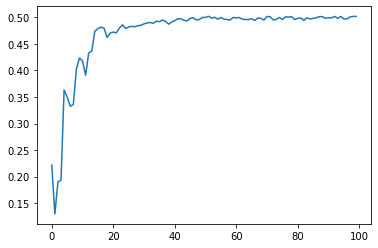

In [217]:
plt.plot(full['d_mat'].T[0])

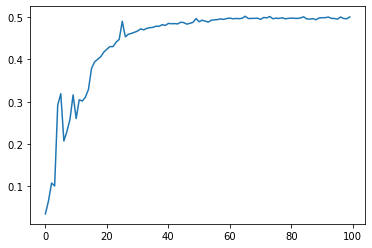

In [218]:
plt.plot(full['d_mat'].T[99])

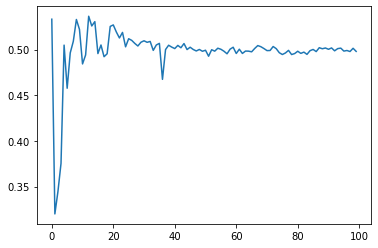

In [221]:
plt.plot(full['d_mat'].T[0])

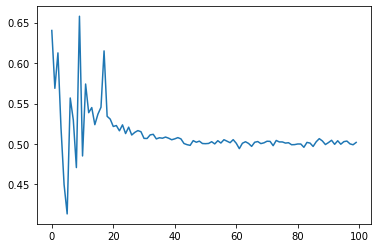

In [223]:
plt.plot(full['d_mat'].T[40])

(array([2., 1., 2., 7., 2., 4., 5., 5., 1., 1.]),
 array([0.49598  , 0.4970467, 0.4981134, 0.4991801, 0.5002468, 0.5013135,
        0.5023802, 0.5034469, 0.5045136, 0.5055803, 0.506647 ]),
 <BarContainer object of 10 artists>)

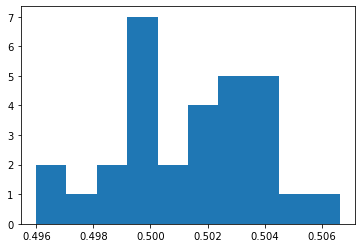

In [228]:
plt.hist(full['d_mat'].T[40][-30:])

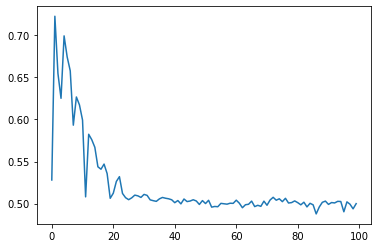

In [224]:
plt.plot(full['d_mat'].T[65])

(array([1., 1., 0., 1., 2., 5., 8., 7., 2., 3.]),
 array([0.487639 , 0.4896156, 0.4915922, 0.4935688, 0.4955454, 0.497522 ,
        0.4994986, 0.5014752, 0.5034518, 0.5054284, 0.507405 ]),
 <BarContainer object of 10 artists>)

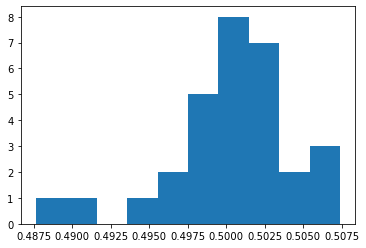

In [227]:
plt.hist(full['d_mat'].T[65][-30:])

### testing with 300 Gibbs iterations

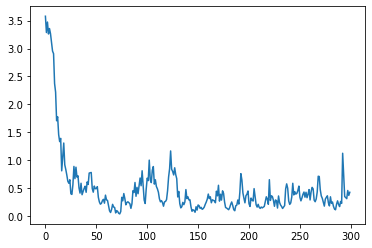

In [235]:
# alpha convergence plot
plt.plot(full['alpha_mat'])

(array([27., 26., 24., 15.,  3.,  3.,  1.,  0.,  0.,  1.]),
 array([0.112226 , 0.2134714, 0.3147168, 0.4159622, 0.5172076, 0.618453 ,
        0.7196984, 0.8209438, 0.9221892, 1.0234346, 1.12468  ]),
 <BarContainer object of 10 artists>)

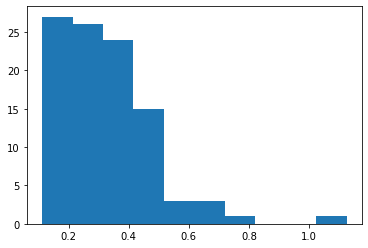

In [239]:
# alpha histogram
plt.hist(full['alpha_mat'][-100:])

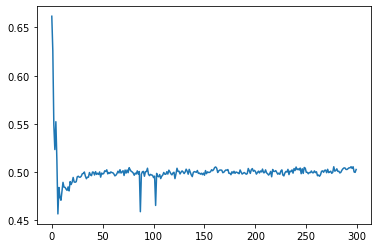

In [240]:
# d_bar (0-th entry) convergence
plt.plot(full['d_mat'].T[0])

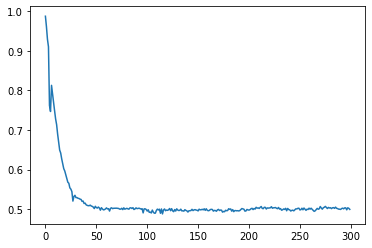

In [274]:
# d_bar (last entry) convergence
plt.plot(full['d_mat'].T[99])

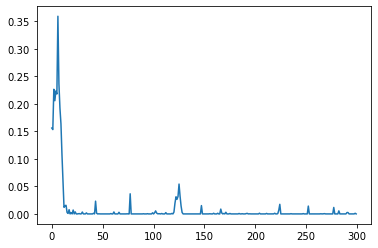

In [242]:
# W[0] convergence
plt.plot(np.array(full['W_mat']).T[0])

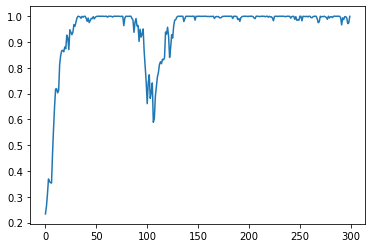

In [244]:
# W[1] convergence
plt.plot(np.array(full['W_mat']).T[1])

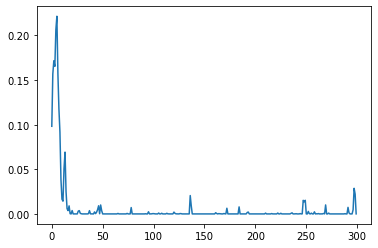

In [245]:
# W[2] convergence
plt.plot(np.array(full['W_mat']).T[2])

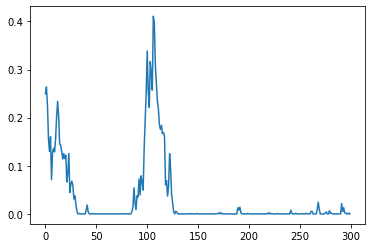

In [246]:
# W[3] convergence
plt.plot(np.array(full['W_mat']).T[3])

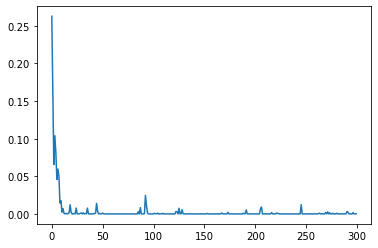

In [247]:
# W[4] convergence
plt.plot(np.array(full['W_mat']).T[4])

In [248]:
# Final H
full['H_mat'][299]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [253]:
full['H_mat'][5]

array([0, 1, 3, 4, 3, 0, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 4, 0, 0, 1, 1, 2,
       4, 4, 1, 2, 1, 0, 1, 0, 1, 0, 1, 4, 0, 1, 1, 3, 3, 1, 0, 0, 2, 1,
       2, 1, 2, 0, 1, 0, 1, 0, 0, 3, 0, 2, 3, 1, 0, 2, 0, 2, 1, 1, 1, 2,
       0, 0, 1, 0, 2, 3, 4, 2, 1, 0, 0, 3, 0, 0, 3, 1, 1, 4, 2, 1, 1, 2,
       0, 3, 1, 4, 1, 0, 2, 0, 0, 3, 1, 1])

In [254]:
full['H_mat'][20]

array([1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1])

In [251]:
full['H_mat'][150]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

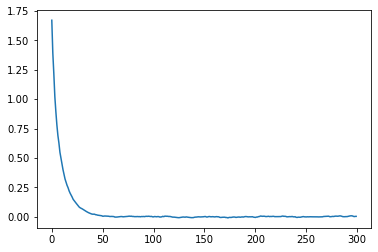

In [264]:
# B[1][0] convergence
plt.plot([l[1][0] for l in full['B_mat']])

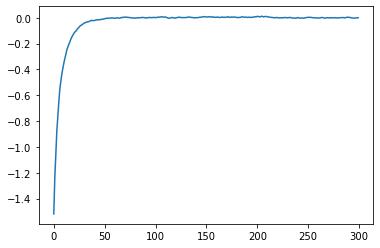

In [275]:
# B[1][1] convergence
plt.plot([l[1][1] for l in full['B_mat']])

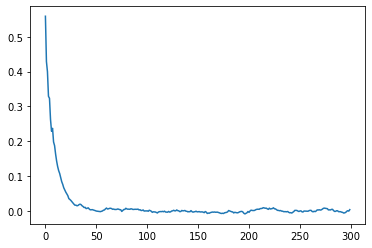

In [276]:
# B[1][2] convergence
plt.plot([l[1][2] for l in full['B_mat']])

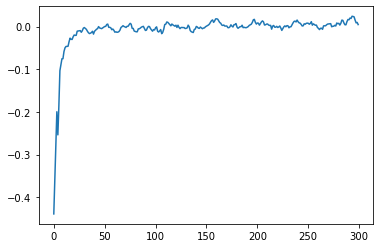

In [277]:
# B[1][3] convergence
plt.plot([l[1][3] for l in full['B_mat']])

(array([ 4.,  6., 13., 27., 18., 14.,  7.,  6.,  2.,  3.]),
 array([-0.00902888, -0.00571092, -0.00239296,  0.00092499,  0.00424295,
         0.00756091,  0.01087887,  0.01419683,  0.01751478,  0.02083274,
         0.0241507 ]),
 <BarContainer object of 10 artists>)

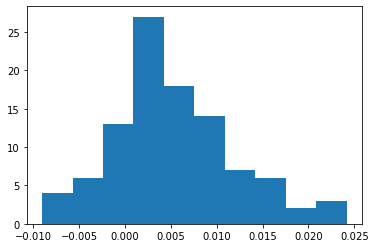

In [278]:
plt.hist([l[1][3] for l in full['B_mat'][-100:]])

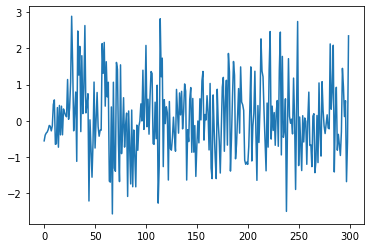

In [265]:
# B[4][0] convergence
plt.plot([l[4][0] for l in full['B_mat']])

(array([ 2.,  4.,  3., 18., 18., 17., 15., 13.,  6.,  4.]),
 array([-5.629810e-03, -4.239859e-03, -2.849908e-03, -1.459957e-03,
        -7.000600e-05,  1.319945e-03,  2.709896e-03,  4.099847e-03,
         5.489798e-03,  6.879749e-03,  8.269700e-03]),
 <BarContainer object of 10 artists>)

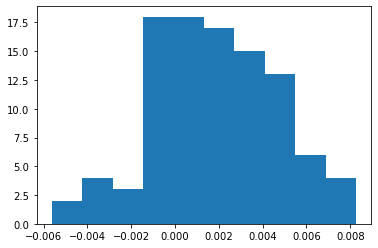

In [262]:
# B[0][0] histogram
plt.hist([l[1][0] for l in full['B_mat']][-100:])

(array([14., 19., 28., 17.,  7.,  4.,  1.,  3.,  4.,  3.]),
 array([-0.00322301, -0.00168709, -0.00015117,  0.00138475,  0.00292067,
         0.00445659,  0.00599252,  0.00752844,  0.00906436,  0.01060028,
         0.0121362 ]),
 <BarContainer object of 10 artists>)

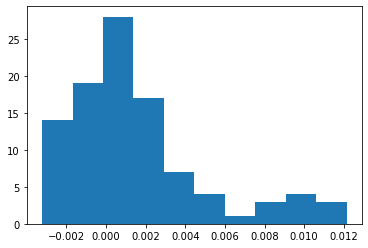

In [263]:
plt.hist([l[1][1] for l in full['B_mat']][-100:])

In [258]:
np.array(full['B_mat'])

array([[[-3.23551000e-02, -4.78385000e-02, -1.93265000e-01,
         -8.16168000e-01],
        [ 1.67193000e+00, -1.51842000e+00,  5.58876000e-01,
         -4.39286000e-01],
        [ 4.22669000e-01, -1.30017000e+00,  6.28028000e-01,
         -4.65846000e-01],
        [ 8.76566000e-01, -1.19165000e-01,  1.85374000e-01,
          9.73367000e-01],
        [-5.50657000e-01,  2.41981000e-01, -5.29412000e-01,
          9.75032000e-03]],

       [[-2.06073000e-02, -6.98977000e-02, -2.05680000e-01,
         -7.01645000e-01],
        [ 1.39324000e+00, -1.23681000e+00,  4.28593000e-01,
         -3.61133000e-01],
        [ 6.67722000e-02, -8.22330000e-01,  7.10966000e-01,
         -5.27815000e-01],
        [ 7.73851000e-01, -1.28643000e-01,  2.04847000e-01,
          7.25232000e-01],
        [-3.93691000e-01,  1.49458000e-01, -4.74377000e-01,
          2.77179000e-01]],

       [[ 1.42540000e-02, -7.54551000e-02, -2.39298000e-01,
         -5.10351000e-01],
        [ 1.21678000e+00, -1.05188000e+

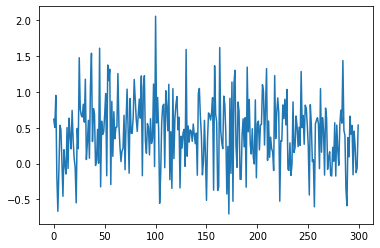

In [269]:
# mu_0[0] convergence
plt.plot(np.array(full['mu_0_mat']).T[0])

(array([ 4.,  1., 15., 14., 16., 23., 16.,  4.,  4.,  3.]),
 array([-0.60346612, -0.39943013, -0.19539414,  0.00864185,  0.21267784,
         0.41671383,  0.62074982,  0.82478581,  1.0288218 ,  1.23285779,
         1.43689378]),
 <BarContainer object of 10 artists>)

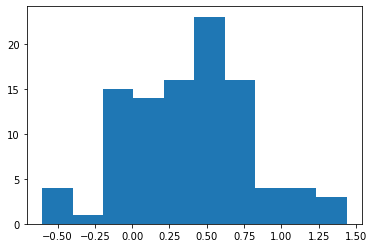

In [271]:
# mu_0[0] histogram
plt.hist(np.array(full['mu_0_mat']).T[0][-100:])

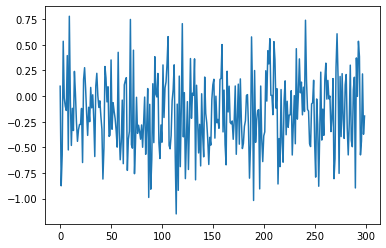

In [272]:
# mu_1[0] convergence
plt.plot(np.array(full['mu_1_mat']).T[0])

(array([ 6.,  6., 11., 13., 13., 19., 17.,  8.,  5.,  2.]),
 array([-0.89581266, -0.73222824, -0.56864383, -0.40505942, -0.24147501,
        -0.0778906 ,  0.08569381,  0.24927822,  0.41286263,  0.57644704,
         0.74003145]),
 <BarContainer object of 10 artists>)

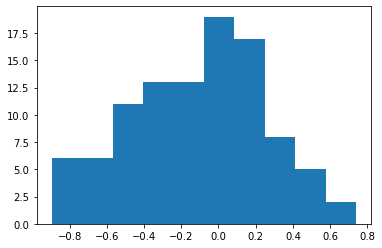

In [273]:
# mu_1[0] histogram
plt.hist(np.array(full['mu_1_mat']).T[0][-100:])

# Truth testing

In [58]:
# given this setup, PCE estimate should be 10*d_obs for each patient

def f0_true(x, d0):
    out = np.dot(x, x) - 5*d0
    return out

def f1_true(x, d1):
    out = np.dot(x, x) + 5*d1
    return out

d_bar_true = d_obs

In [59]:
X_now = create_X_full(X_start, d_bar_true)
Y_true = np.array([f0_true(x = X_now[j][:3], d0 = X_now[j][3]) if ind_vec[j] == 0 
                   else f1_true(x = X_now[j][:3], d1 = X_now[j][4]) for j in range(n)])

In [60]:
Y_true

array([-3.99370393, -0.87598007,  3.64586695,  3.83685329,  5.37232261,
        9.66409935,  2.81709978,  5.02546701,  5.73071881,  0.30305528,
        5.66178764,  0.41024392,  1.6831763 , -0.53188729,  8.08280565,
       -2.1127235 ,  5.04960685,  6.4707477 ,  0.54486734,  4.90313295,
        4.02405174, -2.63916783,  0.94271864,  1.83896142,  1.95044386,
       -2.32060152,  1.50015424,  1.03121226,  1.37848807, -2.70992169,
        2.17513966,  0.776452  ,  2.57818455,  1.39177479,  4.05001168,
        1.61688838,  1.31930447, -0.63327493,  1.81155637,  2.57481708,
        2.55212701,  2.92286689,  4.0943621 ,  2.50730265,  9.36838518,
        6.26655508,  0.96656561,  2.36396895,  2.26012062,  1.03062929,
       -1.80543934,  0.63835525,  4.09973237, -0.89439749,  7.63441756,
        5.21553282, -3.46302275,  3.24335944,  2.90742246, -1.55679248,
        2.21281345, -0.70061119, -1.15403593,  0.79253849,  1.84223854,
        1.16808082,  0.37842765,  7.15589832, -0.12683472,  2.71

In [61]:
test_Gibbs_full = update_all(n_iter = 150, X_start = X_start, Y = Y_true, ind_vec = ind_vec, N = 5, nu_0 = 100)

11:26:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:22 - cmdstanpy - INFO - CmdStan done processing.
11:26:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:31 - cmdstanpy - INFO - CmdStan done processing.


11:26:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:33 - cmdstanpy - INFO - CmdStan done processing.


11:26:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:33 - cmdstanpy - INFO - CmdStan done processing.
11:26:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:26:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:34 - cmdstanpy - INFO - CmdStan done processing.
11:26:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:26:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:35 - cmdstanpy - INFO - CmdStan done processing.
11:26:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:26:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:36 - cmdstanpy - INFO - CmdStan done processing.
11:26:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:26:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:37 - cmdstanpy - INFO - CmdStan done processing.
11:26:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:26:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:48 - cmdstanpy - INFO - CmdStan done processing.
11:26:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:53 - cmdstanpy - INFO - CmdStan done processing.


11:26:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:55 - cmdstanpy - INFO - CmdStan done processing.


11:26:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:56 - cmdstanpy - INFO - CmdStan done processing.
11:26:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:26:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:57 - cmdstanpy - INFO - CmdStan done processing.
11:26:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:26:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:57 - cmdstanpy - INFO - CmdStan done processing.
11:26:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:26:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:58 - cmdstanpy - INFO - CmdStan done processing.
11:26:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:26:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:26:59 - cmdstanpy - INFO - CmdStan done processing.
11:26:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:26:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:10 - cmdstanpy - INFO - CmdStan done processing.
11:27:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:16 - cmdstanpy - INFO - CmdStan done processing.


11:27:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:18 - cmdstanpy - INFO - CmdStan done processing.


11:27:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:19 - cmdstanpy - INFO - CmdStan done processing.
11:27:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:27:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:20 - cmdstanpy - INFO - CmdStan done processing.
11:27:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:27:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:20 - cmdstanpy - INFO - CmdStan done processing.
11:27:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:27:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:21 - cmdstanpy - INFO - CmdStan done processing.
11:27:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:27:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:22 - cmdstanpy - INFO - CmdStan done processing.
11:27:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:27:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:31 - cmdstanpy - INFO - CmdStan done processing.
11:27:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:37 - cmdstanpy - INFO - CmdStan done processing.


11:27:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:39 - cmdstanpy - INFO - CmdStan done processing.


11:27:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:39 - cmdstanpy - INFO - CmdStan done processing.
11:27:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:27:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:40 - cmdstanpy - INFO - CmdStan done processing.
11:27:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:27:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:41 - cmdstanpy - INFO - CmdStan done processing.
11:27:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:27:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:41 - cmdstanpy - INFO - CmdStan done processing.
11:27:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:27:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:42 - cmdstanpy - INFO - CmdStan done processing.
11:27:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:27:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:49 - cmdstanpy - INFO - CmdStan done processing.
11:27:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:54 - cmdstanpy - INFO - CmdStan done processing.


11:27:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:56 - cmdstanpy - INFO - CmdStan done processing.


11:27:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:57 - cmdstanpy - INFO - CmdStan done processing.
11:27:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line

11:27:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:58 - cmdstanpy - INFO - CmdStan done processing.
11:27:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:27:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:58 - cmdstanpy - INFO - CmdStan done processing.
11:27:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:27:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:27:59 - cmdstanpy - INFO - CmdStan done processing.
11:27:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:27:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:00 - cmdstanpy - INFO - CmdStan done processing.
11:28:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:28:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:10 - cmdstanpy - INFO - CmdStan done processing.
11:28:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:18 - cmdstanpy - INFO - CmdStan done processing.


11:28:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:20 - cmdstanpy - INFO - CmdStan done processing.


11:28:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:20 - cmdstanpy - INFO - CmdStan done processing.
11:28:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:28:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:21 - cmdstanpy - INFO - CmdStan done processing.
11:28:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line

11:28:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:22 - cmdstanpy - INFO - CmdStan done processing.
11:28:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:28:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:22 - cmdstanpy - INFO - CmdStan done processing.
11:28:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:28:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:23 - cmdstanpy - INFO - CmdStan done processing.
11:28:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

11:28:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:33 - cmdstanpy - INFO - CmdStan done processing.
11:28:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:39 - cmdstanpy - INFO - CmdStan done processing.


11:28:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:41 - cmdstanpy - INFO - CmdStan done processing.


11:28:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:41 - cmdstanpy - INFO - CmdStan done processing.
11:28:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:28:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:42 - cmdstanpy - INFO - CmdStan done processing.
11:28:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:28:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:43 - cmdstanpy - INFO - CmdStan done processing.
11:28:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:28:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:44 - cmdstanpy - INFO - CmdStan done processing.
11:28:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:28:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:44 - cmdstanpy - INFO - CmdStan done processing.
11:28:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:28:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:55 - cmdstanpy - INFO - CmdStan done processing.
11:28:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:01 - cmdstanpy - INFO - CmdStan done processing.


11:29:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:03 - cmdstanpy - INFO - CmdStan done processing.


11:29:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:03 - cmdstanpy - INFO - CmdStan done processing.
11:29:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:29:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:04 - cmdstanpy - INFO - CmdStan done processing.
11:29:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:29:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:05 - cmdstanpy - INFO - CmdStan done processing.
11:29:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:29:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:05 - cmdstanpy - INFO - CmdStan done processing.
11:29:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:29:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:06 - cmdstanpy - INFO - CmdStan done processing.
11:29:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:29:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:16 - cmdstanpy - INFO - CmdStan done processing.
11:29:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:23 - cmdstanpy - INFO - CmdStan done processing.


11:29:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:25 - cmdstanpy - INFO - CmdStan done processing.


11:29:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:26 - cmdstanpy - INFO - CmdStan done processing.
11:29:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:29:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:27 - cmdstanpy - INFO - CmdStan done processing.
11:29:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:29:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:28 - cmdstanpy - INFO - CmdStan done processing.
11:29:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:29:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:28 - cmdstanpy - INFO - CmdStan done processing.
11:29:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:29:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:29 - cmdstanpy - INFO - CmdStan done processing.
11:29:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:29:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:41 - cmdstanpy - INFO - CmdStan done processing.
11:29:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:48 - cmdstanpy - INFO - CmdStan done processing.


11:29:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:50 - cmdstanpy - INFO - CmdStan done processing.


11:29:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:51 - cmdstanpy - INFO - CmdStan done processing.
11:29:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:29:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:51 - cmdstanpy - INFO - CmdStan done processing.
11:29:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:29:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:52 - cmdstanpy - INFO - CmdStan done processing.
11:29:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:29:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:53 - cmdstanpy - INFO - CmdStan done processing.
11:29:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:29:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:54 - cmdstanpy - INFO - CmdStan done processing.
11:29:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:29:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:05 - cmdstanpy - INFO - CmdStan done processing.
11:30:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:11 - cmdstanpy - INFO - CmdStan done processing.


11:30:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:13 - cmdstanpy - INFO - CmdStan done processing.


11:30:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:13 - cmdstanpy - INFO - CmdStan done processing.
11:30:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:30:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:14 - cmdstanpy - INFO - CmdStan done processing.
11:30:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

11:30:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:15 - cmdstanpy - INFO - CmdStan done processing.
11:30:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:30:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:16 - cmdstanpy - INFO - CmdStan done processing.
11:30:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

11:30:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:16 - cmdstanpy - INFO - CmdStan done processing.
11:30:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:30:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:28 - cmdstanpy - INFO - CmdStan done processing.
11:30:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:34 - cmdstanpy - INFO - CmdStan done processing.


11:30:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:36 - cmdstanpy - INFO - CmdStan done processing.


11:30:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:36 - cmdstanpy - INFO - CmdStan done processing.
11:30:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:30:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:37 - cmdstanpy - INFO - CmdStan done processing.
11:30:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:30:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:38 - cmdstanpy - INFO - CmdStan done processing.
11:30:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:30:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:39 - cmdstanpy - INFO - CmdStan done processing.
11:30:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:30:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:30:39 - cmdstanpy - INFO - CmdStan done processing.
11:30:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:30:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:00 - cmdstanpy - INFO - CmdStan done processing.
11:31:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:05 - cmdstanpy - INFO - CmdStan done processing.


11:31:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:07 - cmdstanpy - INFO - CmdStan done processing.


11:31:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:08 - cmdstanpy - INFO - CmdStan done processing.
11:31:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:31:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:09 - cmdstanpy - INFO - CmdStan done processing.
11:31:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:31:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:10 - cmdstanpy - INFO - CmdStan done processing.
11:31:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:31:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:10 - cmdstanpy - INFO - CmdStan done processing.
11:31:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:31:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:11 - cmdstanpy - INFO - CmdStan done processing.
11:31:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:31:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:21 - cmdstanpy - INFO - CmdStan done processing.
11:31:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:26 - cmdstanpy - INFO - CmdStan done processing.


11:31:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:28 - cmdstanpy - INFO - CmdStan done processing.


11:31:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:29 - cmdstanpy - INFO - CmdStan done processing.
11:31:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:31:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:30 - cmdstanpy - INFO - CmdStan done processing.
11:31:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:31:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:31 - cmdstanpy - INFO - CmdStan done processing.
11:31:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:31:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:31 - cmdstanpy - INFO - CmdStan done processing.
11:31:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:31:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:32 - cmdstanpy - INFO - CmdStan done processing.
11:31:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:31:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:41 - cmdstanpy - INFO - CmdStan done processing.
11:31:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:47 - cmdstanpy - INFO - CmdStan done processing.


11:31:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:49 - cmdstanpy - INFO - CmdStan done processing.


11:31:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:49 - cmdstanpy - INFO - CmdStan done processing.
11:31:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:31:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:50 - cmdstanpy - INFO - CmdStan done processing.
11:31:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:31:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:51 - cmdstanpy - INFO - CmdStan done processing.
11:31:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:31:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:52 - cmdstanpy - INFO - CmdStan done processing.
11:31:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:31:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:31:52 - cmdstanpy - INFO - CmdStan done processing.
11:31:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:31:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:02 - cmdstanpy - INFO - CmdStan done processing.
11:32:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:07 - cmdstanpy - INFO - CmdStan done processing.


11:32:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:09 - cmdstanpy - INFO - CmdStan done processing.


11:32:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:09 - cmdstanpy - INFO - CmdStan done processing.
11:32:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:32:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:10 - cmdstanpy - INFO - CmdStan done processing.
11:32:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:32:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:11 - cmdstanpy - INFO - CmdStan done processing.
11:32:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:32:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:12 - cmdstanpy - INFO - CmdStan done processing.
11:32:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:32:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:13 - cmdstanpy - INFO - CmdStan done processing.
11:32:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:32:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:22 - cmdstanpy - INFO - CmdStan done processing.
11:32:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:27 - cmdstanpy - INFO - CmdStan done processing.


11:32:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:29 - cmdstanpy - INFO - CmdStan done processing.


11:32:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:30 - cmdstanpy - INFO - CmdStan done processing.
11:32:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:32:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:31 - cmdstanpy - INFO - CmdStan done processing.
11:32:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:32:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:31 - cmdstanpy - INFO - CmdStan done processing.
11:32:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:32:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:32 - cmdstanpy - INFO - CmdStan done processing.
11:32:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:32:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:33 - cmdstanpy - INFO - CmdStan done processing.
11:32:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:32:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:43 - cmdstanpy - INFO - CmdStan done processing.
11:32:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:48 - cmdstanpy - INFO - CmdStan done processing.


11:32:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:50 - cmdstanpy - INFO - CmdStan done processing.


11:32:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:50 - cmdstanpy - INFO - CmdStan done processing.
11:32:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:32:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:51 - cmdstanpy - INFO - CmdStan done processing.
11:32:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

11:32:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:52 - cmdstanpy - INFO - CmdStan done processing.
11:32:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:32:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:53 - cmdstanpy - INFO - CmdStan done processing.
11:32:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:32:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:53 - cmdstanpy - INFO - CmdStan done processing.
11:32:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:32:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:01 - cmdstanpy - INFO - CmdStan done processing.
11:33:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:09 - cmdstanpy - INFO - CmdStan done processing.


11:33:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:11 - cmdstanpy - INFO - CmdStan done processing.


11:33:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:11 - cmdstanpy - INFO - CmdStan done processing.
11:33:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:33:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:12 - cmdstanpy - INFO - CmdStan done processing.
11:33:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:33:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:13 - cmdstanpy - INFO - CmdStan done processing.
11:33:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:33:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:14 - cmdstanpy - INFO - CmdStan done processing.
11:33:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:33:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:14 - cmdstanpy - INFO - CmdStan done processing.
11:33:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


11:33:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:25 - cmdstanpy - INFO - CmdStan done processing.
11:33:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:33 - cmdstanpy - INFO - CmdStan done processing.


11:33:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:35 - cmdstanpy - INFO - CmdStan done processing.


11:33:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:35 - cmdstanpy - INFO - CmdStan done processing.
11:33:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:33:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:36 - cmdstanpy - INFO - CmdStan done processing.
11:33:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:33:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:37 - cmdstanpy - INFO - CmdStan done processing.
11:33:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:33:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:38 - cmdstanpy - INFO - CmdStan done processing.
11:33:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:33:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:38 - cmdstanpy - INFO - CmdStan done processing.
11:33:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:33:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:45 - cmdstanpy - INFO - CmdStan done processing.
11:33:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:51 - cmdstanpy - INFO - CmdStan done processing.


11:33:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:52 - cmdstanpy - INFO - CmdStan done processing.


11:33:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:54 - cmdstanpy - INFO - CmdStan done processing.
11:33:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:33:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:55 - cmdstanpy - INFO - CmdStan done processing.
11:33:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:33:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:33:55 - cmdstanpy - INFO - CmdStan done processing.
11:33:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:33:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:04 - cmdstanpy - INFO - CmdStan done processing.
11:34:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:10 - cmdstanpy - INFO - CmdStan done processing.


11:34:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:12 - cmdstanpy - INFO - CmdStan done processing.


11:34:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:13 - cmdstanpy - INFO - CmdStan done processing.
11:34:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:34:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:14 - cmdstanpy - INFO - CmdStan done processing.
11:34:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:34:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:15 - cmdstanpy - INFO - CmdStan done processing.
11:34:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:34:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:23 - cmdstanpy - INFO - CmdStan done processing.
11:34:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:30 - cmdstanpy - INFO - CmdStan done processing.


11:34:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:32 - cmdstanpy - INFO - CmdStan done processing.


11:34:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:33 - cmdstanpy - INFO - CmdStan done processing.
11:34:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:34:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:34 - cmdstanpy - INFO - CmdStan done processing.
11:34:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:34:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:34 - cmdstanpy - INFO - CmdStan done processing.
11:34:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:34:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:43 - cmdstanpy - INFO - CmdStan done processing.
11:34:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:49 - cmdstanpy - INFO - CmdStan done processing.


11:34:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:50 - cmdstanpy - INFO - CmdStan done processing.


11:34:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:52 - cmdstanpy - INFO - CmdStan done processing.
11:34:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:34:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:53 - cmdstanpy - INFO - CmdStan done processing.
11:34:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:34:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:34:53 - cmdstanpy - INFO - CmdStan done processing.
11:34:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


11:34:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:04 - cmdstanpy - INFO - CmdStan done processing.
11:35:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:09 - cmdstanpy - INFO - CmdStan done processing.


11:35:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:11 - cmdstanpy - INFO - CmdStan done processing.
11:35:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:35:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:13 - cmdstanpy - INFO - CmdStan done processing.
11:35:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:35:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:14 - cmdstanpy - INFO - CmdStan done processing.
11:35:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:35:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:25 - cmdstanpy - INFO - CmdStan done processing.
11:35:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:30 - cmdstanpy - INFO - CmdStan done processing.


11:35:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:32 - cmdstanpy - INFO - CmdStan done processing.


11:35:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:34 - cmdstanpy - INFO - CmdStan done processing.
11:35:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:35:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:34 - cmdstanpy - INFO - CmdStan done processing.
11:35:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:35:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:44 - cmdstanpy - INFO - CmdStan done processing.
11:35:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:52 - cmdstanpy - INFO - CmdStan done processing.


11:35:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:54 - cmdstanpy - INFO - CmdStan done processing.


11:35:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:56 - cmdstanpy - INFO - CmdStan done processing.
11:35:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:35:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:56 - cmdstanpy - INFO - CmdStan done processing.
11:35:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:35:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:04 - cmdstanpy - INFO - CmdStan done processing.
11:36:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:09 - cmdstanpy - INFO - CmdStan done processing.


11:36:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:11 - cmdstanpy - INFO - CmdStan done processing.
11:36:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:36:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:13 - cmdstanpy - INFO - CmdStan done processing.
11:36:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:36:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:13 - cmdstanpy - INFO - CmdStan done processing.
11:36:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:36:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:23 - cmdstanpy - INFO - CmdStan done processing.
11:36:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:30 - cmdstanpy - INFO - CmdStan done processing.


11:36:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:32 - cmdstanpy - INFO - CmdStan done processing.


11:36:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:33 - cmdstanpy - INFO - CmdStan done processing.
11:36:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:36:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:34 - cmdstanpy - INFO - CmdStan done processing.
11:36:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:36:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:43 - cmdstanpy - INFO - CmdStan done processing.
11:36:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:49 - cmdstanpy - INFO - CmdStan done processing.


11:36:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:51 - cmdstanpy - INFO - CmdStan done processing.
11:36:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:36:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:53 - cmdstanpy - INFO - CmdStan done processing.
11:36:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:36:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:36:53 - cmdstanpy - INFO - CmdStan done processing.
11:36:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line

11:36:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:01 - cmdstanpy - INFO - CmdStan done processing.
11:37:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:08 - cmdstanpy - INFO - CmdStan done processing.


11:37:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:10 - cmdstanpy - INFO - CmdStan done processing.
11:37:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:37:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:11 - cmdstanpy - INFO - CmdStan done processing.
11:37:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:37:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:12 - cmdstanpy - INFO - CmdStan done processing.
11:37:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:37:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:21 - cmdstanpy - INFO - CmdStan done processing.
11:37:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:28 - cmdstanpy - INFO - CmdStan done processing.


11:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:30 - cmdstanpy - INFO - CmdStan done processing.
11:37:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:37:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:32 - cmdstanpy - INFO - CmdStan done processing.
11:37:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:37:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:33 - cmdstanpy - INFO - CmdStan done processing.
11:37:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:37:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:42 - cmdstanpy - INFO - CmdStan done processing.
11:37:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:48 - cmdstanpy - INFO - CmdStan done processing.


11:37:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:50 - cmdstanpy - INFO - CmdStan done processing.


11:37:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:51 - cmdstanpy - INFO - CmdStan done processing.
11:37:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:37:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:52 - cmdstanpy - INFO - CmdStan done processing.
11:37:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:37:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:37:59 - cmdstanpy - INFO - CmdStan done processing.
11:37:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:05 - cmdstanpy - INFO - CmdStan done processing.


11:38:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:06 - cmdstanpy - INFO - CmdStan done processing.


11:38:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:08 - cmdstanpy - INFO - CmdStan done processing.
11:38:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:38:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:09 - cmdstanpy - INFO - CmdStan done processing.
11:38:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:38:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:19 - cmdstanpy - INFO - CmdStan done processing.
11:38:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:26 - cmdstanpy - INFO - CmdStan done processing.


11:38:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:28 - cmdstanpy - INFO - CmdStan done processing.
11:38:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:38:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:29 - cmdstanpy - INFO - CmdStan done processing.
11:38:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:38:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:30 - cmdstanpy - INFO - CmdStan done processing.
11:38:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:38:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:38 - cmdstanpy - INFO - CmdStan done processing.
11:38:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:44 - cmdstanpy - INFO - CmdStan done processing.


11:38:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:46 - cmdstanpy - INFO - CmdStan done processing.
11:38:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:38:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:48 - cmdstanpy - INFO - CmdStan done processing.
11:38:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:38:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:38:57 - cmdstanpy - INFO - CmdStan done processing.
11:38:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:39:02 - cmdstanpy - INFO - CmdStan done processing.


11:39:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:39:04 - cmdstanpy - INFO - CmdStan done processing.
11:39:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:39:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:39:06 - cmdstanpy - INFO - CmdStan done processing.
11:39:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:39:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:39:14 - cmdstanpy - INFO - CmdStan done processing.
11:39:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:39:20 - cmdstanpy - INFO - CmdStan done processing.


11:39:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:39:22 - cmdstanpy - INFO - CmdStan done processing.
11:39:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:39:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:39:24 - cmdstanpy - INFO - CmdStan done processing.
11:39:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:39:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:39:33 - cmdstanpy - INFO - CmdStan done processing.
11:39:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:39:38 - cmdstanpy - INFO - CmdStan done processing.


11:39:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:39:40 - cmdstanpy - INFO - CmdStan done processing.
11:39:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:39:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:39:42 - cmdstanpy - INFO - CmdStan done processing.
11:39:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:39:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:39:51 - cmdstanpy - INFO - CmdStan done processing.
11:39:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:39:56 - cmdstanpy - INFO - CmdStan done processing.


11:39:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:39:58 - cmdstanpy - INFO - CmdStan done processing.


11:39:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:40:00 - cmdstanpy - INFO - CmdStan done processing.
11:40:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:40:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:40:09 - cmdstanpy - INFO - CmdStan done processing.
11:40:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:40:14 - cmdstanpy - INFO - CmdStan done processing.


11:40:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:40:16 - cmdstanpy - INFO - CmdStan done processing.


11:40:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:40:18 - cmdstanpy - INFO - CmdStan done processing.
11:40:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:40:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:40:27 - cmdstanpy - INFO - CmdStan done processing.
11:40:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:40:33 - cmdstanpy - INFO - CmdStan done processing.


11:40:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:40:35 - cmdstanpy - INFO - CmdStan done processing.


11:40:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:40:37 - cmdstanpy - INFO - CmdStan done processing.
11:40:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:40:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:40:46 - cmdstanpy - INFO - CmdStan done processing.
11:40:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:40:54 - cmdstanpy - INFO - CmdStan done processing.


11:40:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:40:56 - cmdstanpy - INFO - CmdStan done processing.
11:40:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:40:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:40:57 - cmdstanpy - INFO - CmdStan done processing.
11:40:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

11:40:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:41:05 - cmdstanpy - INFO - CmdStan done processing.
11:41:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:41:10 - cmdstanpy - INFO - CmdStan done processing.


11:41:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:41:12 - cmdstanpy - INFO - CmdStan done processing.
11:41:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:41:14 - cmdstanpy - INFO - CmdStan done processing.
11:41:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:41:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:41:23 - cmdstanpy - INFO - CmdStan done processing.
11:41:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:41:29 - cmdstanpy - INFO - CmdStan done processing.


11:41:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:41:31 - cmdstanpy - INFO - CmdStan done processing.
11:41:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:41:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:41:33 - cmdstanpy - INFO - CmdStan done processing.
11:41:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

11:41:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:41:43 - cmdstanpy - INFO - CmdStan done processing.
11:41:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:41:48 - cmdstanpy - INFO - CmdStan done processing.


11:41:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:41:50 - cmdstanpy - INFO - CmdStan done processing.


11:41:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:41:52 - cmdstanpy - INFO - CmdStan done processing.
11:41:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:41:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:42:01 - cmdstanpy - INFO - CmdStan done processing.
11:42:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:42:07 - cmdstanpy - INFO - CmdStan done processing.


11:42:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:42:09 - cmdstanpy - INFO - CmdStan done processing.
11:42:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:42:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:42:11 - cmdstanpy - INFO - CmdStan done processing.
11:42:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:42:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:42:19 - cmdstanpy - INFO - CmdStan done processing.
11:42:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:42:26 - cmdstanpy - INFO - CmdStan done processing.


11:42:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:42:27 - cmdstanpy - INFO - CmdStan done processing.
11:42:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:42:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:42:29 - cmdstanpy - INFO - CmdStan done processing.
11:42:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:42:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:42:40 - cmdstanpy - INFO - CmdStan done processing.
11:42:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:42:45 - cmdstanpy - INFO - CmdStan done processing.


11:42:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:42:47 - cmdstanpy - INFO - CmdStan done processing.
11:42:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:42:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:42:49 - cmdstanpy - INFO - CmdStan done processing.
11:42:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:42:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:42:59 - cmdstanpy - INFO - CmdStan done processing.
11:42:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:43:05 - cmdstanpy - INFO - CmdStan done processing.


11:43:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:43:07 - cmdstanpy - INFO - CmdStan done processing.
11:43:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:43:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:43:09 - cmdstanpy - INFO - CmdStan done processing.
11:43:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:43:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:43:18 - cmdstanpy - INFO - CmdStan done processing.
11:43:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:43:24 - cmdstanpy - INFO - CmdStan done processing.


11:43:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:43:26 - cmdstanpy - INFO - CmdStan done processing.
11:43:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:43:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:43:27 - cmdstanpy - INFO - CmdStan done processing.
11:43:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:43:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:43:37 - cmdstanpy - INFO - CmdStan done processing.
11:43:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:43:43 - cmdstanpy - INFO - CmdStan done processing.


11:43:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:43:45 - cmdstanpy - INFO - CmdStan done processing.
11:43:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:43:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:43:47 - cmdstanpy - INFO - CmdStan done processing.
11:43:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:43:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:43:56 - cmdstanpy - INFO - CmdStan done processing.
11:43:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:01 - cmdstanpy - INFO - CmdStan done processing.


11:44:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:03 - cmdstanpy - INFO - CmdStan done processing.
11:44:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:44:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:05 - cmdstanpy - INFO - CmdStan done processing.
11:44:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:44:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:15 - cmdstanpy - INFO - CmdStan done processing.
11:44:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:22 - cmdstanpy - INFO - CmdStan done processing.


11:44:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:24 - cmdstanpy - INFO - CmdStan done processing.
11:44:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:44:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:26 - cmdstanpy - INFO - CmdStan done processing.
11:44:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:44:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:35 - cmdstanpy - INFO - CmdStan done processing.
11:44:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:41 - cmdstanpy - INFO - CmdStan done processing.


11:44:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:43 - cmdstanpy - INFO - CmdStan done processing.
11:44:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:44:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:44 - cmdstanpy - INFO - CmdStan done processing.
11:44:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:44:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:52 - cmdstanpy - INFO - CmdStan done processing.
11:44:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:57 - cmdstanpy - INFO - CmdStan done processing.


11:44:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:59 - cmdstanpy - INFO - CmdStan done processing.
11:44:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:44:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:45:01 - cmdstanpy - INFO - CmdStan done processing.
11:45:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:45:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:45:11 - cmdstanpy - INFO - CmdStan done processing.
11:45:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:45:17 - cmdstanpy - INFO - CmdStan done processing.


11:45:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:45:19 - cmdstanpy - INFO - CmdStan done processing.
11:45:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:45:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:45:21 - cmdstanpy - INFO - CmdStan done processing.
11:45:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:45:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:45:29 - cmdstanpy - INFO - CmdStan done processing.
11:45:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:45:35 - cmdstanpy - INFO - CmdStan done processing.


11:45:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:45:37 - cmdstanpy - INFO - CmdStan done processing.
11:45:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:45:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:45:38 - cmdstanpy - INFO - CmdStan done processing.
11:45:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:45:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:45:49 - cmdstanpy - INFO - CmdStan done processing.
11:45:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:45:56 - cmdstanpy - INFO - CmdStan done processing.


11:45:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:45:58 - cmdstanpy - INFO - CmdStan done processing.
11:45:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:45:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:46:00 - cmdstanpy - INFO - CmdStan done processing.
11:46:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:46:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:46:08 - cmdstanpy - INFO - CmdStan done processing.
11:46:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:46:14 - cmdstanpy - INFO - CmdStan done processing.


11:46:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:46:16 - cmdstanpy - INFO - CmdStan done processing.
11:46:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:46:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:46:18 - cmdstanpy - INFO - CmdStan done processing.
11:46:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:46:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:46:26 - cmdstanpy - INFO - CmdStan done processing.
11:46:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:46:33 - cmdstanpy - INFO - CmdStan done processing.


11:46:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:46:35 - cmdstanpy - INFO - CmdStan done processing.
11:46:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:46:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:46:36 - cmdstanpy - INFO - CmdStan done processing.
11:46:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:46:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:46:47 - cmdstanpy - INFO - CmdStan done processing.
11:46:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:46:53 - cmdstanpy - INFO - CmdStan done processing.


11:46:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:46:54 - cmdstanpy - INFO - CmdStan done processing.
11:46:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:46:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:46:56 - cmdstanpy - INFO - CmdStan done processing.
11:46:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:46:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:47:08 - cmdstanpy - INFO - CmdStan done processing.
11:47:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:47:13 - cmdstanpy - INFO - CmdStan done processing.


11:47:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:47:15 - cmdstanpy - INFO - CmdStan done processing.


11:47:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:47:17 - cmdstanpy - INFO - CmdStan done processing.
11:47:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:47:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:47:27 - cmdstanpy - INFO - CmdStan done processing.
11:47:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:47:33 - cmdstanpy - INFO - CmdStan done processing.


11:47:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:47:35 - cmdstanpy - INFO - CmdStan done processing.


11:47:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:47:37 - cmdstanpy - INFO - CmdStan done processing.
11:47:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:47:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:47:46 - cmdstanpy - INFO - CmdStan done processing.
11:47:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:47:52 - cmdstanpy - INFO - CmdStan done processing.


11:47:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:47:54 - cmdstanpy - INFO - CmdStan done processing.
11:47:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:47:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:47:55 - cmdstanpy - INFO - CmdStan done processing.
11:47:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:47:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:48:06 - cmdstanpy - INFO - CmdStan done processing.
11:48:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:48:11 - cmdstanpy - INFO - CmdStan done processing.


11:48:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:48:13 - cmdstanpy - INFO - CmdStan done processing.


11:48:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:48:15 - cmdstanpy - INFO - CmdStan done processing.
11:48:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:48:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:48:25 - cmdstanpy - INFO - CmdStan done processing.
11:48:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:48:31 - cmdstanpy - INFO - CmdStan done processing.


11:48:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:48:32 - cmdstanpy - INFO - CmdStan done processing.
11:48:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:48:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:48:34 - cmdstanpy - INFO - CmdStan done processing.
11:48:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:48:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:48:41 - cmdstanpy - INFO - CmdStan done processing.
11:48:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:48:47 - cmdstanpy - INFO - CmdStan done processing.


11:48:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:48:49 - cmdstanpy - INFO - CmdStan done processing.
11:48:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:48:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:48:51 - cmdstanpy - INFO - CmdStan done processing.
11:48:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:48:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:49:00 - cmdstanpy - INFO - CmdStan done processing.
11:49:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:49:05 - cmdstanpy - INFO - CmdStan done processing.


11:49:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:49:07 - cmdstanpy - INFO - CmdStan done processing.
11:49:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:49:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:49:09 - cmdstanpy - INFO - CmdStan done processing.
11:49:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:49:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:49:18 - cmdstanpy - INFO - CmdStan done processing.
11:49:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:49:24 - cmdstanpy - INFO - CmdStan done processing.


11:49:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:49:25 - cmdstanpy - INFO - CmdStan done processing.
11:49:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:49:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:49:27 - cmdstanpy - INFO - CmdStan done processing.
11:49:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:49:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:49:37 - cmdstanpy - INFO - CmdStan done processing.
11:49:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:49:42 - cmdstanpy - INFO - CmdStan done processing.


11:49:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:49:44 - cmdstanpy - INFO - CmdStan done processing.
11:49:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:49:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:49:46 - cmdstanpy - INFO - CmdStan done processing.
11:49:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:49:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:49:56 - cmdstanpy - INFO - CmdStan done processing.
11:49:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:01 - cmdstanpy - INFO - CmdStan done processing.


11:50:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:03 - cmdstanpy - INFO - CmdStan done processing.
11:50:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:50:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:05 - cmdstanpy - INFO - CmdStan done processing.
11:50:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:50:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:13 - cmdstanpy - INFO - CmdStan done processing.
11:50:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:19 - cmdstanpy - INFO - CmdStan done processing.


11:50:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:21 - cmdstanpy - INFO - CmdStan done processing.


11:50:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:22 - cmdstanpy - INFO - CmdStan done processing.
11:50:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:50:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:32 - cmdstanpy - INFO - CmdStan done processing.
11:50:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:37 - cmdstanpy - INFO - CmdStan done processing.


11:50:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:39 - cmdstanpy - INFO - CmdStan done processing.
11:50:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:50:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:41 - cmdstanpy - INFO - CmdStan done processing.
11:50:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:50:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:50 - cmdstanpy - INFO - CmdStan done processing.
11:50:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:56 - cmdstanpy - INFO - CmdStan done processing.


11:50:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:58 - cmdstanpy - INFO - CmdStan done processing.
11:50:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:50:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:51:00 - cmdstanpy - INFO - CmdStan done processing.
11:51:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:51:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:51:07 - cmdstanpy - INFO - CmdStan done processing.
11:51:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:51:15 - cmdstanpy - INFO - CmdStan done processing.


11:51:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:51:17 - cmdstanpy - INFO - CmdStan done processing.


11:51:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:51:19 - cmdstanpy - INFO - CmdStan done processing.
11:51:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:51:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:51:29 - cmdstanpy - INFO - CmdStan done processing.
11:51:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:51:34 - cmdstanpy - INFO - CmdStan done processing.


11:51:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:51:36 - cmdstanpy - INFO - CmdStan done processing.
11:51:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:51:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:51:38 - cmdstanpy - INFO - CmdStan done processing.
11:51:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:51:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:51:46 - cmdstanpy - INFO - CmdStan done processing.
11:51:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:51:52 - cmdstanpy - INFO - CmdStan done processing.


11:51:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:51:54 - cmdstanpy - INFO - CmdStan done processing.
11:51:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:51:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:51:56 - cmdstanpy - INFO - CmdStan done processing.
11:51:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:51:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:52:06 - cmdstanpy - INFO - CmdStan done processing.
11:52:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:52:11 - cmdstanpy - INFO - CmdStan done processing.


11:52:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:52:13 - cmdstanpy - INFO - CmdStan done processing.


11:52:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:52:15 - cmdstanpy - INFO - CmdStan done processing.
11:52:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:52:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:52:25 - cmdstanpy - INFO - CmdStan done processing.
11:52:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:52:30 - cmdstanpy - INFO - CmdStan done processing.


11:52:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:52:32 - cmdstanpy - INFO - CmdStan done processing.


11:52:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:52:34 - cmdstanpy - INFO - CmdStan done processing.
11:52:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:52:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:52:42 - cmdstanpy - INFO - CmdStan done processing.
11:52:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:52:47 - cmdstanpy - INFO - CmdStan done processing.


11:52:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:52:50 - cmdstanpy - INFO - CmdStan done processing.


11:52:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:52:51 - cmdstanpy - INFO - CmdStan done processing.
11:52:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

11:52:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:53:01 - cmdstanpy - INFO - CmdStan done processing.
11:53:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:53:07 - cmdstanpy - INFO - CmdStan done processing.


11:53:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:53:09 - cmdstanpy - INFO - CmdStan done processing.


11:53:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:53:11 - cmdstanpy - INFO - CmdStan done processing.
11:53:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:53:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:53:18 - cmdstanpy - INFO - CmdStan done processing.
11:53:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:53:24 - cmdstanpy - INFO - CmdStan done processing.


11:53:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:53:26 - cmdstanpy - INFO - CmdStan done processing.


11:53:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:53:28 - cmdstanpy - INFO - CmdStan done processing.
11:53:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:53:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:53:38 - cmdstanpy - INFO - CmdStan done processing.
11:53:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:53:43 - cmdstanpy - INFO - CmdStan done processing.


11:53:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:53:45 - cmdstanpy - INFO - CmdStan done processing.
11:53:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:53:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:53:47 - cmdstanpy - INFO - CmdStan done processing.
11:53:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:53:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:53:55 - cmdstanpy - INFO - CmdStan done processing.
11:53:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:54:01 - cmdstanpy - INFO - CmdStan done processing.


11:54:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:54:03 - cmdstanpy - INFO - CmdStan done processing.
11:54:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:54:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:54:05 - cmdstanpy - INFO - CmdStan done processing.
11:54:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:54:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:54:14 - cmdstanpy - INFO - CmdStan done processing.
11:54:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:54:21 - cmdstanpy - INFO - CmdStan done processing.


11:54:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:54:23 - cmdstanpy - INFO - CmdStan done processing.


11:54:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:54:25 - cmdstanpy - INFO - CmdStan done processing.
11:54:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:54:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:54:32 - cmdstanpy - INFO - CmdStan done processing.
11:54:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:54:38 - cmdstanpy - INFO - CmdStan done processing.


11:54:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:54:40 - cmdstanpy - INFO - CmdStan done processing.
11:54:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:54:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:54:42 - cmdstanpy - INFO - CmdStan done processing.
11:54:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:54:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:54:53 - cmdstanpy - INFO - CmdStan done processing.
11:54:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:54:58 - cmdstanpy - INFO - CmdStan done processing.


11:55:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:00 - cmdstanpy - INFO - CmdStan done processing.
11:55:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:55:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:02 - cmdstanpy - INFO - CmdStan done processing.
11:55:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:55:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:12 - cmdstanpy - INFO - CmdStan done processing.
11:55:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:18 - cmdstanpy - INFO - CmdStan done processing.


11:55:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:20 - cmdstanpy - INFO - CmdStan done processing.
11:55:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:55:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:21 - cmdstanpy - INFO - CmdStan done processing.
11:55:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:55:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:31 - cmdstanpy - INFO - CmdStan done processing.
11:55:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:37 - cmdstanpy - INFO - CmdStan done processing.


11:55:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:39 - cmdstanpy - INFO - CmdStan done processing.
11:55:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:55:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:41 - cmdstanpy - INFO - CmdStan done processing.
11:55:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:55:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:48 - cmdstanpy - INFO - CmdStan done processing.
11:55:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:54 - cmdstanpy - INFO - CmdStan done processing.


11:55:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:56 - cmdstanpy - INFO - CmdStan done processing.
11:55:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:55:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:58 - cmdstanpy - INFO - CmdStan done processing.
11:55:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:55:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:05 - cmdstanpy - INFO - CmdStan done processing.
11:56:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:11 - cmdstanpy - INFO - CmdStan done processing.


11:56:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:13 - cmdstanpy - INFO - CmdStan done processing.
11:56:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:56:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:15 - cmdstanpy - INFO - CmdStan done processing.
11:56:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:56:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:16 - cmdstanpy - INFO - CmdStan done processing.
11:56:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:56:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:25 - cmdstanpy - INFO - CmdStan done processing.
11:56:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:30 - cmdstanpy - INFO - CmdStan done processing.


11:56:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:32 - cmdstanpy - INFO - CmdStan done processing.
11:56:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:56:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:34 - cmdstanpy - INFO - CmdStan done processing.
11:56:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:56:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:34 - cmdstanpy - INFO - CmdStan done processing.
11:56:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:56:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:44 - cmdstanpy - INFO - CmdStan done processing.
11:56:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:49 - cmdstanpy - INFO - CmdStan done processing.


11:56:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:51 - cmdstanpy - INFO - CmdStan done processing.
11:56:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:56:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:53 - cmdstanpy - INFO - CmdStan done processing.
11:56:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:56:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:56:53 - cmdstanpy - INFO - CmdStan done processing.
11:56:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:56:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:03 - cmdstanpy - INFO - CmdStan done processing.
11:57:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:10 - cmdstanpy - INFO - CmdStan done processing.


11:57:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:12 - cmdstanpy - INFO - CmdStan done processing.
11:57:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:57:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:14 - cmdstanpy - INFO - CmdStan done processing.
11:57:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:57:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:15 - cmdstanpy - INFO - CmdStan done processing.
11:57:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:57:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:24 - cmdstanpy - INFO - CmdStan done processing.
11:57:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:30 - cmdstanpy - INFO - CmdStan done processing.


11:57:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:32 - cmdstanpy - INFO - CmdStan done processing.
11:57:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:57:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:34 - cmdstanpy - INFO - CmdStan done processing.
11:57:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:57:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:34 - cmdstanpy - INFO - CmdStan done processing.
11:57:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


11:57:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:43 - cmdstanpy - INFO - CmdStan done processing.
11:57:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:48 - cmdstanpy - INFO - CmdStan done processing.


11:57:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:50 - cmdstanpy - INFO - CmdStan done processing.


11:57:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:52 - cmdstanpy - INFO - CmdStan done processing.
11:57:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:57:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:57:52 - cmdstanpy - INFO - CmdStan done processing.
11:57:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:57:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:02 - cmdstanpy - INFO - CmdStan done processing.
11:58:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:08 - cmdstanpy - INFO - CmdStan done processing.


11:58:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:10 - cmdstanpy - INFO - CmdStan done processing.


11:58:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:11 - cmdstanpy - INFO - CmdStan done processing.
11:58:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:58:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:12 - cmdstanpy - INFO - CmdStan done processing.
11:58:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

11:58:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:22 - cmdstanpy - INFO - CmdStan done processing.
11:58:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:28 - cmdstanpy - INFO - CmdStan done processing.


11:58:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:30 - cmdstanpy - INFO - CmdStan done processing.
11:58:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:58:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:32 - cmdstanpy - INFO - CmdStan done processing.
11:58:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:58:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:32 - cmdstanpy - INFO - CmdStan done processing.
11:58:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:58:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:40 - cmdstanpy - INFO - CmdStan done processing.
11:58:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:46 - cmdstanpy - INFO - CmdStan done processing.


11:58:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:48 - cmdstanpy - INFO - CmdStan done processing.
11:58:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:58:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:48 - cmdstanpy - INFO - CmdStan done processing.


11:58:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:50 - cmdstanpy - INFO - CmdStan done processing.
11:58:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

11:58:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:50 - cmdstanpy - INFO - CmdStan done processing.
11:58:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


11:58:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:58:57 - cmdstanpy - INFO - CmdStan done processing.
11:58:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:03 - cmdstanpy - INFO - CmdStan done processing.


11:59:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:05 - cmdstanpy - INFO - CmdStan done processing.
11:59:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


11:59:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:07 - cmdstanpy - INFO - CmdStan done processing.
11:59:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:59:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:08 - cmdstanpy - INFO - CmdStan done processing.
11:59:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


11:59:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:17 - cmdstanpy - INFO - CmdStan done processing.
11:59:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:22 - cmdstanpy - INFO - CmdStan done processing.


11:59:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:24 - cmdstanpy - INFO - CmdStan done processing.


11:59:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:26 - cmdstanpy - INFO - CmdStan done processing.
11:59:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:59:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:27 - cmdstanpy - INFO - CmdStan done processing.
11:59:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:59:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:36 - cmdstanpy - INFO - CmdStan done processing.
11:59:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:41 - cmdstanpy - INFO - CmdStan done processing.


11:59:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:43 - cmdstanpy - INFO - CmdStan done processing.


11:59:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:45 - cmdstanpy - INFO - CmdStan done processing.
11:59:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

11:59:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:46 - cmdstanpy - INFO - CmdStan done processing.
11:59:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

11:59:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:53 - cmdstanpy - INFO - CmdStan done processing.
11:59:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:59:58 - cmdstanpy - INFO - CmdStan done processing.


12:00:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:00 - cmdstanpy - INFO - CmdStan done processing.


12:00:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:02 - cmdstanpy - INFO - CmdStan done processing.
12:00:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:00:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:03 - cmdstanpy - INFO - CmdStan done processing.
12:00:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:00:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:12 - cmdstanpy - INFO - CmdStan done processing.
12:00:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:19 - cmdstanpy - INFO - CmdStan done processing.


12:00:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:21 - cmdstanpy - INFO - CmdStan done processing.


12:00:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:23 - cmdstanpy - INFO - CmdStan done processing.
12:00:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:00:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:23 - cmdstanpy - INFO - CmdStan done processing.
12:00:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


12:00:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:31 - cmdstanpy - INFO - CmdStan done processing.
12:00:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:37 - cmdstanpy - INFO - CmdStan done processing.


12:00:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:39 - cmdstanpy - INFO - CmdStan done processing.
12:00:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:00:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:41 - cmdstanpy - INFO - CmdStan done processing.
12:00:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:00:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:41 - cmdstanpy - INFO - CmdStan done processing.
12:00:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Consider re-running with show_console=True if the above output is unclear!


12:00:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:50 - cmdstanpy - INFO - CmdStan done processing.
12:00:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:55 - cmdstanpy - INFO - CmdStan done processing.


12:00:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:57 - cmdstanpy - INFO - CmdStan done processing.
12:00:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:00:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:00:59 - cmdstanpy - INFO - CmdStan done processing.
12:00:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:00:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:01:07 - cmdstanpy - INFO - CmdStan done processing.
12:01:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:01:13 - cmdstanpy - INFO - CmdStan done processing.


12:01:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:01:15 - cmdstanpy - INFO - CmdStan done processing.
12:01:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:01:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:01:17 - cmdstanpy - INFO - CmdStan done processing.
12:01:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:01:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:01:28 - cmdstanpy - INFO - CmdStan done processing.
12:01:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:01:36 - cmdstanpy - INFO - CmdStan done processing.


12:01:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:01:38 - cmdstanpy - INFO - CmdStan done processing.
12:01:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:01:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:01:40 - cmdstanpy - INFO - CmdStan done processing.
12:01:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:01:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:01:49 - cmdstanpy - INFO - CmdStan done processing.
12:01:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:01:54 - cmdstanpy - INFO - CmdStan done processing.


12:01:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:01:56 - cmdstanpy - INFO - CmdStan done processing.


12:01:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:01:58 - cmdstanpy - INFO - CmdStan done processing.
12:01:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:01:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:02:09 - cmdstanpy - INFO - CmdStan done processing.
12:02:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:02:14 - cmdstanpy - INFO - CmdStan done processing.


12:02:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:02:16 - cmdstanpy - INFO - CmdStan done processing.
12:02:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:02:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:02:18 - cmdstanpy - INFO - CmdStan done processing.
12:02:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:02:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:02:26 - cmdstanpy - INFO - CmdStan done processing.
12:02:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:02:32 - cmdstanpy - INFO - CmdStan done processing.


12:02:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:02:34 - cmdstanpy - INFO - CmdStan done processing.
12:02:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:02:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:02:36 - cmdstanpy - INFO - CmdStan done processing.
12:02:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:02:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:02:44 - cmdstanpy - INFO - CmdStan done processing.
12:02:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:02:49 - cmdstanpy - INFO - CmdStan done processing.


12:02:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:02:51 - cmdstanpy - INFO - CmdStan done processing.
12:02:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:02:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:02:53 - cmdstanpy - INFO - CmdStan done processing.
12:02:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:02:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:03:03 - cmdstanpy - INFO - CmdStan done processing.
12:03:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:03:08 - cmdstanpy - INFO - CmdStan done processing.


12:03:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:03:10 - cmdstanpy - INFO - CmdStan done processing.
12:03:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:03:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:03:12 - cmdstanpy - INFO - CmdStan done processing.
12:03:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

12:03:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:03:21 - cmdstanpy - INFO - CmdStan done processing.
12:03:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:03:26 - cmdstanpy - INFO - CmdStan done processing.


12:03:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:03:28 - cmdstanpy - INFO - CmdStan done processing.
12:03:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:03:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:03:30 - cmdstanpy - INFO - CmdStan done processing.
12:03:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:03:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:03:40 - cmdstanpy - INFO - CmdStan done processing.
12:03:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:03:46 - cmdstanpy - INFO - CmdStan done processing.


12:03:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:03:48 - cmdstanpy - INFO - CmdStan done processing.
12:03:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:03:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:03:49 - cmdstanpy - INFO - CmdStan done processing.
12:03:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:03:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:03:59 - cmdstanpy - INFO - CmdStan done processing.
12:03:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:04:05 - cmdstanpy - INFO - CmdStan done processing.


12:04:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:04:07 - cmdstanpy - INFO - CmdStan done processing.
12:04:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:04:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:04:08 - cmdstanpy - INFO - CmdStan done processing.
12:04:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:04:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:04:19 - cmdstanpy - INFO - CmdStan done processing.
12:04:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:04:25 - cmdstanpy - INFO - CmdStan done processing.


12:04:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:04:27 - cmdstanpy - INFO - CmdStan done processing.
12:04:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:04:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:04:29 - cmdstanpy - INFO - CmdStan done processing.
12:04:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:04:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:04:36 - cmdstanpy - INFO - CmdStan done processing.
12:04:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:04:42 - cmdstanpy - INFO - CmdStan done processing.


12:04:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:04:44 - cmdstanpy - INFO - CmdStan done processing.
12:04:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:04:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:04:46 - cmdstanpy - INFO - CmdStan done processing.
12:04:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:04:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:04:56 - cmdstanpy - INFO - CmdStan done processing.
12:04:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:03 - cmdstanpy - INFO - CmdStan done processing.


12:05:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:05 - cmdstanpy - INFO - CmdStan done processing.
12:05:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:05:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:07 - cmdstanpy - INFO - CmdStan done processing.
12:05:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:05:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:17 - cmdstanpy - INFO - CmdStan done processing.
12:05:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:23 - cmdstanpy - INFO - CmdStan done processing.


12:05:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:25 - cmdstanpy - INFO - CmdStan done processing.


12:05:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:27 - cmdstanpy - INFO - CmdStan done processing.
12:05:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:05:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:36 - cmdstanpy - INFO - CmdStan done processing.
12:05:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:42 - cmdstanpy - INFO - CmdStan done processing.


12:05:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:44 - cmdstanpy - INFO - CmdStan done processing.
12:05:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:05:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:46 - cmdstanpy - INFO - CmdStan done processing.
12:05:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:05:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:54 - cmdstanpy - INFO - CmdStan done processing.
12:05:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:59 - cmdstanpy - INFO - CmdStan done processing.


12:06:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:06:01 - cmdstanpy - INFO - CmdStan done processing.
12:06:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:06:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:06:03 - cmdstanpy - INFO - CmdStan done processing.
12:06:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:06:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:06:12 - cmdstanpy - INFO - CmdStan done processing.
12:06:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:06:17 - cmdstanpy - INFO - CmdStan done processing.


12:06:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:06:19 - cmdstanpy - INFO - CmdStan done processing.
12:06:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:06:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:06:21 - cmdstanpy - INFO - CmdStan done processing.
12:06:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:06:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:06:28 - cmdstanpy - INFO - CmdStan done processing.
12:06:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:06:33 - cmdstanpy - INFO - CmdStan done processing.


12:06:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:06:35 - cmdstanpy - INFO - CmdStan done processing.
12:06:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:06:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:06:37 - cmdstanpy - INFO - CmdStan done processing.
12:06:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:06:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:06:44 - cmdstanpy - INFO - CmdStan done processing.
12:06:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:06:50 - cmdstanpy - INFO - CmdStan done processing.


12:06:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:06:52 - cmdstanpy - INFO - CmdStan done processing.
12:06:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:06:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:06:54 - cmdstanpy - INFO - CmdStan done processing.
12:06:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:06:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:07:02 - cmdstanpy - INFO - CmdStan done processing.
12:07:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:07:08 - cmdstanpy - INFO - CmdStan done processing.


12:07:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:07:10 - cmdstanpy - INFO - CmdStan done processing.


12:07:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:07:11 - cmdstanpy - INFO - CmdStan done processing.
12:07:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:07:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:07:22 - cmdstanpy - INFO - CmdStan done processing.
12:07:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:07:27 - cmdstanpy - INFO - CmdStan done processing.


12:07:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:07:29 - cmdstanpy - INFO - CmdStan done processing.
12:07:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:07:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:07:31 - cmdstanpy - INFO - CmdStan done processing.
12:07:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:07:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:07:41 - cmdstanpy - INFO - CmdStan done processing.
12:07:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:07:46 - cmdstanpy - INFO - CmdStan done processing.


12:07:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:07:48 - cmdstanpy - INFO - CmdStan done processing.
12:07:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:07:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:07:50 - cmdstanpy - INFO - CmdStan done processing.
12:07:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:07:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:08:00 - cmdstanpy - INFO - CmdStan done processing.
12:08:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:08:07 - cmdstanpy - INFO - CmdStan done processing.


12:08:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:08:09 - cmdstanpy - INFO - CmdStan done processing.
12:08:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:08:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:08:11 - cmdstanpy - INFO - CmdStan done processing.
12:08:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:08:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:08:21 - cmdstanpy - INFO - CmdStan done processing.
12:08:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:08:27 - cmdstanpy - INFO - CmdStan done processing.


12:08:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:08:29 - cmdstanpy - INFO - CmdStan done processing.
12:08:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:08:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:08:31 - cmdstanpy - INFO - CmdStan done processing.
12:08:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:08:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:08:39 - cmdstanpy - INFO - CmdStan done processing.
12:08:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:08:44 - cmdstanpy - INFO - CmdStan done processing.


12:08:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:08:46 - cmdstanpy - INFO - CmdStan done processing.
12:08:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:08:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:08:48 - cmdstanpy - INFO - CmdStan done processing.
12:08:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:08:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:08:57 - cmdstanpy - INFO - CmdStan done processing.
12:08:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:09:03 - cmdstanpy - INFO - CmdStan done processing.


12:09:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:09:05 - cmdstanpy - INFO - CmdStan done processing.
12:09:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:09:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:09:07 - cmdstanpy - INFO - CmdStan done processing.
12:09:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:09:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:09:17 - cmdstanpy - INFO - CmdStan done processing.
12:09:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:09:23 - cmdstanpy - INFO - CmdStan done processing.


12:09:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:09:25 - cmdstanpy - INFO - CmdStan done processing.
12:09:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:09:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:09:27 - cmdstanpy - INFO - CmdStan done processing.
12:09:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

12:09:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:09:34 - cmdstanpy - INFO - CmdStan done processing.
12:09:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:09:39 - cmdstanpy - INFO - CmdStan done processing.


12:09:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:09:41 - cmdstanpy - INFO - CmdStan done processing.
12:09:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:09:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:09:43 - cmdstanpy - INFO - CmdStan done processing.
12:09:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:09:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:09:53 - cmdstanpy - INFO - CmdStan done processing.
12:09:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:10:00 - cmdstanpy - INFO - CmdStan done processing.


12:10:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:10:02 - cmdstanpy - INFO - CmdStan done processing.
12:10:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:10:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:10:03 - cmdstanpy - INFO - CmdStan done processing.
12:10:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:10:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:10:15 - cmdstanpy - INFO - CmdStan done processing.
12:10:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:10:23 - cmdstanpy - INFO - CmdStan done processing.


12:10:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:10:25 - cmdstanpy - INFO - CmdStan done processing.
12:10:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:10:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:10:27 - cmdstanpy - INFO - CmdStan done processing.
12:10:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:10:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:10:36 - cmdstanpy - INFO - CmdStan done processing.
12:10:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:10:41 - cmdstanpy - INFO - CmdStan done processing.


12:10:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:10:43 - cmdstanpy - INFO - CmdStan done processing.
12:10:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:10:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:10:45 - cmdstanpy - INFO - CmdStan done processing.
12:10:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:10:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:10:55 - cmdstanpy - INFO - CmdStan done processing.
12:10:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:01 - cmdstanpy - INFO - CmdStan done processing.


12:11:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:03 - cmdstanpy - INFO - CmdStan done processing.
12:11:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:11:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:05 - cmdstanpy - INFO - CmdStan done processing.
12:11:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', lin

12:11:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:14 - cmdstanpy - INFO - CmdStan done processing.
12:11:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:20 - cmdstanpy - INFO - CmdStan done processing.


12:11:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:22 - cmdstanpy - INFO - CmdStan done processing.
12:11:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:11:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:24 - cmdstanpy - INFO - CmdStan done processing.
12:11:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:11:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:32 - cmdstanpy - INFO - CmdStan done processing.
12:11:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:37 - cmdstanpy - INFO - CmdStan done processing.


12:11:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:39 - cmdstanpy - INFO - CmdStan done processing.
12:11:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:11:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:41 - cmdstanpy - INFO - CmdStan done processing.
12:11:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:11:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:50 - cmdstanpy - INFO - CmdStan done processing.
12:11:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:56 - cmdstanpy - INFO - CmdStan done processing.


12:11:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:58 - cmdstanpy - INFO - CmdStan done processing.
12:11:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:11:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:59 - cmdstanpy - INFO - CmdStan done processing.
12:11:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:12:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:12:10 - cmdstanpy - INFO - CmdStan done processing.
12:12:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:12:17 - cmdstanpy - INFO - CmdStan done processing.


12:12:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:12:19 - cmdstanpy - INFO - CmdStan done processing.
12:12:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:12:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:12:21 - cmdstanpy - INFO - CmdStan done processing.
12:12:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:12:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:12:31 - cmdstanpy - INFO - CmdStan done processing.
12:12:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:12:38 - cmdstanpy - INFO - CmdStan done processing.


12:12:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:12:40 - cmdstanpy - INFO - CmdStan done processing.
12:12:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:12:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:12:42 - cmdstanpy - INFO - CmdStan done processing.
12:12:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:12:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:12:53 - cmdstanpy - INFO - CmdStan done processing.
12:12:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:12:58 - cmdstanpy - INFO - CmdStan done processing.


12:13:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:13:00 - cmdstanpy - INFO - CmdStan done processing.
12:13:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:13:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:13:02 - cmdstanpy - INFO - CmdStan done processing.
12:13:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:13:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:13:12 - cmdstanpy - INFO - CmdStan done processing.
12:13:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:13:19 - cmdstanpy - INFO - CmdStan done processing.


12:13:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:13:21 - cmdstanpy - INFO - CmdStan done processing.
12:13:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:13:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:13:23 - cmdstanpy - INFO - CmdStan done processing.
12:13:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:13:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:13:34 - cmdstanpy - INFO - CmdStan done processing.
12:13:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:13:39 - cmdstanpy - INFO - CmdStan done processing.


12:13:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:13:41 - cmdstanpy - INFO - CmdStan done processing.
12:13:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:13:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:13:43 - cmdstanpy - INFO - CmdStan done processing.
12:13:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', li

12:13:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:13:53 - cmdstanpy - INFO - CmdStan done processing.
12:13:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:13:58 - cmdstanpy - INFO - CmdStan done processing.


12:14:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:14:00 - cmdstanpy - INFO - CmdStan done processing.
12:14:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:14:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:14:02 - cmdstanpy - INFO - CmdStan done processing.
12:14:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', 

12:14:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:14:11 - cmdstanpy - INFO - CmdStan done processing.
12:14:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:14:17 - cmdstanpy - INFO - CmdStan done processing.


12:14:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:14:19 - cmdstanpy - INFO - CmdStan done processing.
12:14:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


12:14:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:14:21 - cmdstanpy - INFO - CmdStan done processing.
12:14:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

12:14:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:14:31 - cmdstanpy - INFO - CmdStan done processing.
12:14:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:14:36 - cmdstanpy - INFO - CmdStan done processing.


12:14:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:14:38 - cmdstanpy - INFO - CmdStan done processing.


12:14:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:14:40 - cmdstanpy - INFO - CmdStan done processing.
12:14:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', line 22, column 6 to column 86)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/B_model.stan', l

In [62]:
pce(0.9, 0.9, np.zeros(3), test_Gibbs_full['d_bar'])

-0.36039387797485944

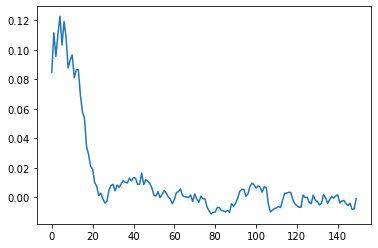

In [64]:
# B[1][3] convergence
plt.plot([l[1][3] for l in test_Gibbs_full['B_mat']])

(array([ 7.,  8., 11., 13., 14., 16., 14.,  8.,  6.,  3.]),
 array([-0.0112732 , -0.00918234, -0.00709148, -0.00500062, -0.00290976,
        -0.0008189 ,  0.00127196,  0.00336282,  0.00545368,  0.00754454,
         0.0096354 ]),
 <BarContainer object of 10 artists>)

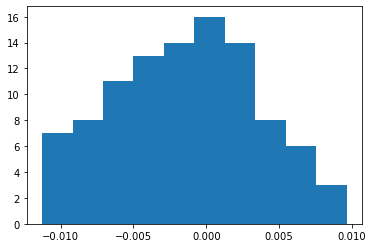

In [80]:
plt.hist([l[1][3] for l in test_Gibbs_full['B_mat'][-100:]])

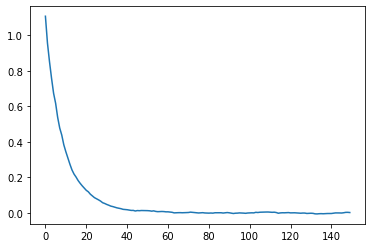

In [66]:
# B[1][2] convergence
plt.plot([l[1][2] for l in test_Gibbs_full['B_mat']])

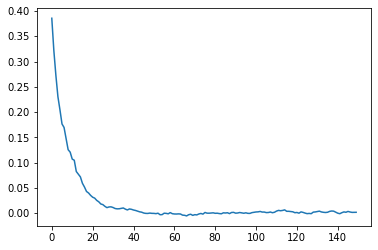

In [67]:
# B[1][1] convergence
plt.plot([l[1][1] for l in test_Gibbs_full['B_mat']])

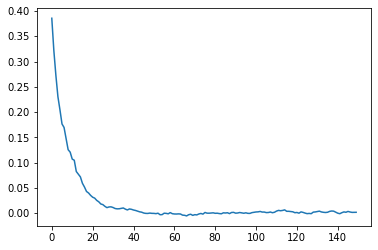

In [68]:
# B[1][0] convergence
plt.plot([l[1][1] for l in test_Gibbs_full['B_mat']])

In [69]:
test_Gibbs_full['d_bar']

array([0.49676 , 0.50038 , 0.498121, 0.500201, 0.49877 , 0.496958,
       0.499315, 0.500287, 0.497995, 0.5002  , 0.497656, 0.498747,
       0.499054, 0.49946 , 0.499053, 0.498684, 0.501058, 0.497887,
       0.499495, 0.496816, 0.499131, 0.499662, 0.498618, 0.50104 ,
       0.501004, 0.498737, 0.500664, 0.50125 , 0.499755, 0.499866,
       0.500722, 0.500485, 0.498033, 0.500396, 0.497695, 0.498913,
       0.499427, 0.499764, 0.499545, 0.499235, 0.499942, 0.498178,
       0.498892, 0.497729, 0.496959, 0.497735, 0.500552, 0.500218,
       0.501317, 0.500766, 0.499126, 0.500261, 0.501977, 0.498935,
       0.501013, 0.497649, 0.497278, 0.498884, 0.49868 , 0.497005,
       0.499275, 0.50049 , 0.49627 , 0.499261, 0.499681, 0.500277,
       0.498709, 0.498248, 0.498632, 0.499233, 0.499837, 0.497826,
       0.498424, 0.500032, 0.499899, 0.498997, 0.500269, 0.498854,
       0.500395, 0.500958, 0.499444, 0.500226, 0.499647, 0.502408,
       0.498975, 0.501421, 0.499754, 0.499233, 0.500395, 0.499

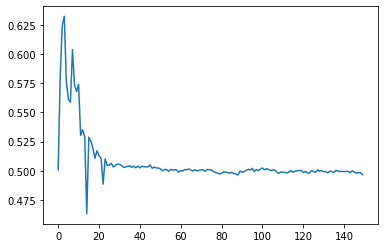

In [70]:
plt.plot(test_Gibbs_full['d_mat'].T[0])

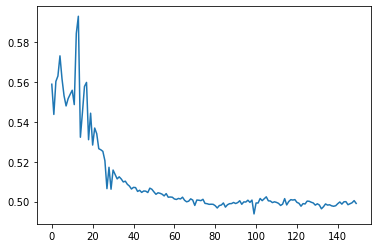

In [71]:
plt.plot(test_Gibbs_full['d_mat'].T[50])

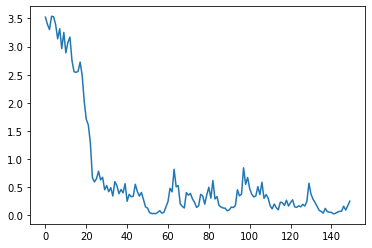

In [72]:
plt.plot(test_Gibbs_full['alpha_mat'])

In [73]:
test_Gibbs_full['alpha']

0.251913

In [74]:
test_Gibbs_full['H_mat'][-1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

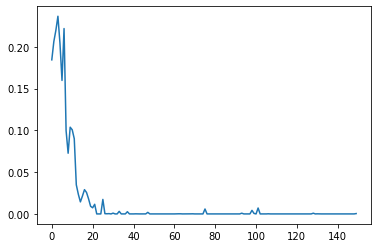

In [77]:
# W[0] convergence
plt.plot(np.array(test_Gibbs_full['W_mat']).T[0])

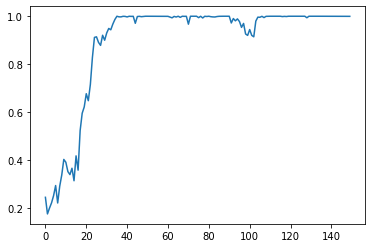

In [78]:
# W[1] convergence
plt.plot(np.array(test_Gibbs_full['W_mat']).T[1])